# Dataset Relationship Analysis

This notebook provides tools to analyze relationships between datasets from the organized Gapminder category folders.

## Features
- Load datasets from category folders (Physical, Mental, Social, Economic, Environmental, Cultural)
- Visualize relationships with scatter plots
- Calculate correlation coefficients and statistical significance
- Filter by year range and countries


In [ ]:
# Install required packages
%pip install pandas numpy matplotlib scipy


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
%matplotlib inline


## Helper Functions

Functions to load datasets from category folders and analyze relationships.


In [3]:
def load_dataset_from_category(category, indicator, year_range=None, countries=None):
    """
    Load a dataset from a category folder.
    
    Args:
        category: Category folder name (Physical, Mental, Social, Economic, Environmental, Cultural)
        indicator: Indicator name (e.g., 'suicide_per_100000_people')
        year_range: Optional tuple (start_year, end_year) to filter by year
        countries: Optional list of country codes to filter (e.g., ['usa', 'chn', 'ind'])
    
    Returns:
        pandas DataFrame with columns: geo, time, and the indicator value column
    """
    base_dir = Path("./data/gapminder")
    filename = f"ddf--datapoints--{indicator}--by--geo--time.csv"
    filepath = base_dir / category / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"Dataset not found: {filepath}")
    
    # Load the CSV
    df = pd.read_csv(filepath)
    
    # Filter by year range if provided
    if year_range:
        start_year, end_year = year_range
        df = df[(df['time'] >= start_year) & (df['time'] <= end_year)]
    
    # Filter by countries if provided
    if countries:
        df = df[df['geo'].isin(countries)]
    
    return df


def get_indicator_column_name(df):
    """
    Extract the indicator column name from a dataset DataFrame.
    Assumes the indicator column is the one that's not 'geo' or 'time'.
    """
    cols = [c for c in df.columns if c not in ['geo', 'time']]
    if len(cols) != 1:
        raise ValueError(f"Expected exactly one indicator column, found: {cols}")
    return cols[0]


In [4]:
def analyze_relationship_scatter(indicator1, category1, indicator2, category2, 
                                  year_range=(1999, 2024), countries=None, 
                                  figsize=(10, 8), alpha=0.6, s=30):
    """
    Analyze the relationship between two indicators using a scatter plot.
    
    Args:
        indicator1: First indicator name
        category1: Category folder for first indicator
        indicator2: Second indicator name
        category2: Category folder for second indicator
        year_range: Tuple (start_year, end_year) to filter data
        countries: Optional list of country codes to filter
        figsize: Figure size tuple
        alpha: Transparency of scatter points
        s: Size of scatter points
    
    Returns:
        tuple: (merged DataFrame, Pearson correlation, p-value)
    """
    # Load both datasets
    df1 = load_dataset_from_category(category1, indicator1, year_range=year_range, countries=countries)
    df2 = load_dataset_from_category(category2, indicator2, year_range=year_range, countries=countries)
    
    # Get column names
    col1 = get_indicator_column_name(df1)
    col2 = get_indicator_column_name(df2)
    
    # Merge on geo and time
    merged = df1.merge(df2, on=['geo', 'time'], how='inner', suffixes=('', '_y'))
    merged = merged[['geo', 'time', col1, col2]].copy()
    
    # Remove rows with missing values
    merged_clean = merged.dropna(subset=[col1, col2])
    
    if len(merged_clean) == 0:
        raise ValueError("No overlapping data points found after merging datasets")
    
    # Calculate correlations
    pearson_r, pearson_p = pearsonr(merged_clean[col1], merged_clean[col2])
    spearman_r, spearman_p = spearmanr(merged_clean[col1], merged_clean[col2])
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scatter plot with color by year
    scatter = ax.scatter(merged_clean[col1], merged_clean[col2], 
                        c=merged_clean['time'], cmap='viridis', 
                        alpha=alpha, s=s, edgecolors='black', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(merged_clean[col1], merged_clean[col2], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(merged_clean[col1].min(), merged_clean[col1].max(), 100)
    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, 
            label=f'Trend line (r={pearson_r:.3f})')
    
    # Labels and title
    ax.set_xlabel(indicator1.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel(indicator2.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    
    title = f'Relationship: {indicator1.replace("_", " ").title()} vs {indicator2.replace("_", " ").title()}'
    if year_range:
        title += f'\n({year_range[0]}-{year_range[1]}, n={len(merged_clean):,} data points)'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add correlation info as text
    relationship_type = 'Positive' if pearson_r > 0 else 'Negative'
    strength = 'Strong' if abs(pearson_r) > 0.7 else 'Moderate' if abs(pearson_r) > 0.3 else 'Weak'
    significance = 'Significant' if pearson_p < 0.05 else 'Not significant'
    
    stats_text = f'Pearson r = {pearson_r:.3f} (p = {pearson_p:.3e})\n'
    stats_text += f'Spearman ρ = {spearman_r:.3f}\n'
    stats_text += f'{relationship_type} {strength} relationship ({significance})'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Colorbar for year
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Year', fontsize=10)
    
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Relationship Analysis Summary")
    print(f"{'='*60}")
    print(f"Dataset 1: {indicator1} ({category1})")
    print(f"Dataset 2: {indicator2} ({category2})")
    print(f"Period: {year_range[0]}-{year_range[1]}")
    print(f"Data Points: {len(merged_clean):,}")
    print(f"\nPearson Correlation: {pearson_r:.3f}")
    print(f"P-value: {pearson_p:.3e}")
    print(f"Significance: {significance} (α=0.05)")
    print(f"\nSpearman Correlation: {spearman_r:.3f}")
    print(f"P-value: {spearman_p:.3e}")
    print(f"\nRelationship: {relationship_type} {strength}")
    print(f"{'='*60}\n")
    
    return merged_clean, pearson_r, pearson_p


## Example Analysis: Suicide vs Life Expectancy

Let's analyze the relationship between suicide rates and life expectancy from the Physical category.


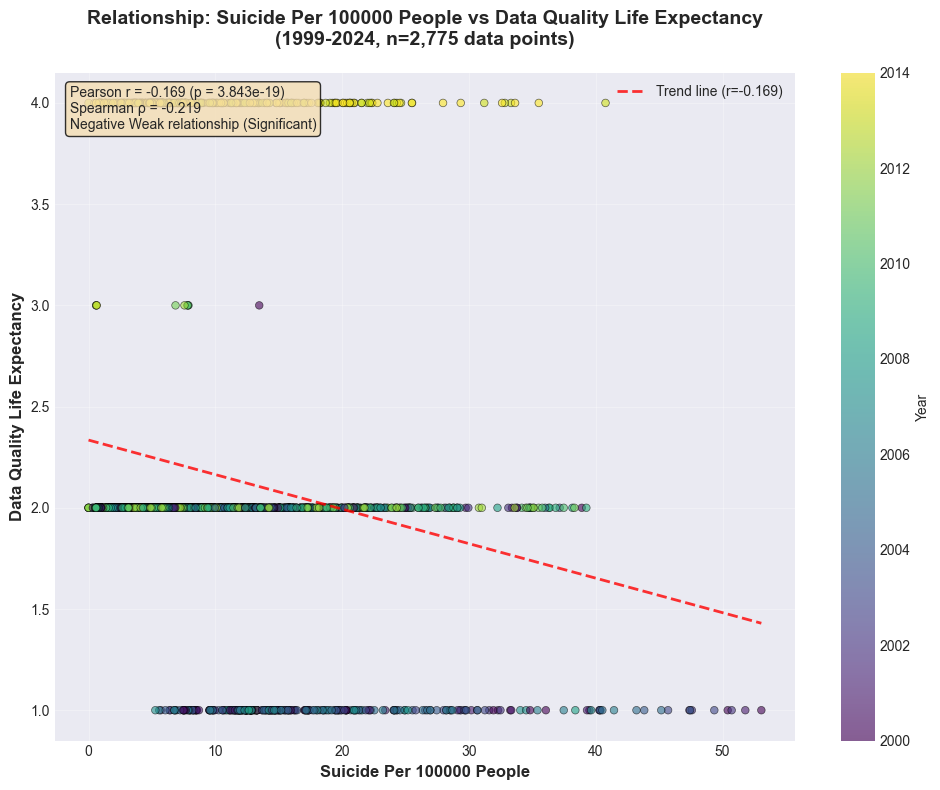


Relationship Analysis Summary
Dataset 1: suicide_per_100000_people (Physical)
Dataset 2: data_quality_life_expectancy (Physical)
Period: 1999-2024
Data Points: 2,775

Pearson Correlation: -0.169
P-value: 3.843e-19
Significance: Significant (α=0.05)

Spearman Correlation: -0.219
P-value: 1.522e-31

Relationship: Negative Weak



In [7]:
# Analyze relationship between suicide rates and life expectancy
# Using data from the last 25 years (1999-2024)
merged_df, correlation, p_value = analyze_relationship_scatter(
    indicator1='suicide_per_100000_people',
    category1='Physical',
    indicator2='data_quality_life_expectancy',
    category2='Physical',
    year_range=(1999, 2024)
)


## Time Series Analysis: Individual Trends

Let's examine how each indicator has changed over time from 2000 to 2024.


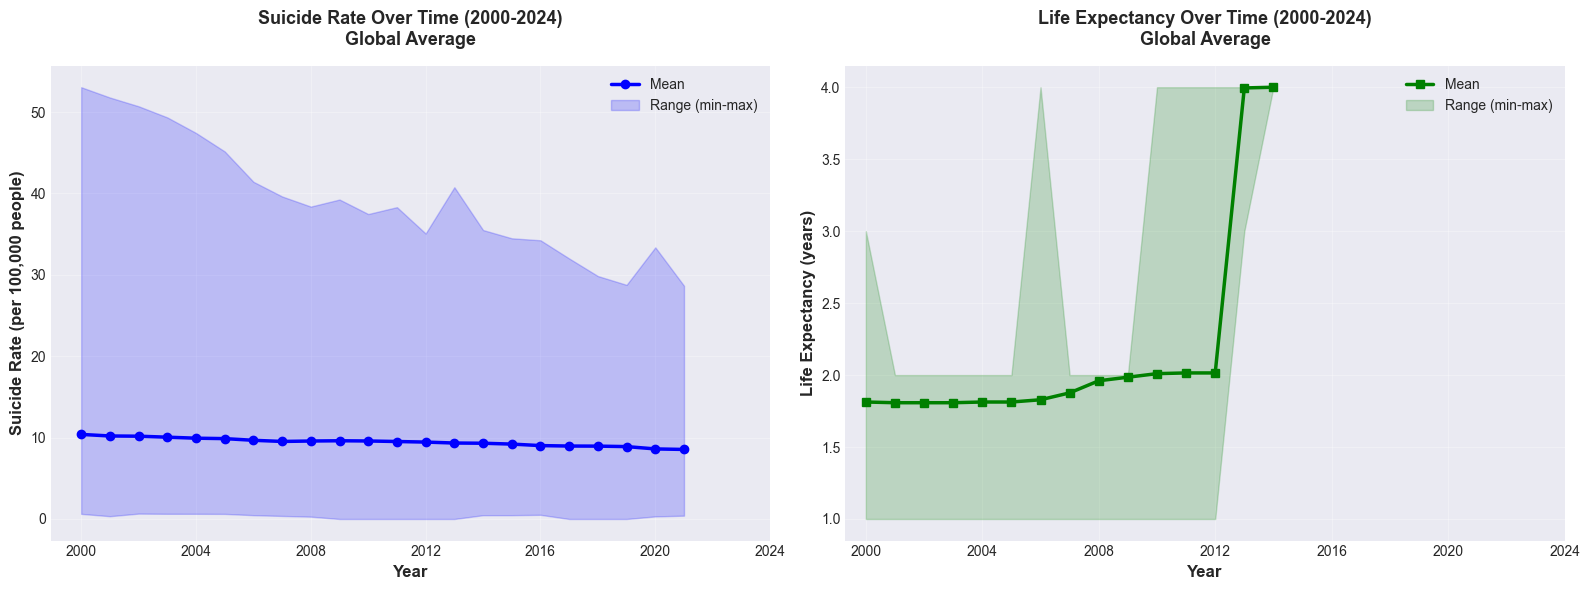


Time Series Summary (2000-2024)

Suicide Rate (per 100,000 people):
  Mean in 2000: 10.40
  Mean in 2021: 8.55
  Change: -1.85
  Overall mean: 9.47

Life Expectancy (years):
  Mean in 2000: 1.81
  Mean in 2014: 4.00
  Change: 2.19
  Overall mean: 2.17



In [8]:
# Create two separate line plots for suicide rates and life expectancy over time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Load data for both indicators
suicide_df = load_dataset_from_category('Physical', 'suicide_per_100000_people', year_range=(2000, 2024))
life_exp_df = load_dataset_from_category('Physical', 'data_quality_life_expectancy', year_range=(2000, 2024))

# Get column names
suicide_col = get_indicator_column_name(suicide_df)
life_exp_col = get_indicator_column_name(life_exp_df)

# Aggregate by year (mean across all countries)
suicide_yearly = suicide_df.groupby('time')[suicide_col].mean().reset_index()
life_exp_yearly = life_exp_df.groupby('time')[life_exp_col].mean().reset_index()

# Also get min/max for confidence bands
suicide_yearly['min'] = suicide_df.groupby('time')[suicide_col].min().values
suicide_yearly['max'] = suicide_df.groupby('time')[suicide_col].max().values
life_exp_yearly['min'] = life_exp_df.groupby('time')[life_exp_col].min().values
life_exp_yearly['max'] = life_exp_df.groupby('time')[life_exp_col].max().values

# Plot 1: Suicide Rate
ax1 = axes[0]
ax1.plot(suicide_yearly['time'], suicide_yearly[suicide_col], 
         'b-', linewidth=2.5, marker='o', markersize=6, label='Mean')
ax1.fill_between(suicide_yearly['time'], suicide_yearly['min'], suicide_yearly['max'], 
                 alpha=0.2, color='blue', label='Range (min-max)')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Suicide Rate (per 100,000 people)', fontsize=12, fontweight='bold')
ax1.set_title('Suicide Rate Over Time (2000-2024)\nGlobal Average', fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=10)
ax1.set_xticks(range(2000, 2025, 4))

# Plot 2: Life Expectancy
ax2 = axes[1]
ax2.plot(life_exp_yearly['time'], life_exp_yearly[life_exp_col], 
         'g-', linewidth=2.5, marker='s', markersize=6, label='Mean')
ax2.fill_between(life_exp_yearly['time'], life_exp_yearly['min'], life_exp_yearly['max'], 
                 alpha=0.2, color='green', label='Range (min-max)')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Life Expectancy (years)', fontsize=12, fontweight='bold')
ax2.set_title('Life Expectancy Over Time (2000-2024)\nGlobal Average', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=10)
ax2.set_xticks(range(2000, 2025, 4))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"Time Series Summary (2000-2024)")
print(f"{'='*60}")

# Get first and last available years
suicide_start_year = suicide_yearly['time'].min()
suicide_end_year = suicide_yearly['time'].max()
life_exp_start_year = life_exp_yearly['time'].min()
life_exp_end_year = life_exp_yearly['time'].max()

print(f"\nSuicide Rate (per 100,000 people):")
if len(suicide_yearly[suicide_yearly['time']==suicide_start_year]) > 0:
    start_val = suicide_yearly[suicide_yearly['time']==suicide_start_year][suicide_col].values[0]
    print(f"  Mean in {suicide_start_year}: {start_val:.2f}")
if len(suicide_yearly[suicide_yearly['time']==suicide_end_year]) > 0:
    end_val = suicide_yearly[suicide_yearly['time']==suicide_end_year][suicide_col].values[0]
    print(f"  Mean in {suicide_end_year}: {end_val:.2f}")
    if len(suicide_yearly[suicide_yearly['time']==suicide_start_year]) > 0:
        print(f"  Change: {end_val - start_val:.2f}")
print(f"  Overall mean: {suicide_yearly[suicide_col].mean():.2f}")

print(f"\nLife Expectancy (years):")
if len(life_exp_yearly[life_exp_yearly['time']==life_exp_start_year]) > 0:
    start_val = life_exp_yearly[life_exp_yearly['time']==life_exp_start_year][life_exp_col].values[0]
    print(f"  Mean in {life_exp_start_year}: {start_val:.2f}")
if len(life_exp_yearly[life_exp_yearly['time']==life_exp_end_year]) > 0:
    end_val = life_exp_yearly[life_exp_yearly['time']==life_exp_end_year][life_exp_col].values[0]
    print(f"  Mean in {life_exp_end_year}: {end_val:.2f}")
    if len(life_exp_yearly[life_exp_yearly['time']==life_exp_start_year]) > 0:
        print(f"  Change: {end_val - start_val:.2f}")
print(f"  Overall mean: {life_exp_yearly[life_exp_col].mean():.2f}")
print(f"{'='*60}\n")


## Try Other Dataset Pairs

You can easily analyze other relationships by changing the parameters below. Here are some examples:

**Physical:**
- `suicide_per_100000_people` vs `body_mass_index_bmi_men_kgperm2`

**Cross-category:**
- `internet_users` (Social) vs `gdp_per_capita_yearly_growth` (Economic)
- `urban_population` (Social) vs `electricity_use_per_person` (Environmental)
- `literacy_rate_adult` (Cultural) vs `income_share_of_richest_10percent` (Economic)


In [ ]:
# Example: Analyze another relationship
# Uncomment and modify the code below to try different dataset pairs

# merged_df, correlation, p_value = analyze_relationship_scatter(
#     indicator1='internet_users',
#     category1='Social',
#     indicator2='gdp_per_capita_yearly_growth',
#     category2='Economic',
#     year_range=(1999, 2024)
# )


## Available Categories and Datasets

**Physical:** suicide_per_100000_people, body_mass_index_bmi_men_kgperm2, data_quality_life_expectancy

**Mental:** data_quality_income_per_person, working_hours_per_week

**Social:** personal_computers_per_100_people, urban_population, blood_pressure_sbp_men_mmhg, cell_phones_per_100_people, government_and_society_aid_given_percent_of_aid, inequality_index_gini, internet_users

**Economic:** gdp_per_capita_yearly_growth, income_share_of_richest_10percent, aged_15plus_unemployment_rate_percent, aid_received_per_person_current_us, dollar_billionaires_per_million_people, extreme_poverty_percent_people_below_300_a_day

**Environmental:** coal_consumption_total, electricity_use_per_person, electricity_generation_total, energy_use_per_person, energy_production_total, municipal_water_withdrawal_percent_of_total, at_least_basic_water_source_overall_access_percent, cumulative_co2_emissions_tonnes

**Cultural:** males_aged_15_24_unemployment_rate_percent, mean_years_in_school_men_15_to_24_years, literacy_rate_adult, art_coverage_percent_cd4_l_350, education_aid_given_percent_of_aid, patent_applications_total


## Cultural Relationships

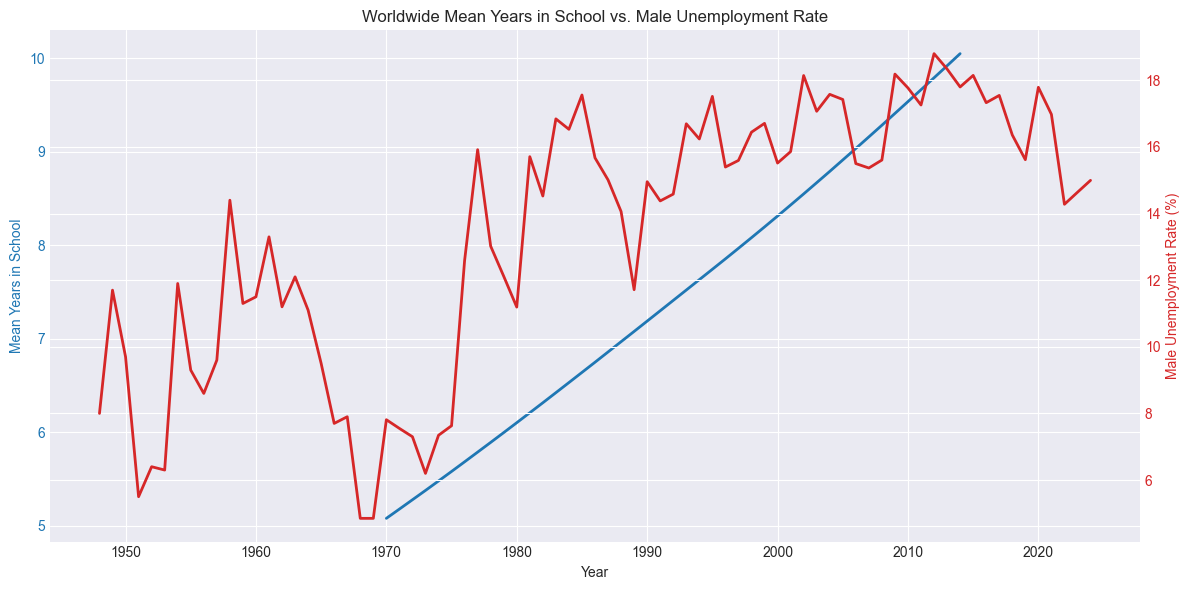

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets from the Cultural data folder
schooling_df = pd.read_csv('data/gapminder/Cultural/ddf--datapoints--mean_years_in_school_men_15_to_24_years--by--geo--time.csv')
unemployment_df = pd.read_csv('data/gapminder/Cultural/ddf--datapoints--males_aged_15_24_unemployment_rate_percent--by--geo--time.csv')

# Calculate the worldwide mean per year for both datasets
schooling_yearly = schooling_df.groupby('time')['mean_years_in_school_men_15_to_24_years'].mean()
unemployment_yearly = unemployment_df.groupby('time')['males_aged_15_24_unemployment_rate_percent'].mean()

# Limit the number of years until the second to last
schooling_yearly = schooling_yearly.iloc[:-1]
unemployment_yearly = unemployment_yearly.iloc[:-1]

# Create the dual axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Mean Years in School on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Years in School', color=color)
ax1.plot(schooling_yearly.index, schooling_yearly.values, color=color, linewidth=2, label='Mean Years in School')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Male Unemployment Rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Male Unemployment Rate (%)', color=color)
ax2.plot(unemployment_yearly.index, unemployment_yearly.values, color=color, linewidth=2, label='Male Unemployment Rate')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Worldwide Mean Years in School vs. Male Unemployment Rate')
fig.tight_layout()
plt.show()


Loading Cultural datasets...
Found 5 datasets in Cultural folder:
  - education_aid_given_percent_of_aid
  - mean_years_in_school_men_15_to_24_years
  - literacy_rate_adult
  - males_aged_15_24_unemployment_rate_percent
  - patent_applications_total

DUAL-AXIS LINE GRAPHS FOR CULTURAL DATASETS



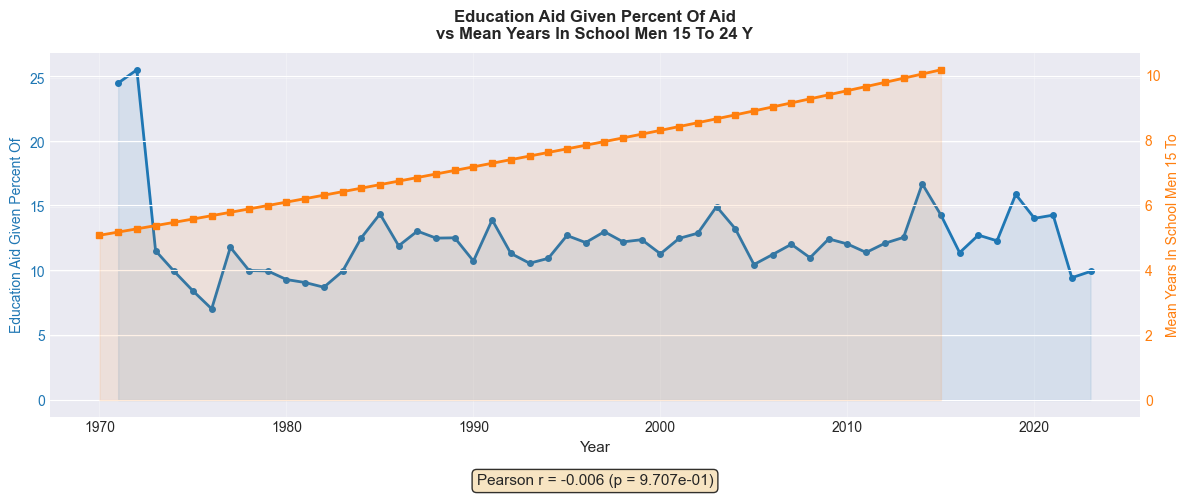

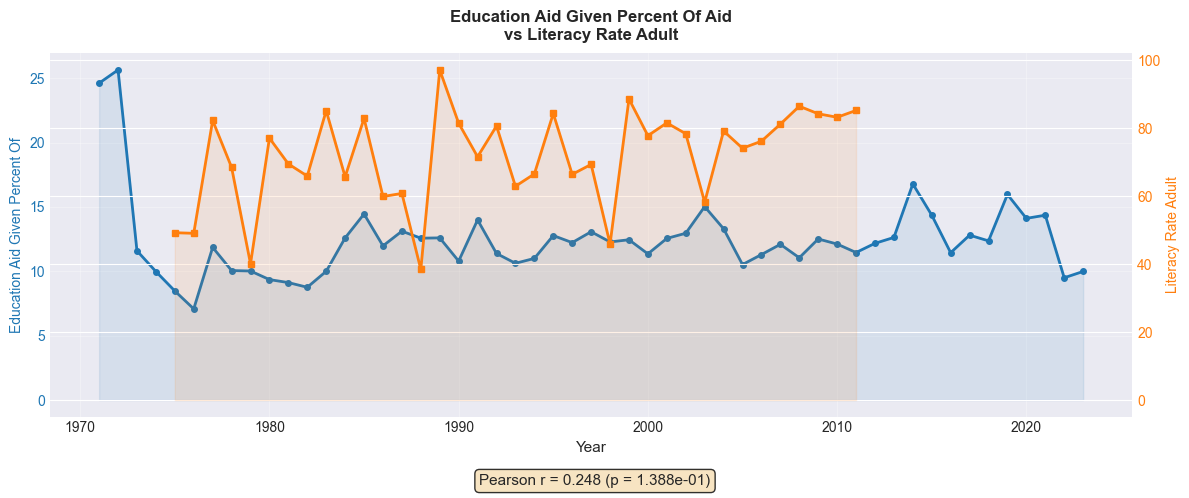

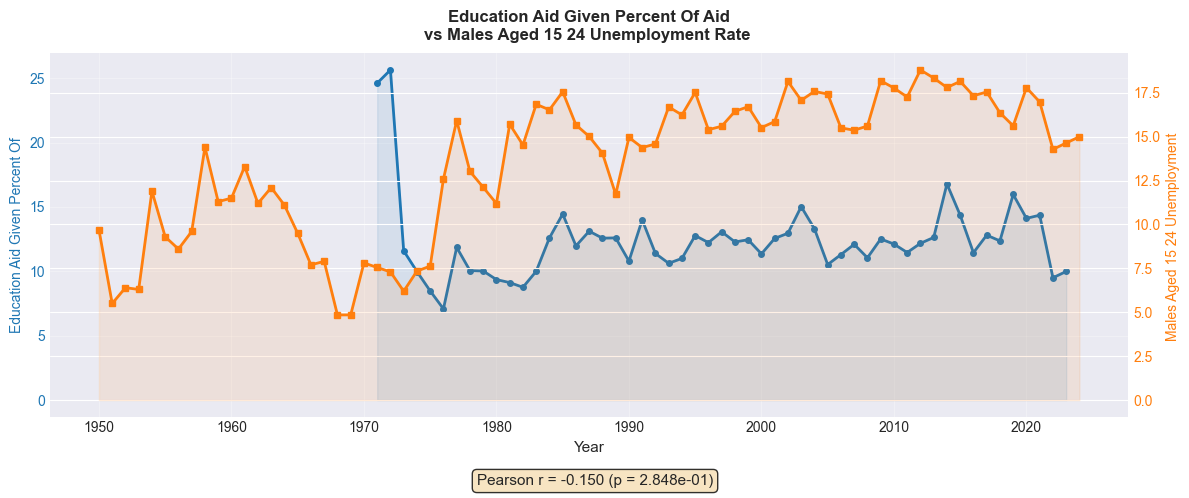

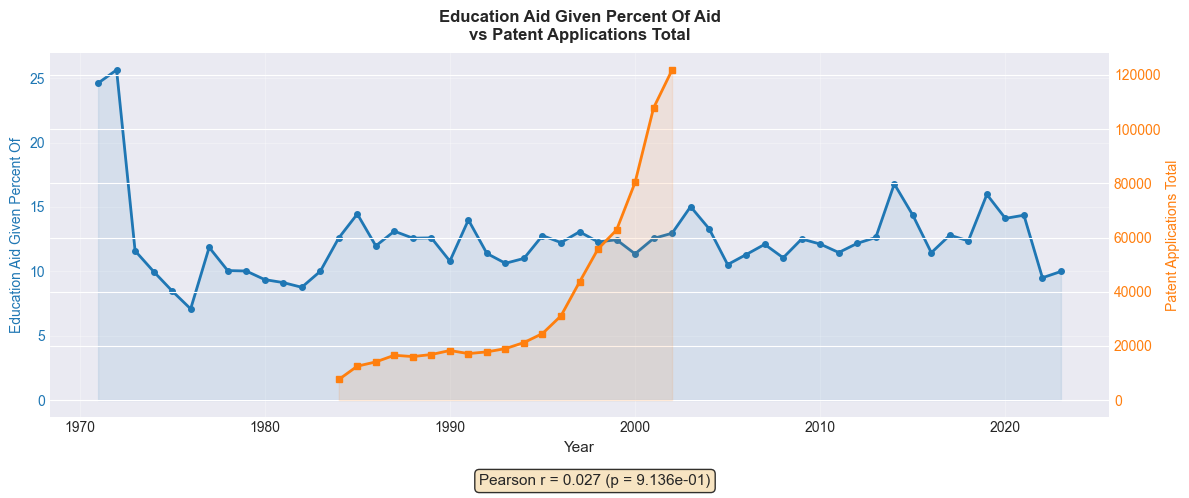

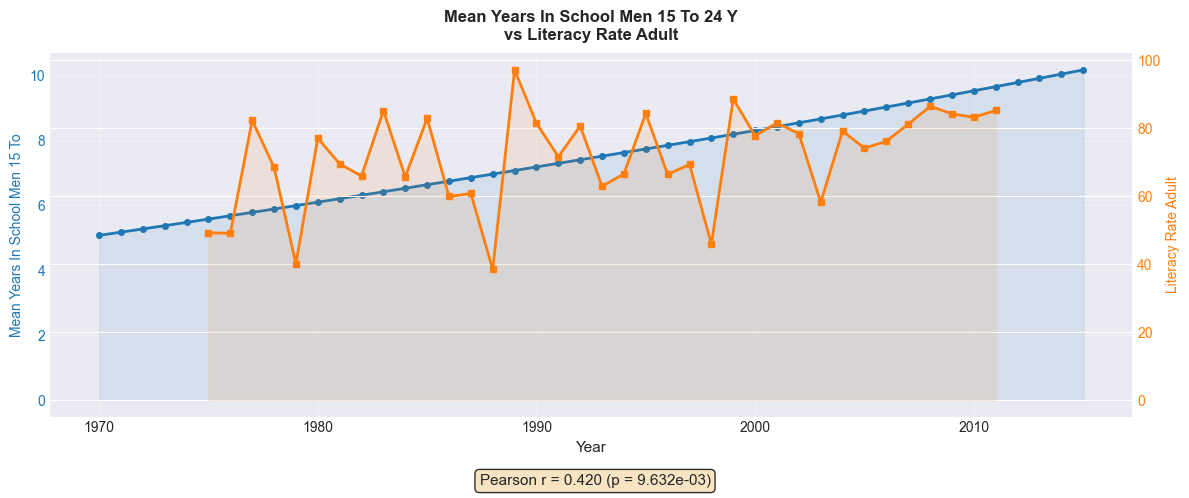

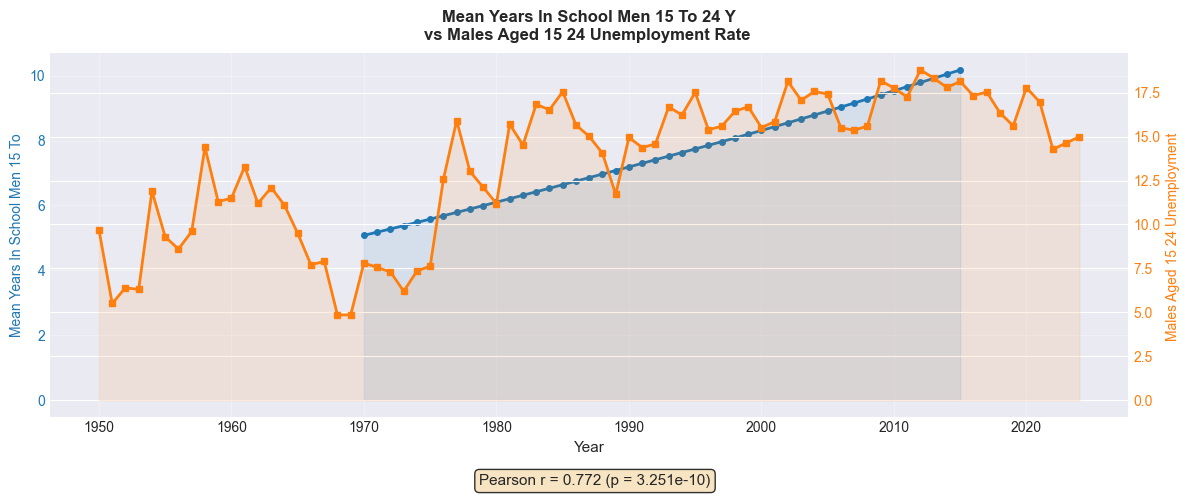

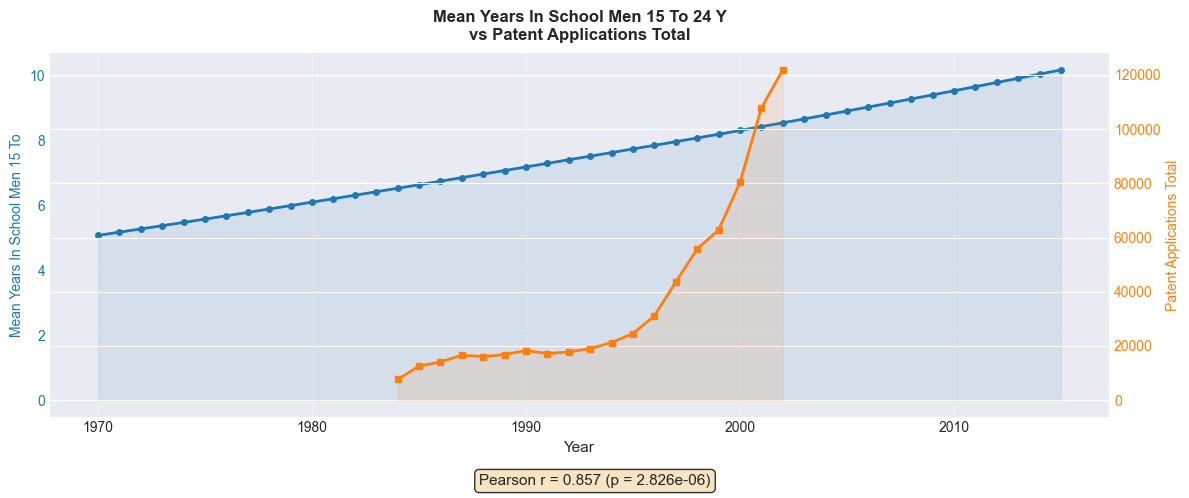

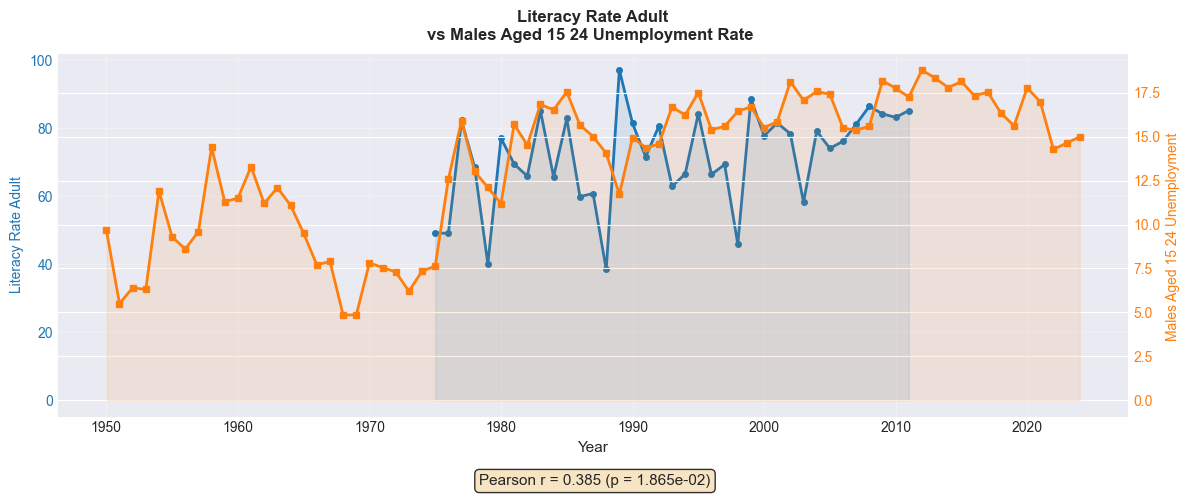

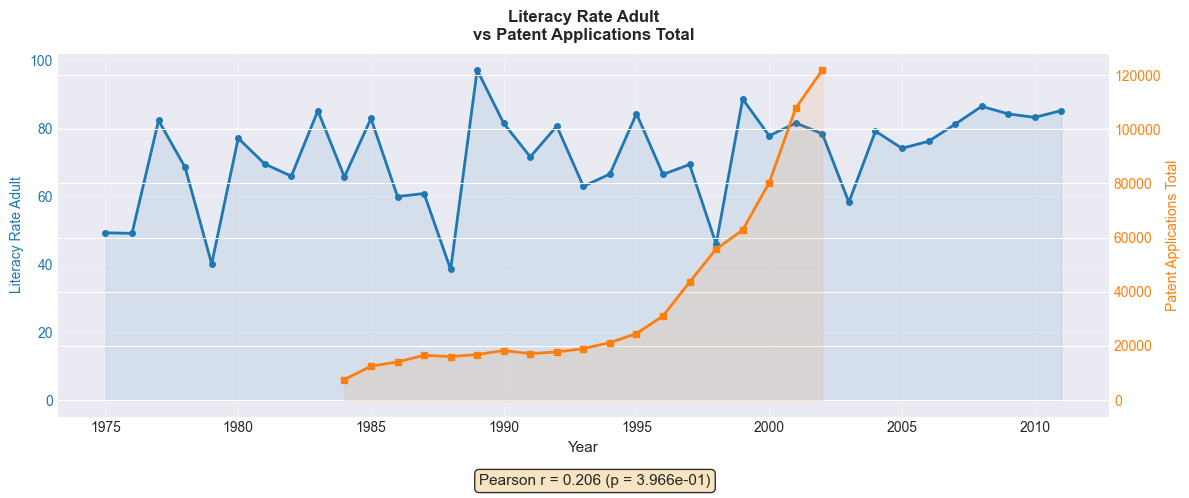

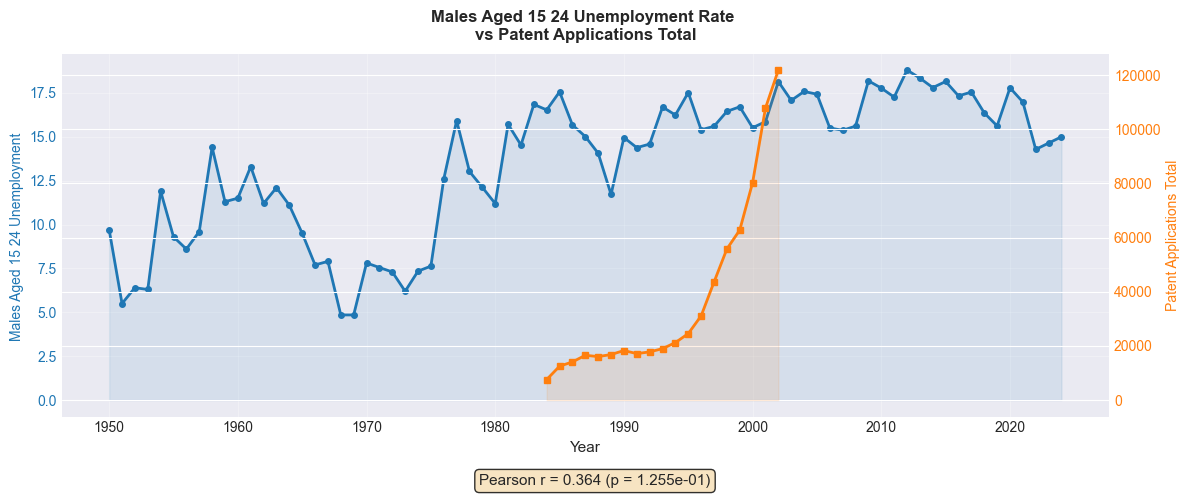

In [18]:
import os
from itertools import combinations
def load_cultural_datasets():
    """Load all datasets from the Cultural folder."""
    cultural_dir = Path('./data/gapminder/Cultural')
    datasets = {}
    
    for file in cultural_dir.glob('ddf--datapoints--*--by--geo--time.csv'):
        # Extract indicator name from filename
        parts = file.name.split('--')
        if len(parts) >= 3:
            indicator = parts[2]
            df = pd.read_csv(file)
            datasets[indicator] = df
    
    return datasets
def create_dual_axis_plot(df1, df2, name1, name2, year_range=(1950, 2024)):
    """Create a dual-axis line graph comparing two datasets aggregated by year."""
    # Get indicator column names
    col1 = [c for c in df1.columns if c not in ['geo', 'time']][0]
    col2 = [c for c in df2.columns if c not in ['geo', 'time']][0]
    
    # Filter by year range
    df1_filtered = df1[(df1['time'] >= year_range[0]) & (df1['time'] <= year_range[1])]
    df2_filtered = df2[(df2['time'] >= year_range[0]) & (df2['time'] <= year_range[1])]
    
    # Aggregate by year (mean across all countries)
    agg1 = df1_filtered.groupby('time')[col1].mean().reset_index()
    agg2 = df2_filtered.groupby('time')[col2].mean().reset_index()
    
    if len(agg1) == 0 or len(agg2) == 0:
        return None
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # First axis
    color1 = '#1f77b4'
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel(name1.replace('_', ' ').title()[:30], color=color1, fontsize=10)
    ax1.plot(agg1['time'], agg1[col1], color=color1, linewidth=2, marker='o', markersize=4, label=name1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.fill_between(agg1['time'], agg1[col1], alpha=0.1, color=color1)
    
    # Second axis
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel(name2.replace('_', ' ').title()[:30], color=color2, fontsize=10)
    ax2.plot(agg2['time'], agg2[col2], color=color2, linewidth=2, marker='s', markersize=4, label=name2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.fill_between(agg2['time'], agg2[col2], alpha=0.1, color=color2)
    
    # Calculate correlation
    merged = agg1.merge(agg2, on='time', how='inner')
    if len(merged) > 2:
        corr, p_val = pearsonr(merged[col1], merged[col2])
        corr_text = f'Pearson r = {corr:.3f} (p = {p_val:.3e})'
        fig.text(0.5, 0.02, corr_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Title
    title1 = name1.replace('_', ' ').title()[:35]
    title2 = name2.replace('_', ' ').title()[:35]
    plt.title(f'{title1}\nvs {title2}', fontsize=12, fontweight='bold', pad=10)
    
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    ax1.grid(True, alpha=0.3)
    
    return fig
# Load all Cultural datasets
print('Loading Cultural datasets...')
cultural_datasets = load_cultural_datasets()
print(f'Found {len(cultural_datasets)} datasets in Cultural folder:')
for name in cultural_datasets.keys():
    print(f'  - {name}')
# Create dual-axis plots for all combinations
print('\n' + '='*70)
print('DUAL-AXIS LINE GRAPHS FOR CULTURAL DATASETS')
print('='*70 + '\n')
dataset_names = list(cultural_datasets.keys())
for name1, name2 in combinations(dataset_names, 2):
    fig = create_dual_axis_plot(
        cultural_datasets[name1], 
        cultural_datasets[name2],
        name1, 
        name2
    )
    if fig:
        plt.show()
        plt.close()
    else:
        print(f'Could not create plot for {name1} vs {name2} (insufficient data)')

## Economic

Loading Economic datasets...
Found 9 datasets in Economic folder:
  - aid_received_per_person_current_us
  - working_hours_per_week
  - dollar_billionaires_per_million_people
  - extreme_poverty_percent_people_below_300_a_day
  - inequality_index_gini
  - gdp_per_capita_yearly_growth
  - gdpperworking_hour_us_inflation_adjusted
  - income_share_of_richest_10percent
  - aged_15plus_unemployment_rate_percent

DUAL-AXIS LINE GRAPHS FOR ECONOMIC DATASETS



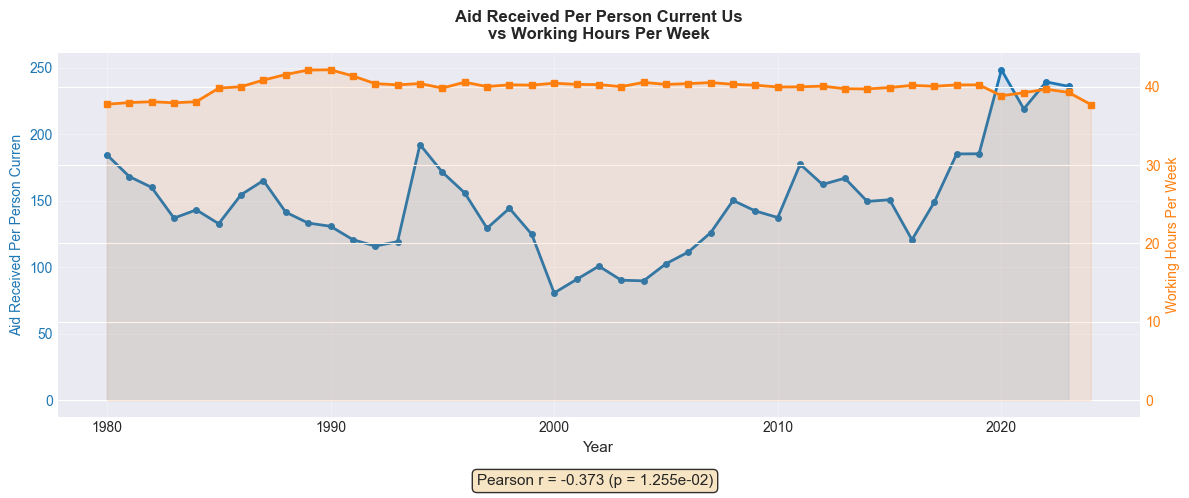

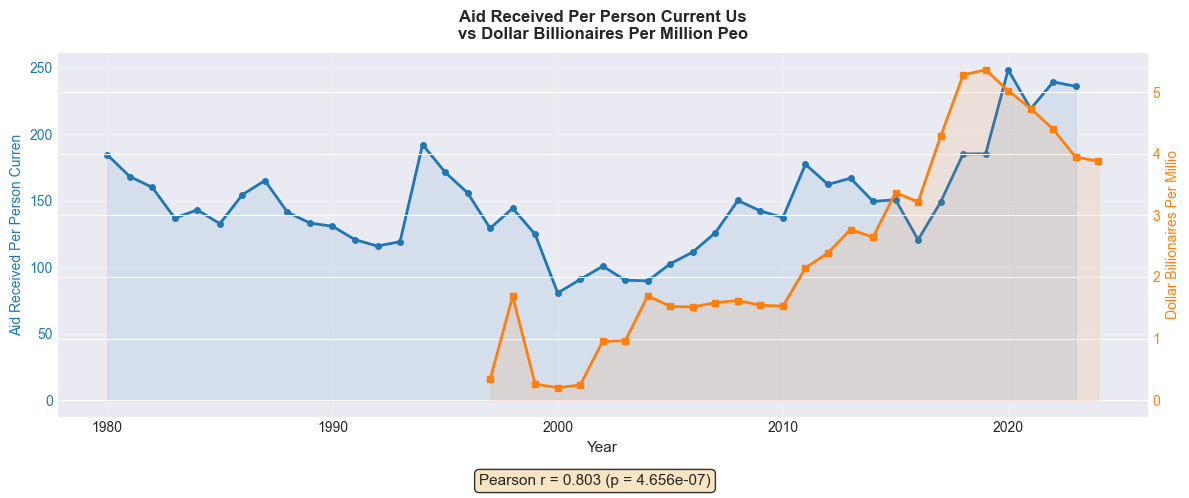

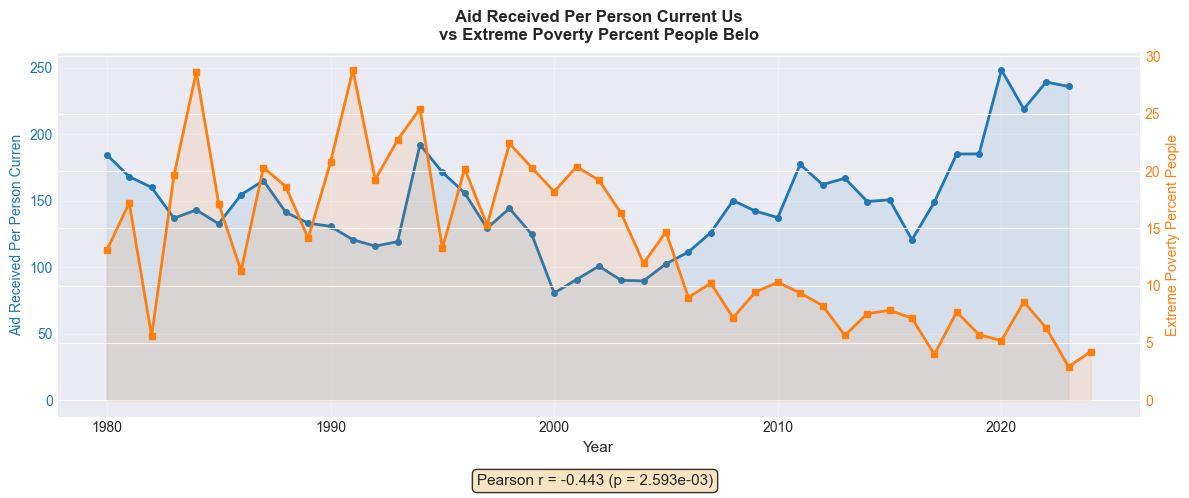

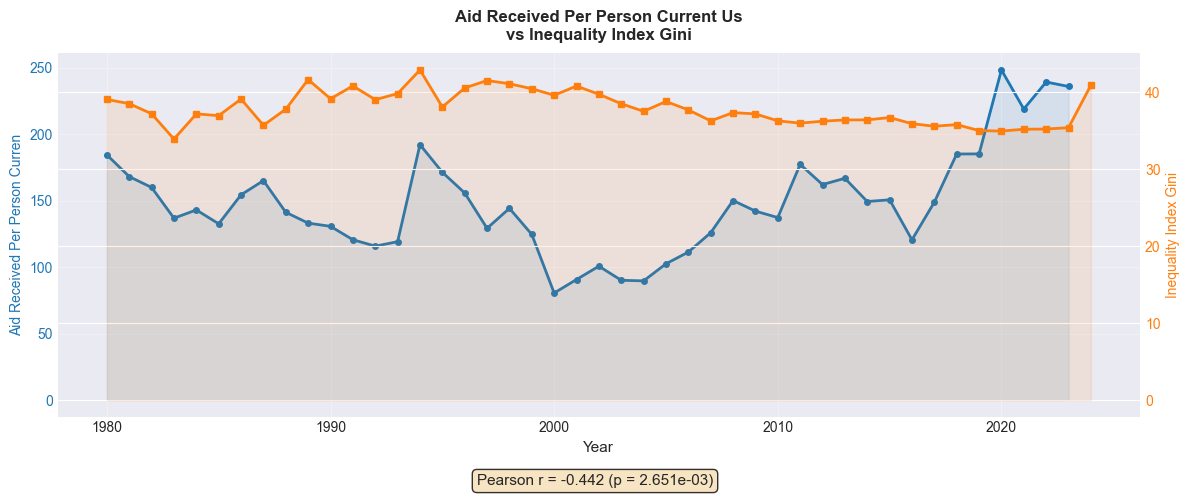

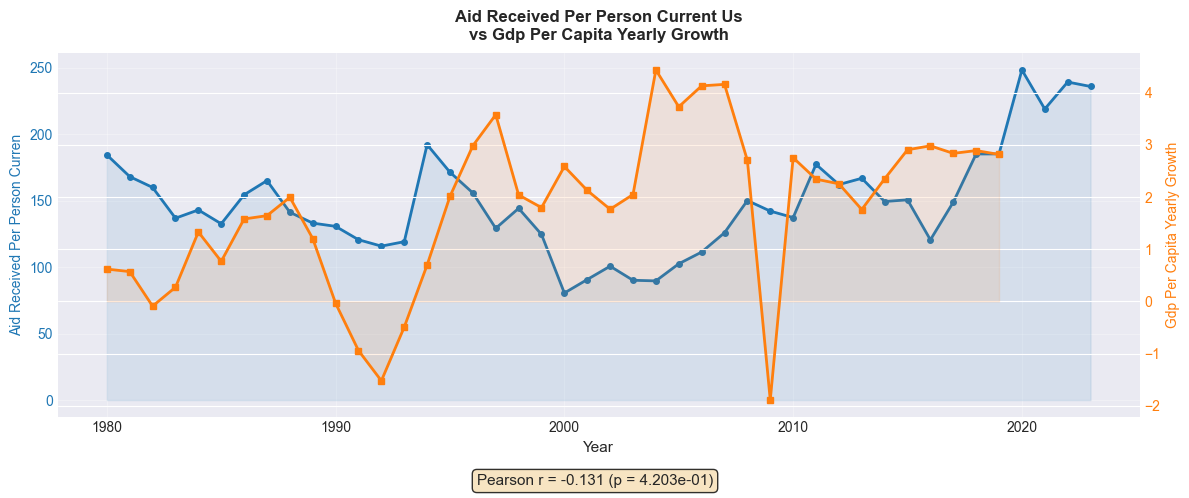

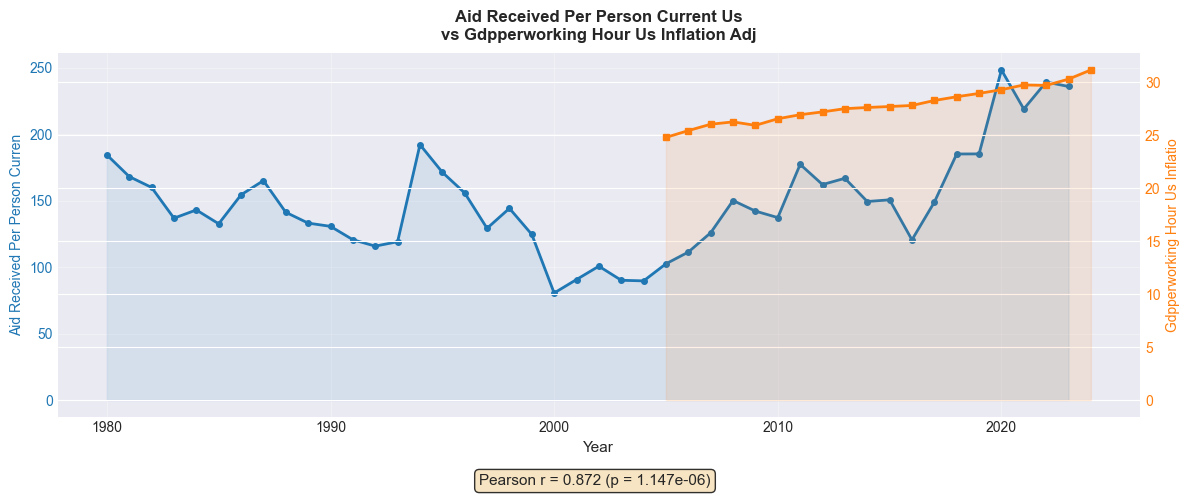

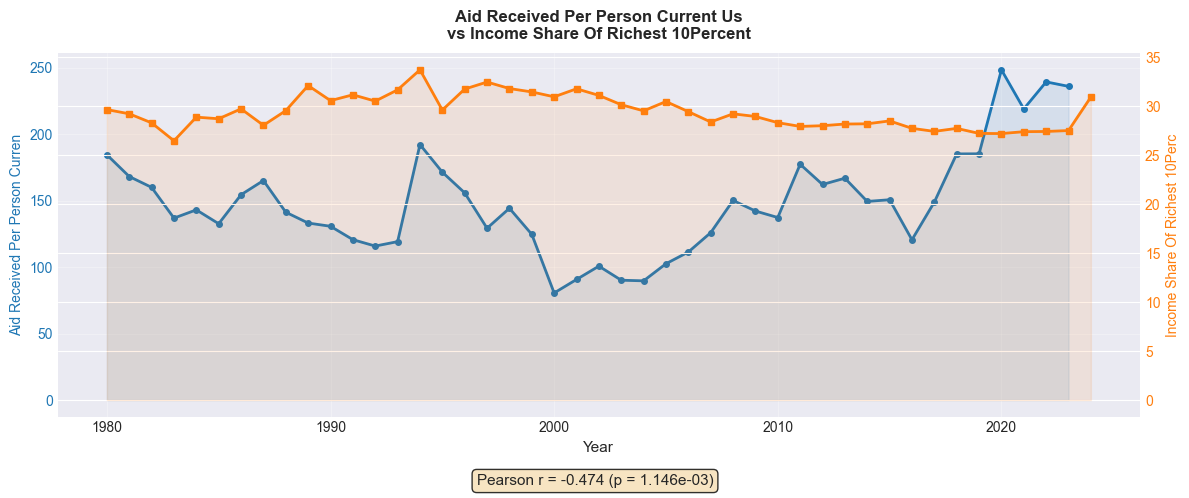

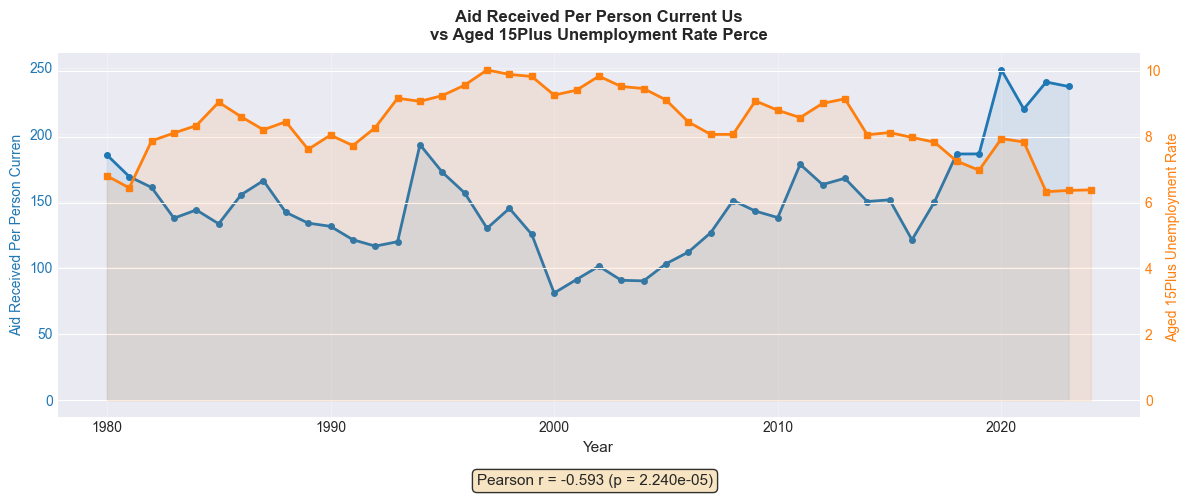

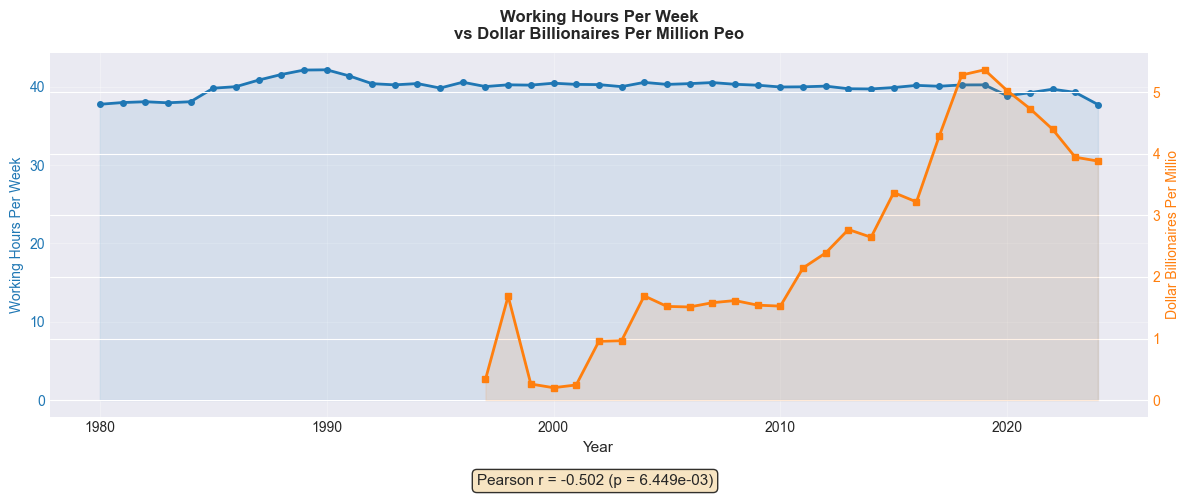

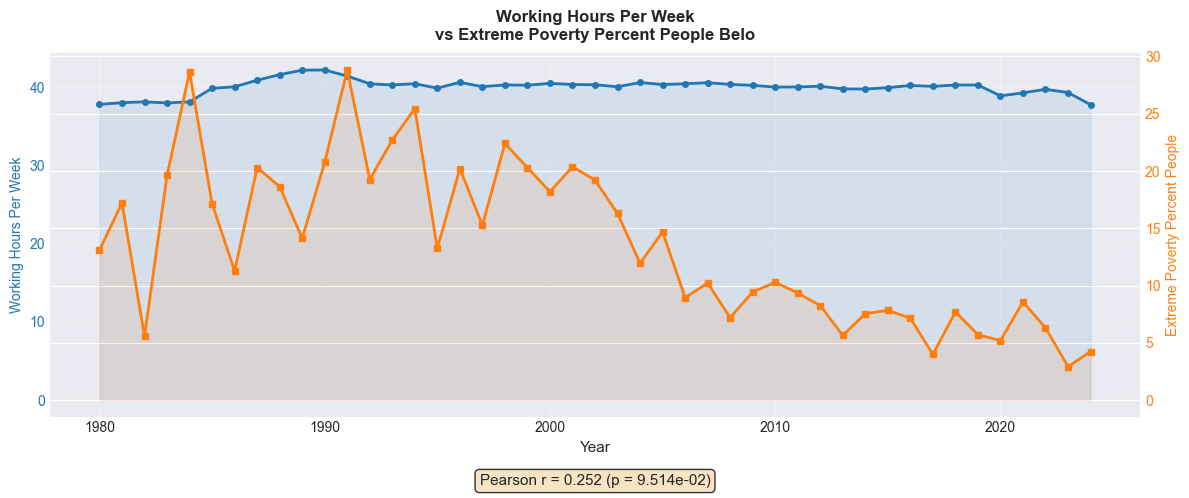

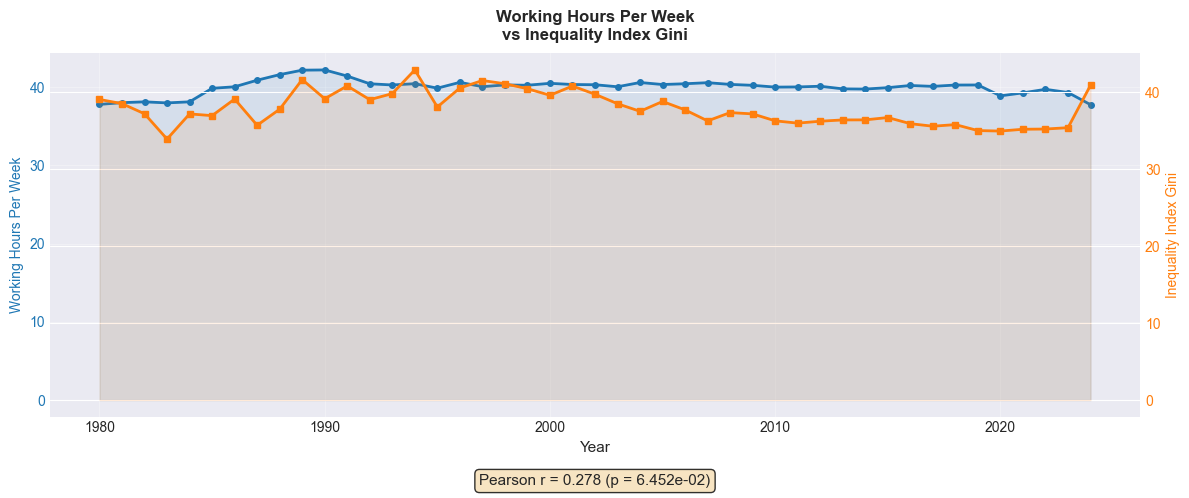

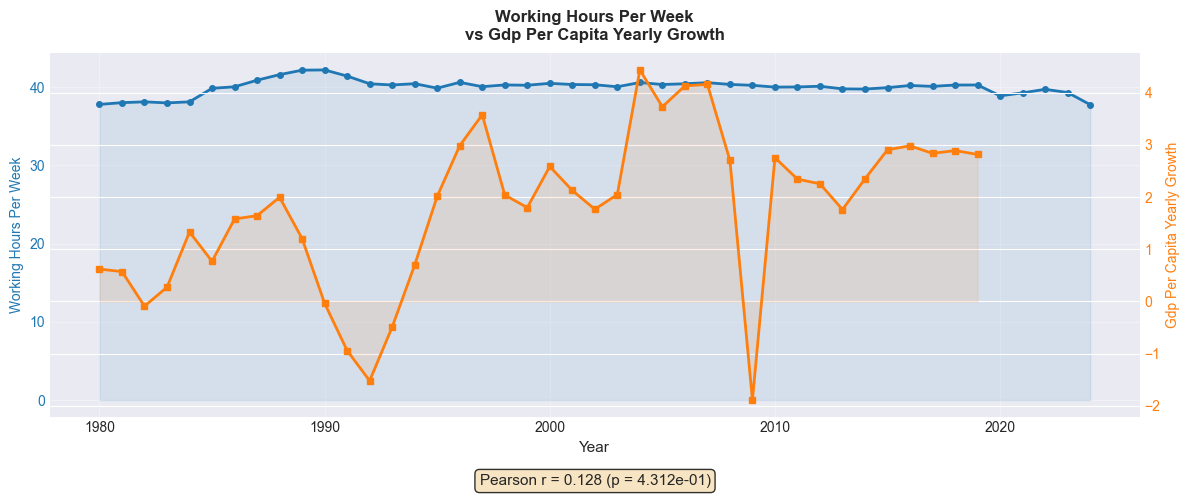

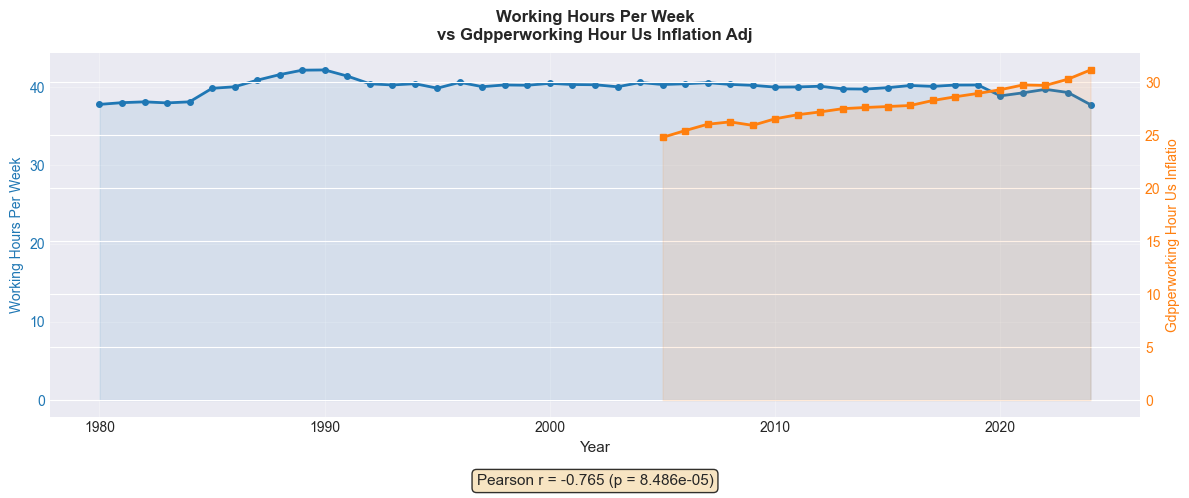

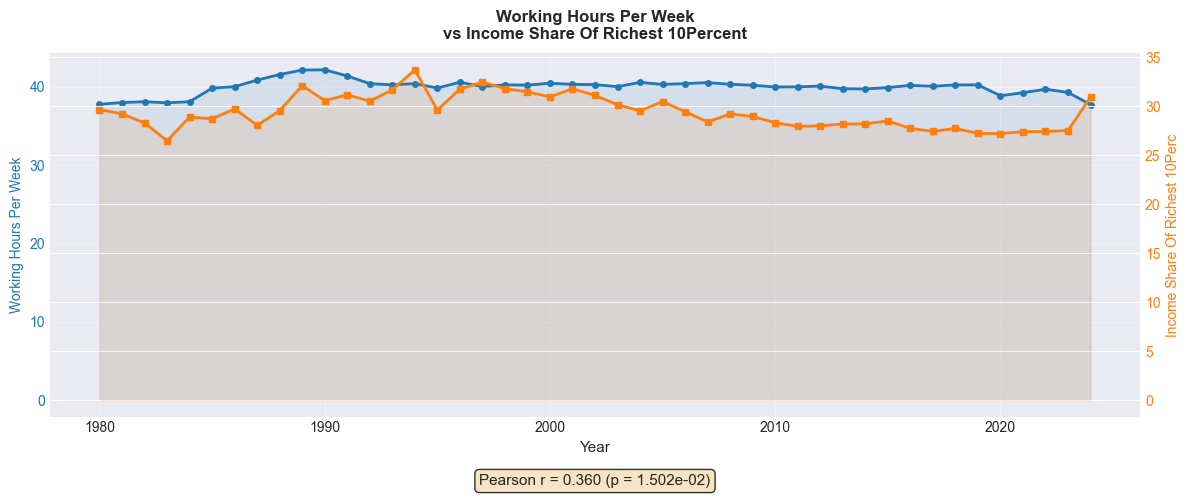

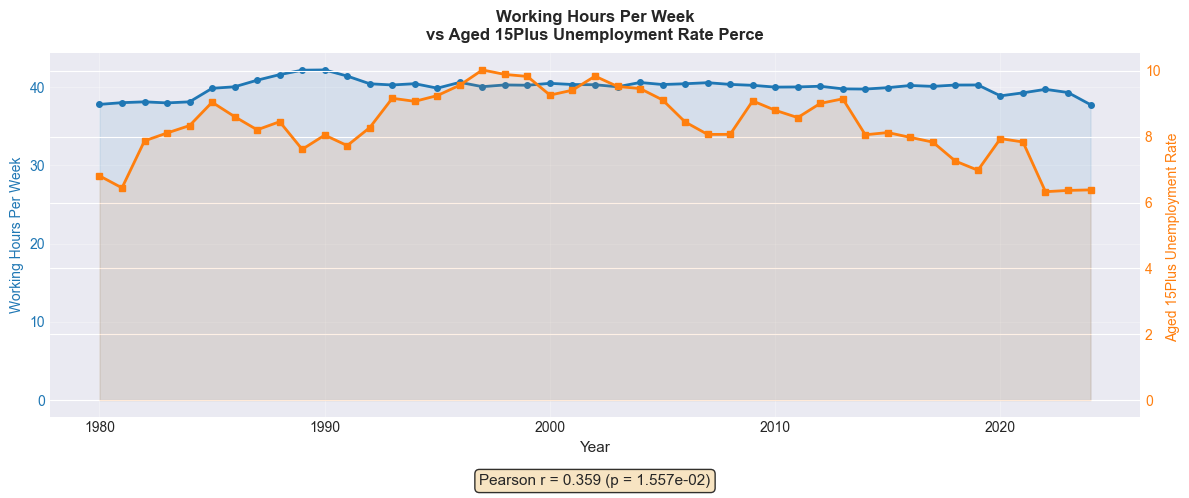

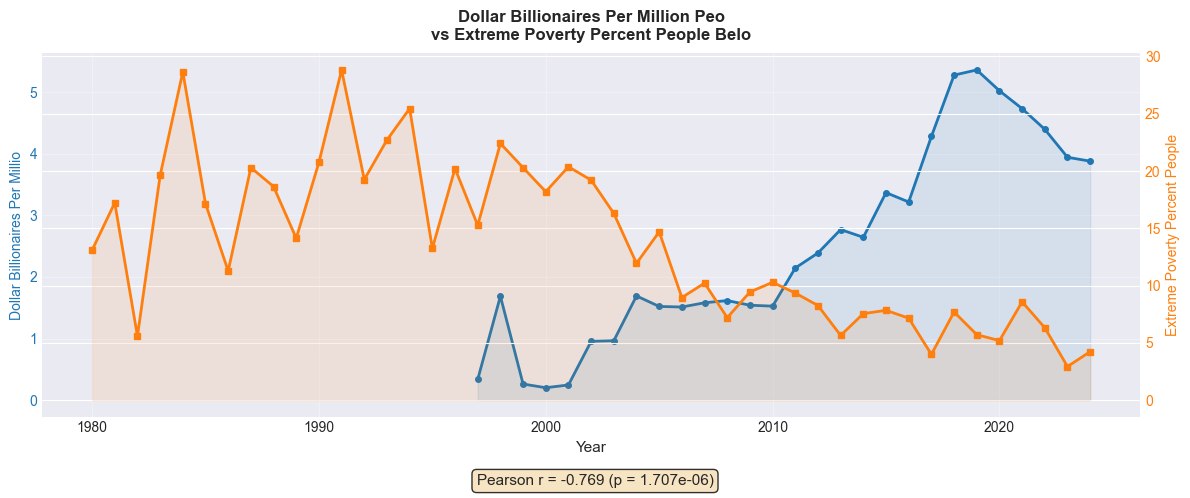

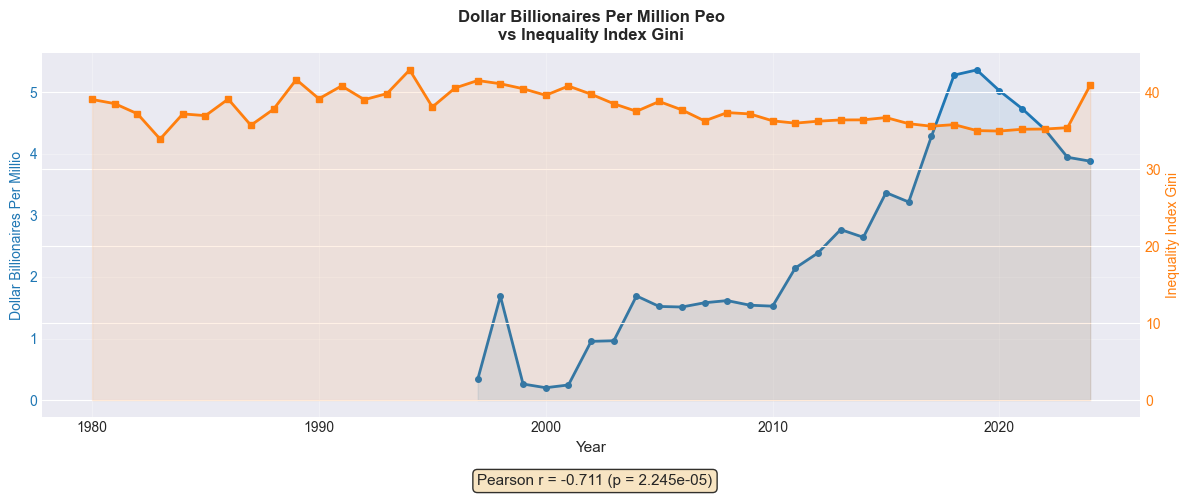

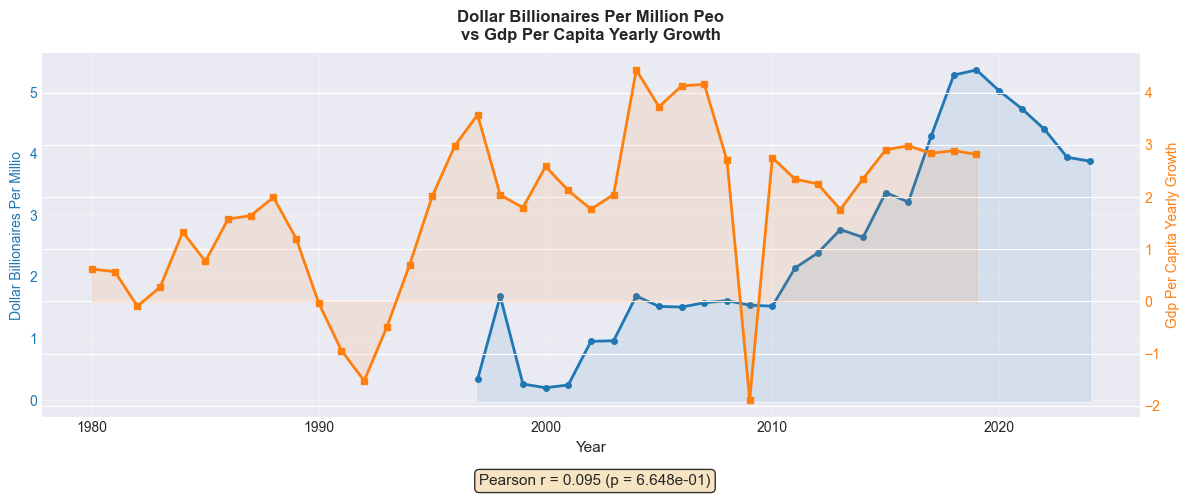

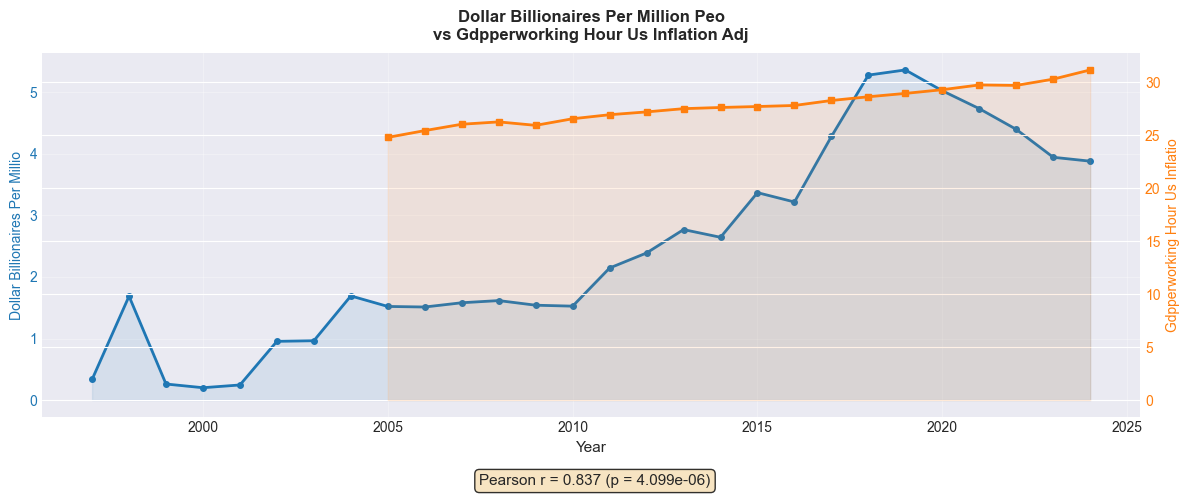

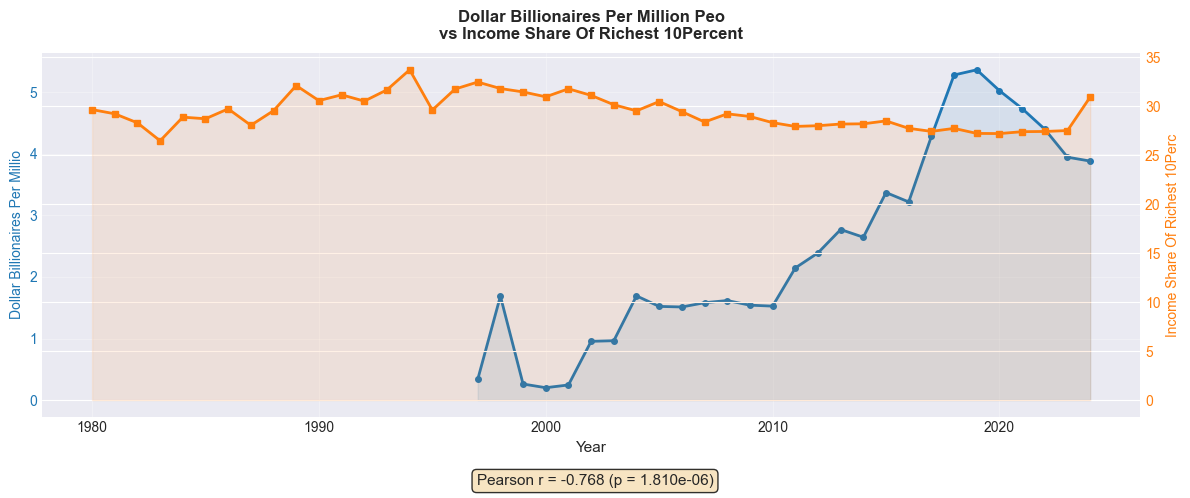

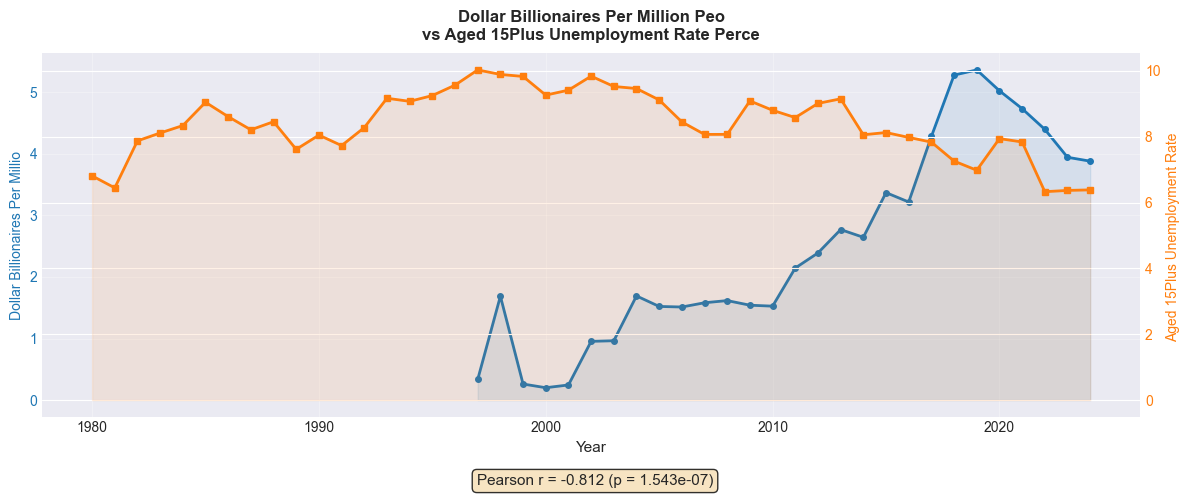

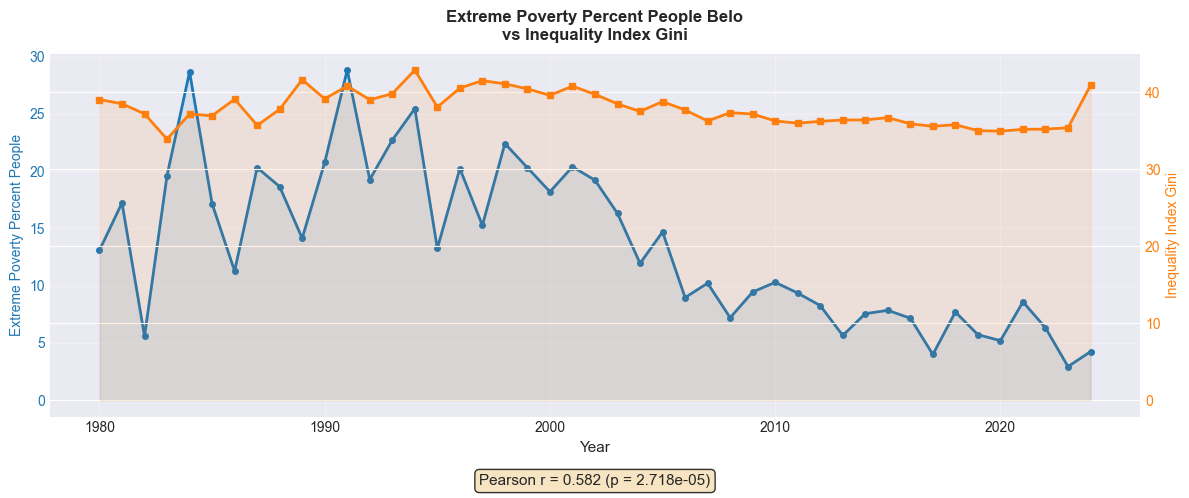

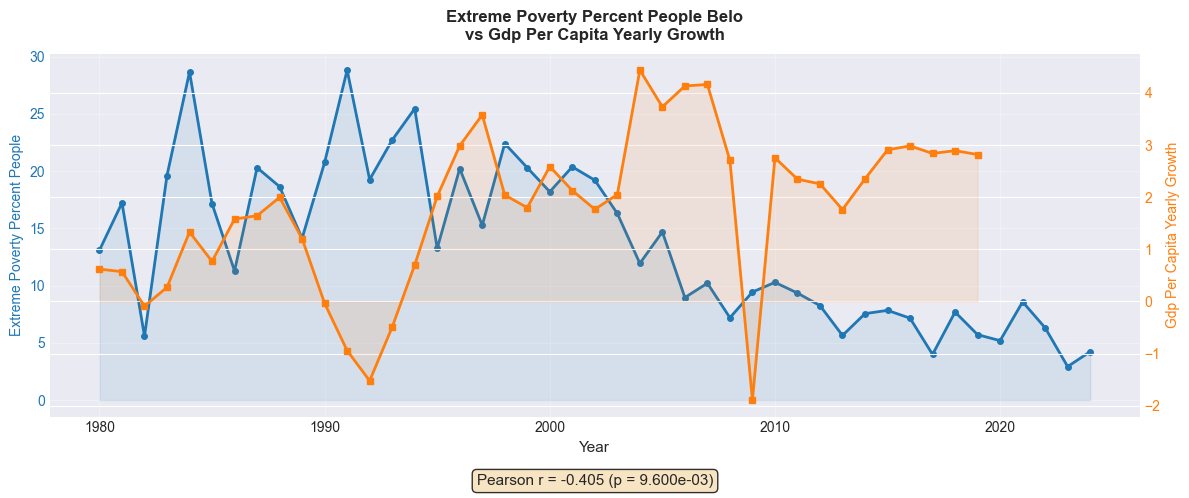

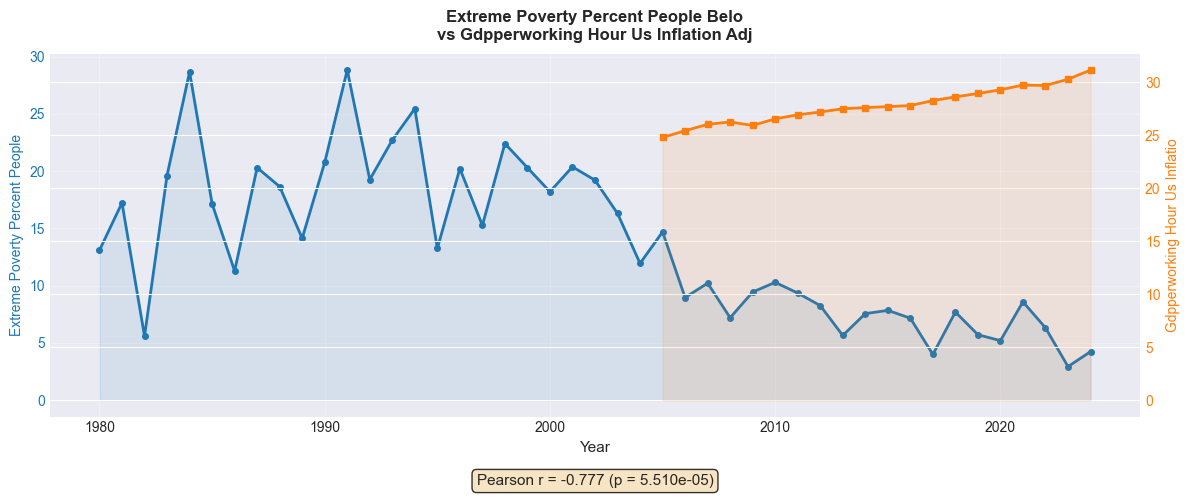

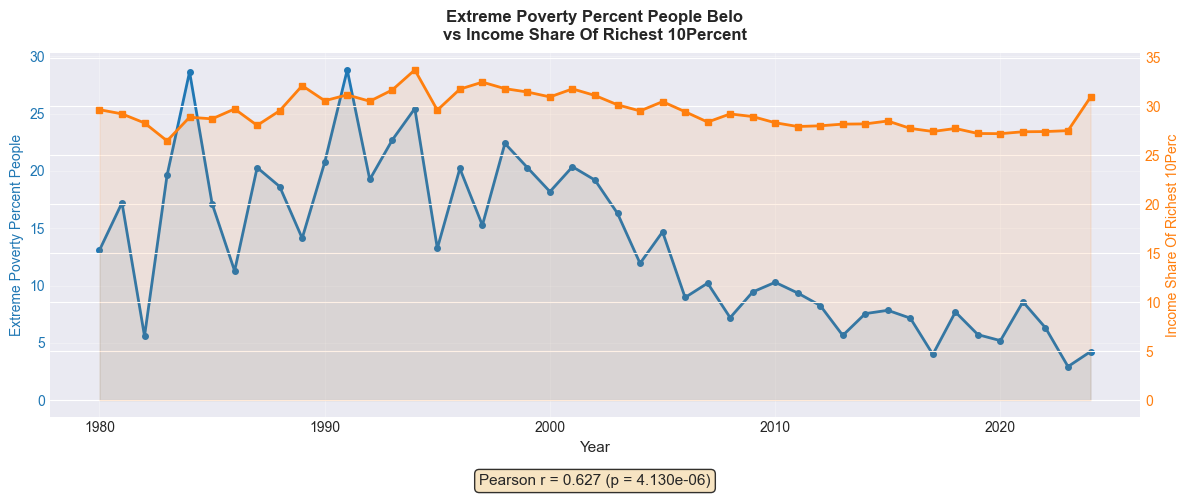

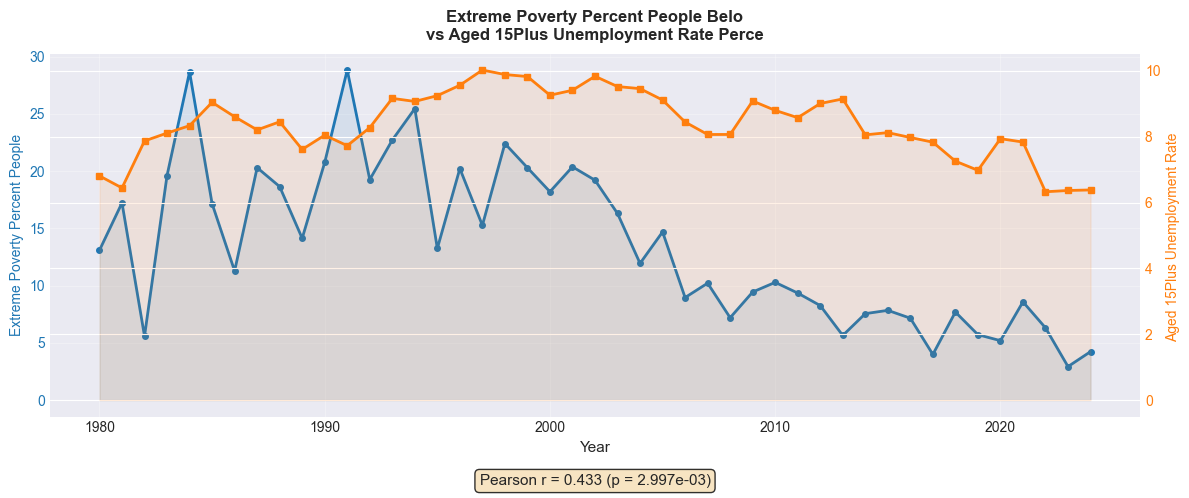

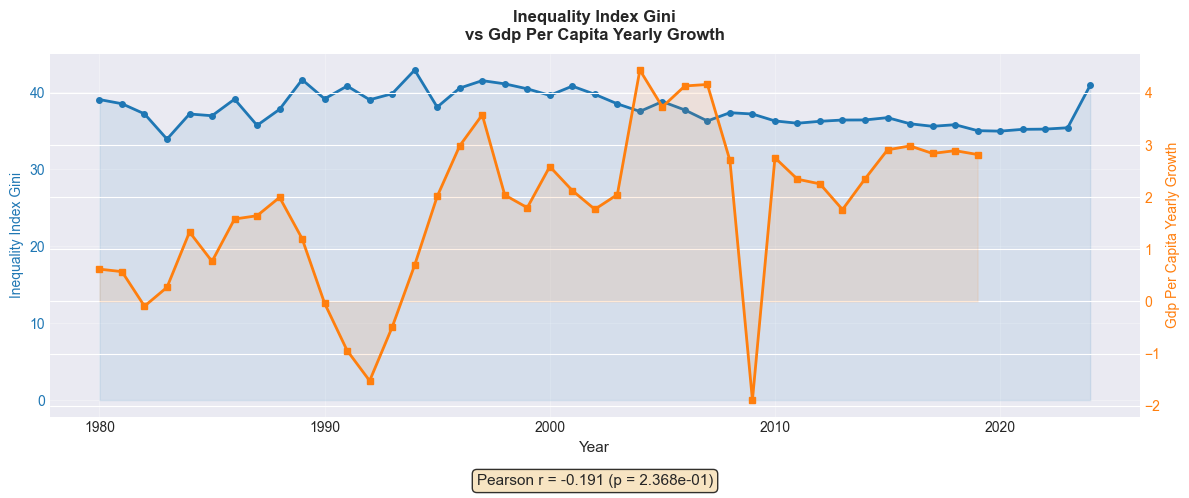

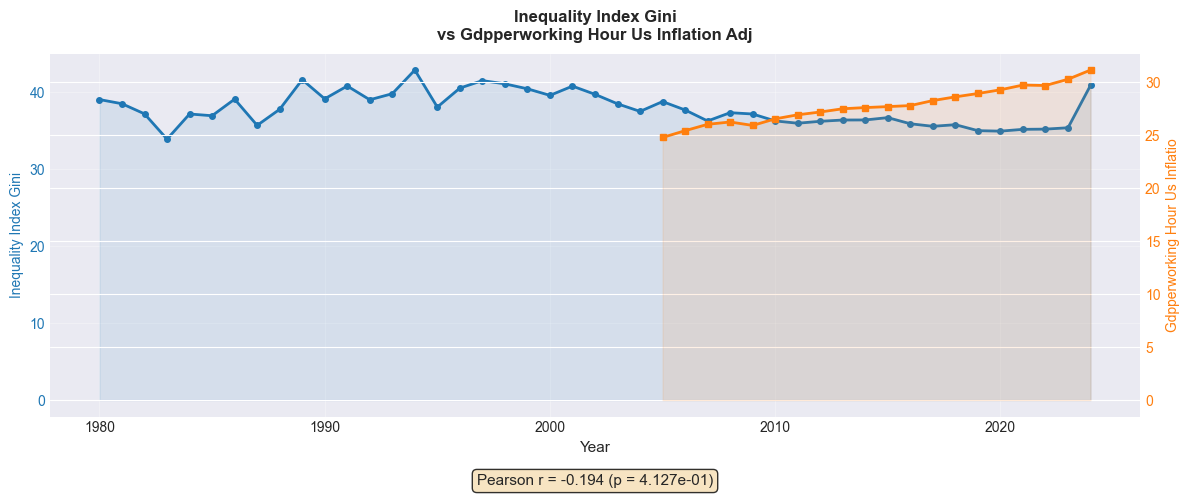

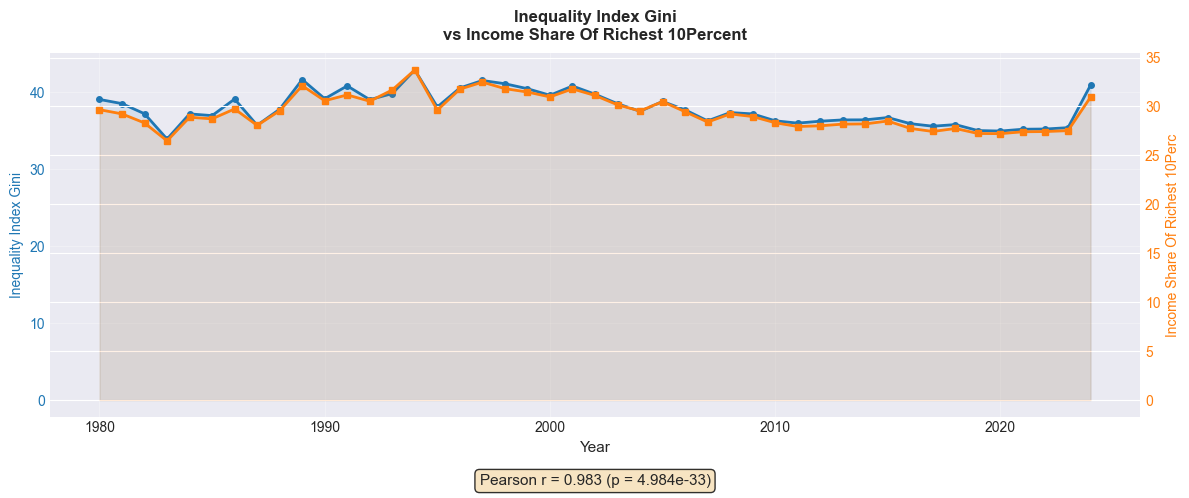

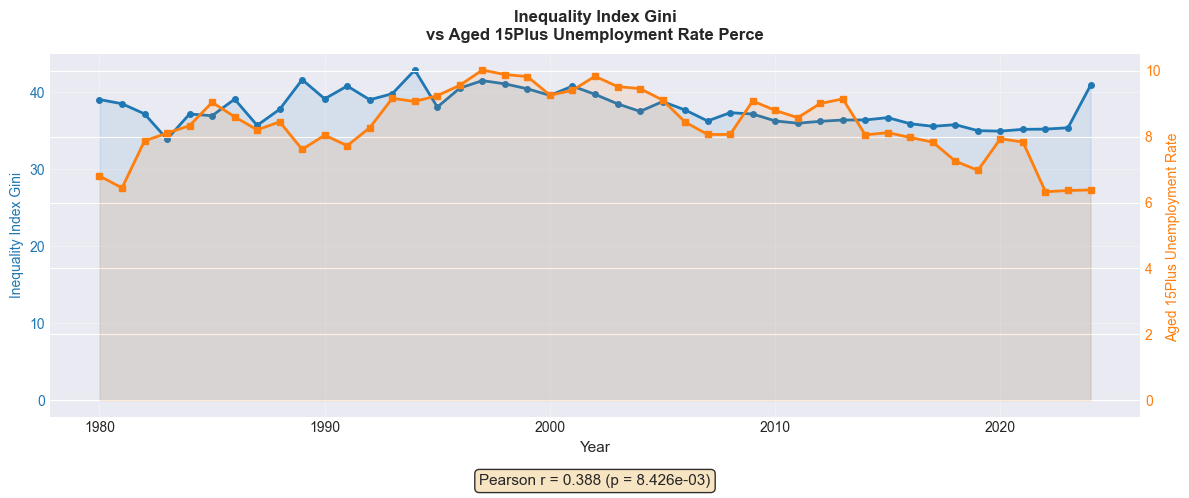

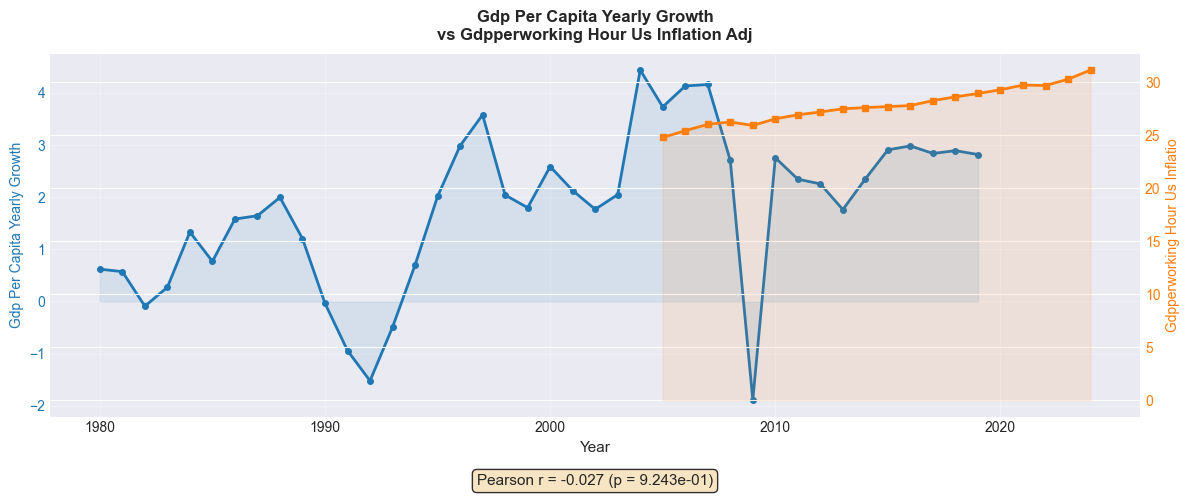

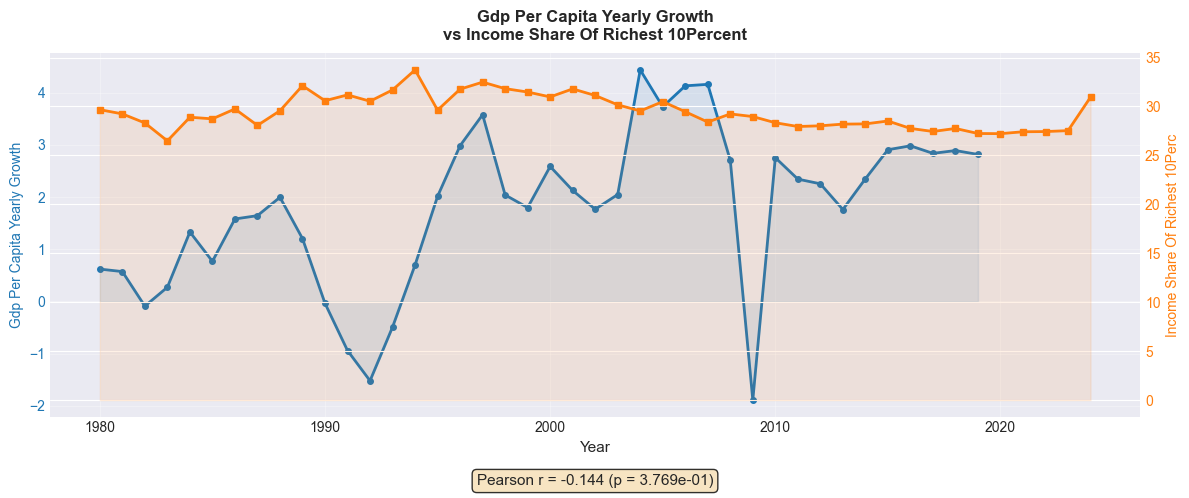

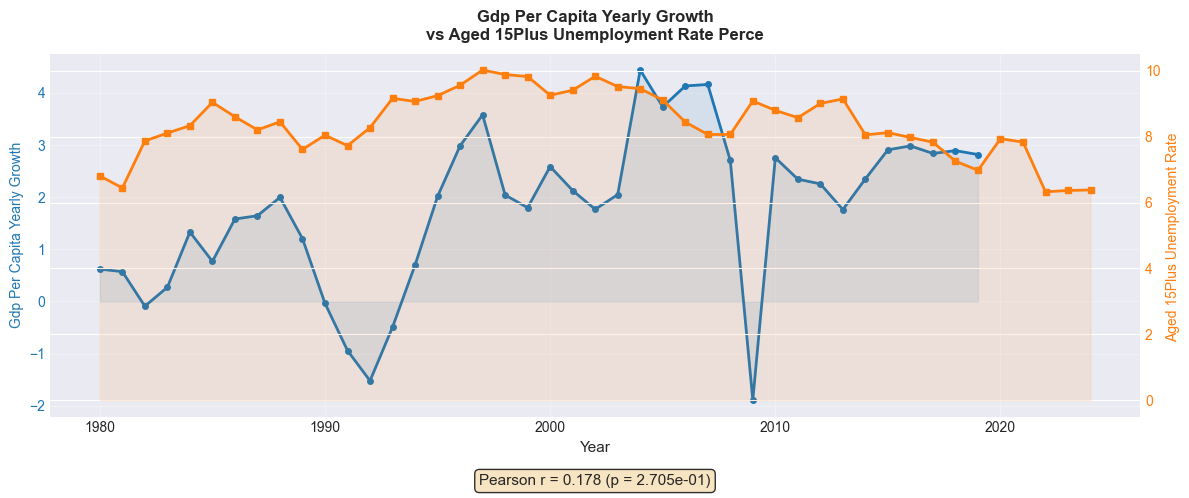

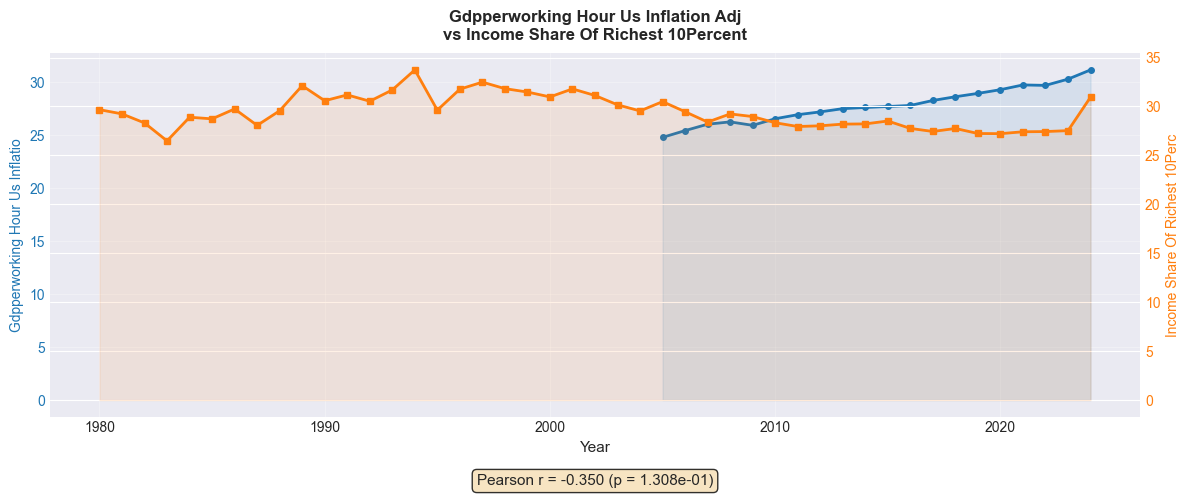

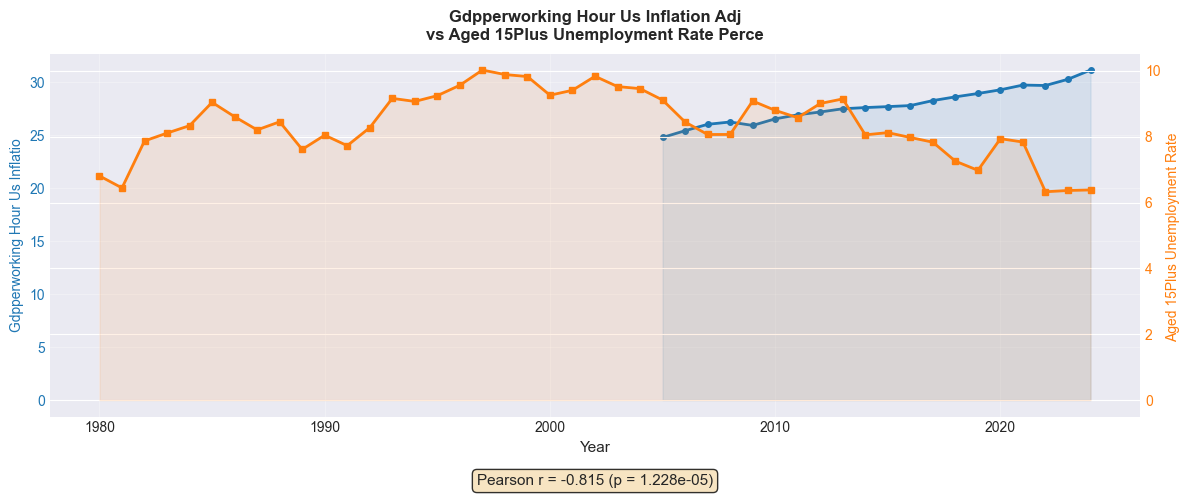

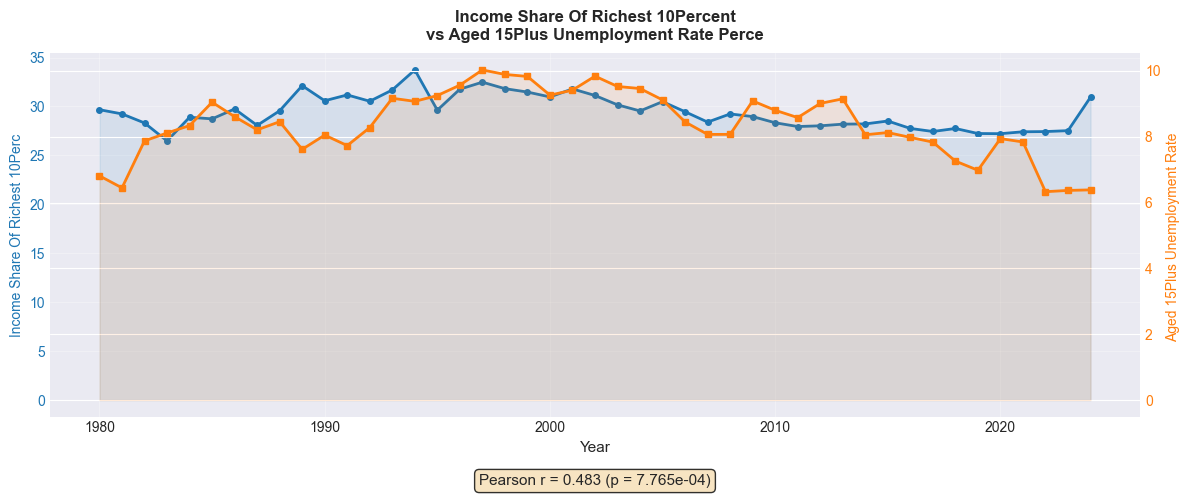

In [23]:
import os
from itertools import combinations
def load_economic_datasets():
    """Load all datasets from the Economic folder."""
    economic_dir = Path('./data/gapminder/Economic')
    datasets = {}
    
    for file in economic_dir.glob('ddf--datapoints--*--by--geo--time.csv'):
        # Extract indicator name from filename
        parts = file.name.split('--')
        if len(parts) >= 3:
            indicator = parts[2]
            df = pd.read_csv(file)
            datasets[indicator] = df
    
    return datasets
def create_dual_axis_plot(df1, df2, name1, name2, year_range=(1980, 2024)):
    """Create a dual-axis line graph comparing two datasets aggregated by year."""
    # Get indicator column names
    col1 = [c for c in df1.columns if c not in ['geo', 'time']][0]
    col2 = [c for c in df2.columns if c not in ['geo', 'time']][0]
    
    # Filter by year range
    df1_filtered = df1[(df1['time'] >= year_range[0]) & (df1['time'] <= year_range[1])]
    df2_filtered = df2[(df2['time'] >= year_range[0]) & (df2['time'] <= year_range[1])]
    
    # Aggregate by year (mean across all countries)
    agg1 = df1_filtered.groupby('time')[col1].mean().reset_index()
    agg2 = df2_filtered.groupby('time')[col2].mean().reset_index()
    
    if len(agg1) == 0 or len(agg2) == 0:
        return None
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # First axis
    color1 = '#1f77b4'
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel(name1.replace('_', ' ').title()[:30], color=color1, fontsize=10)
    ax1.plot(agg1['time'], agg1[col1], color=color1, linewidth=2, marker='o', markersize=4, label=name1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.fill_between(agg1['time'], agg1[col1], alpha=0.1, color=color1)
    
    # Second axis
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel(name2.replace('_', ' ').title()[:30], color=color2, fontsize=10)
    ax2.plot(agg2['time'], agg2[col2], color=color2, linewidth=2, marker='s', markersize=4, label=name2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.fill_between(agg2['time'], agg2[col2], alpha=0.1, color=color2)
    
    # Economic correlation
    merged = agg1.merge(agg2, on='time', how='inner')
    if len(merged) > 2:
        corr, p_val = pearsonr(merged[col1], merged[col2])
        corr_text = f'Pearson r = {corr:.3f} (p = {p_val:.3e})'
        fig.text(0.5, 0.02, corr_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Title
    title1 = name1.replace('_', ' ').title()[:35]
    title2 = name2.replace('_', ' ').title()[:35]
    plt.title(f'{title1}\nvs {title2}', fontsize=12, fontweight='bold', pad=10)
    
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    ax1.grid(True, alpha=0.3)
    
    return fig
# Load all Economic datasets
print('Loading Economic datasets...')
economic_datasets = load_economic_datasets()
print(f'Found {len(economic_datasets)} datasets in Economic folder:')
for name in economic_datasets.keys():
    print(f'  - {name}')
# Create dual-axis plots for all combinations
print('\n' + '='*70)
print('DUAL-AXIS LINE GRAPHS FOR ECONOMIC DATASETS')
print('='*70 + '\n')
dataset_names = list(economic_datasets.keys())
for name1, name2 in combinations(dataset_names, 2):
    fig = create_dual_axis_plot(
        economic_datasets[name1], 
        economic_datasets[name2],
        name1, 
        name2
    )
    if fig:
        plt.show()
        plt.close()
    else:
        print(f'Could not create plot for {name1} vs {name2} (insufficient data)')

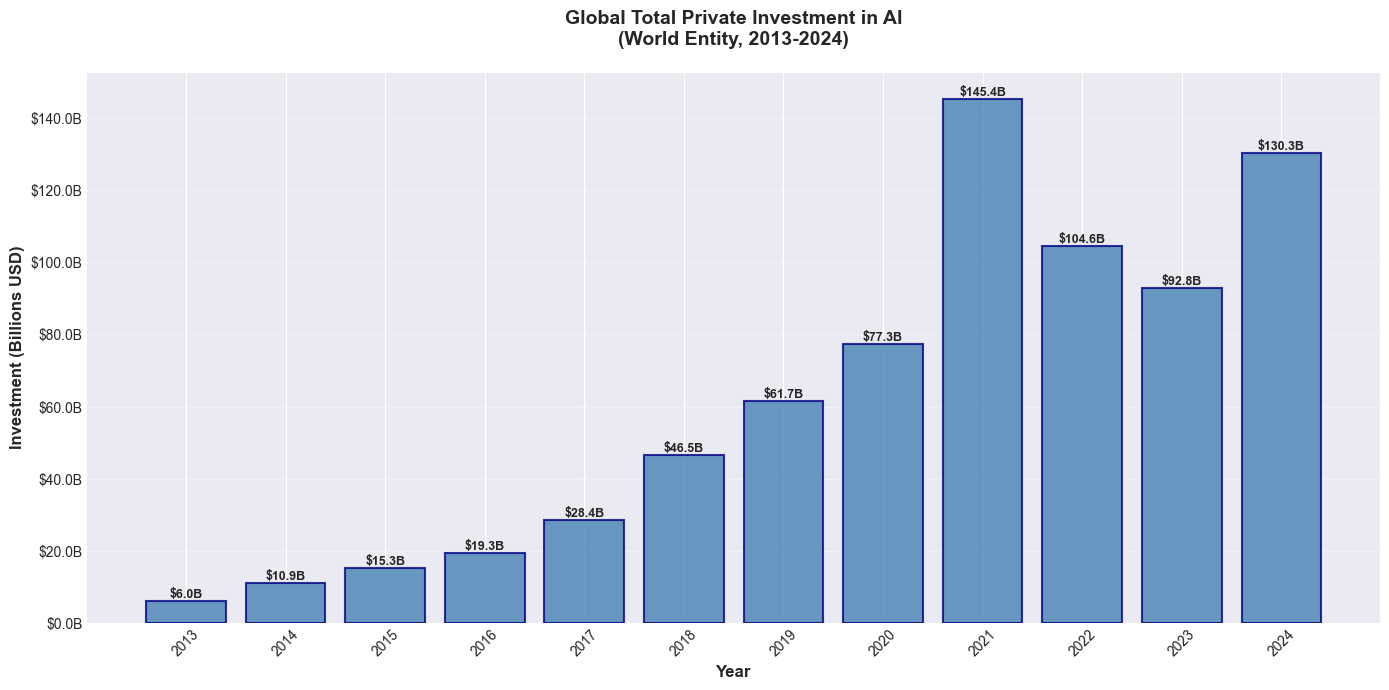


AI Investment Summary (World Entity)
Period: 2013-2024
Total Investment (2013-2024): $0.74 Trillion
Average Annual Investment: $61.54 Billion
Peak Year: 2021 ($145.40 Billion)
Lowest Year: 2013 ($6.01 Billion)



In [3]:
# Load and plot AI investment data for World entity
ai_investment_df = pd.read_csv('data/gapminder/AI_Technology/private-investment-in-artificial-intelligence.csv')

# Filter for World entity
world_data = ai_investment_df[ai_investment_df['Entity'] == 'World'].copy()
world_data = world_data.sort_values('Year')

# Create bar plot
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars
bars = ax.bar(world_data['Year'], world_data['Global total private investment in AI'], 
              color='steelblue', edgecolor='navy', linewidth=1.5, alpha=0.8)

# Format y-axis to show values in billions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B'))

# Labels and title
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Investment (Billions USD)', fontsize=12, fontweight='bold')
ax.set_title('Global Total Private Investment in AI\n(World Entity, 2013-2024)', 
             fontsize=14, fontweight='bold', pad=20)

# Add value labels on top of bars
for i, (year, value) in enumerate(zip(world_data['Year'], world_data['Global total private investment in AI'])):
    ax.text(year, value, f'${value/1e9:.1f}B', 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Set x-axis ticks to show all years
ax.set_xticks(world_data['Year'])
ax.tick_params(axis='x', rotation=45)

# Add grid
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"AI Investment Summary (World Entity)")
print(f"{'='*60}")
print(f"Period: {world_data['Year'].min()}-{world_data['Year'].max()}")
print(f"Total Investment (2013-2024): ${world_data['Global total private investment in AI'].sum()/1e12:.2f} Trillion")
print(f"Average Annual Investment: ${world_data['Global total private investment in AI'].mean()/1e9:.2f} Billion")
print(f"Peak Year: {world_data.loc[world_data['Global total private investment in AI'].idxmax(), 'Year']} "
      f"(${world_data['Global total private investment in AI'].max()/1e9:.2f} Billion)")
print(f"Lowest Year: {world_data.loc[world_data['Global total private investment in AI'].idxmin(), 'Year']} "
      f"(${world_data['Global total private investment in AI'].min()/1e9:.2f} Billion)")
print(f"{'='*60}\n")


Top 4 GDP per hour countries: ['lux', 'irl', 'nor', 'guy']
Bottom 4 GDP per hour countries: ['caf', 'lbr', 'prk', 'bdi']
Random 4 countries: ['mex', 'can', 'tkm', 'egy']


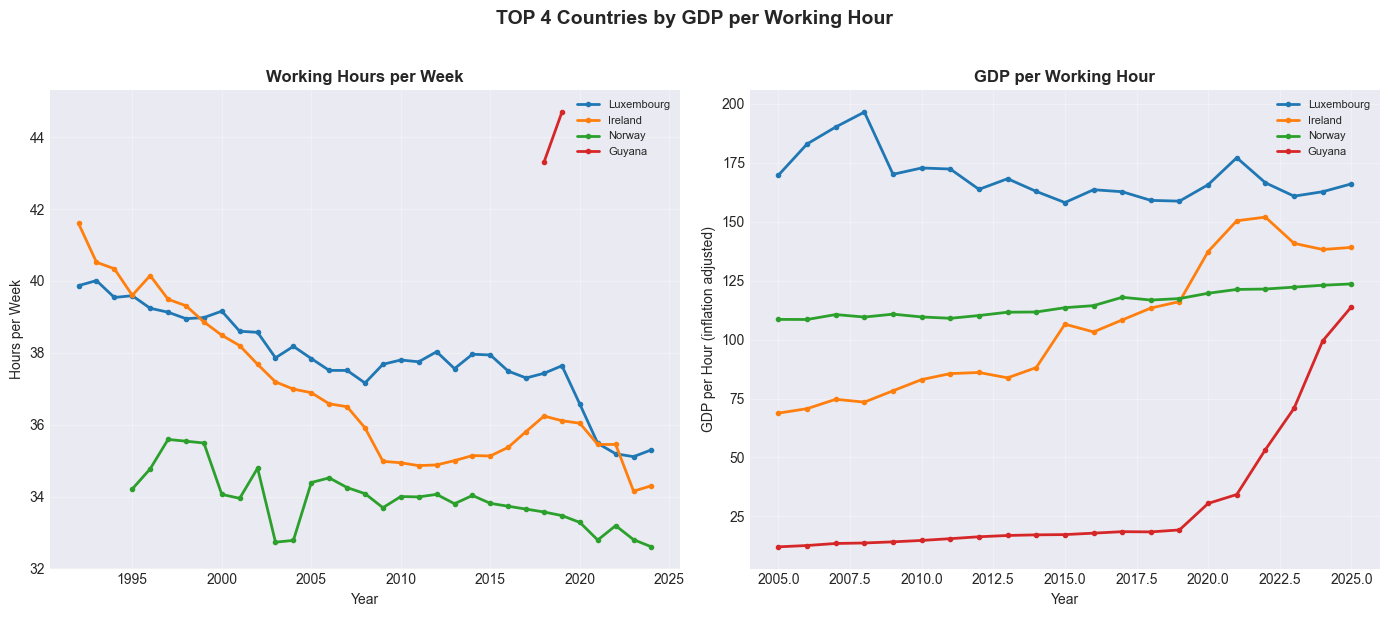

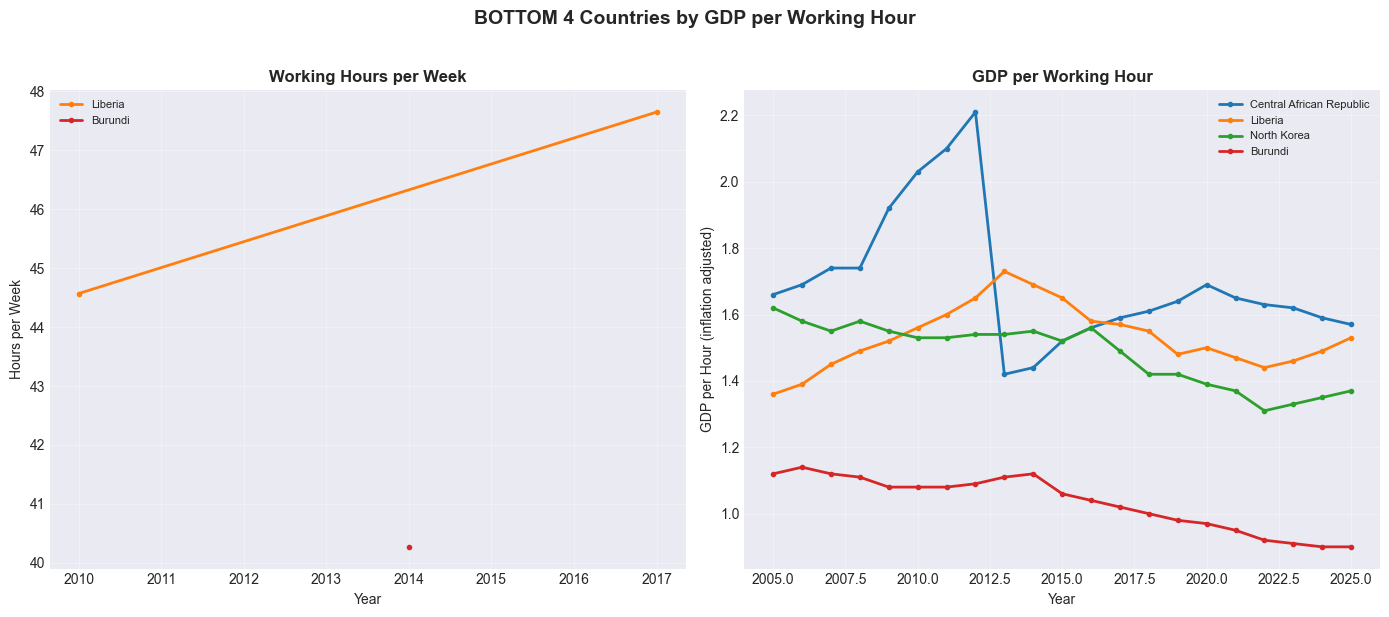

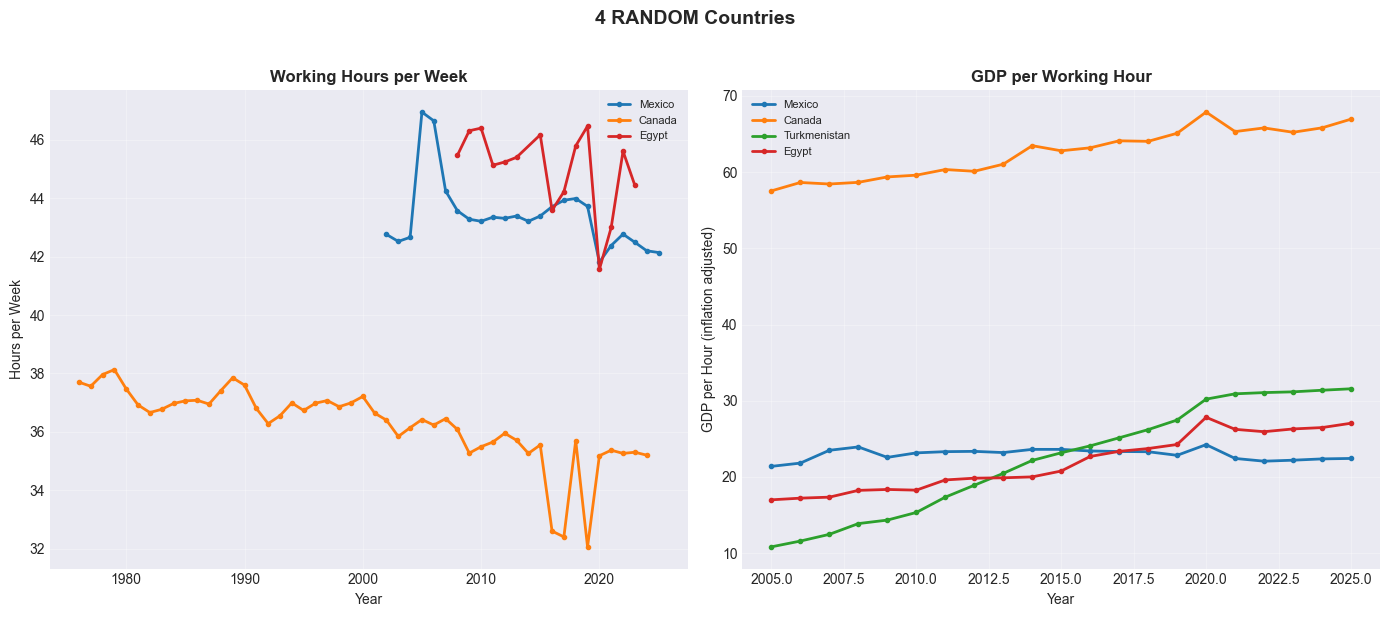

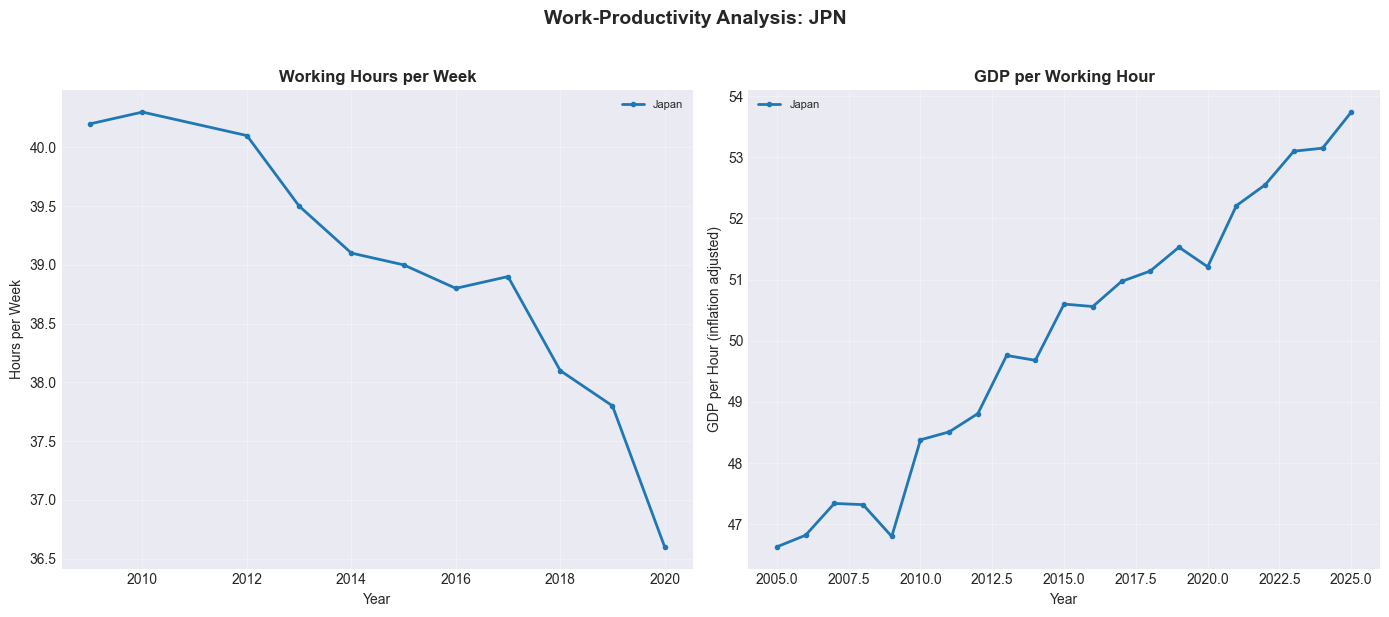

In [30]:
import random

def load_work_productivity_data():
    """Load working hours and GDP per working hour datasets."""
    base_dir = Path('data/gapminder')
    
    # Load working hours  
    hours_df = pd.read_csv(base_dir / 'Economic/ddf--datapoints--working_hours_per_week--by--geo--time.csv')
    
    # Load GDP per working hour (you may need to adjust the path/filename)
    gdp_hour_df = pd.read_csv(base_dir / 'Economic/ddf--datapoints--gdpperworking_hour_us_inflation_adjusted--by--geo--time.csv')
    
    # Load country names for display
    countries_df = pd.read_csv(base_dir / 'ddf--entities--geo--country.csv')[['country', 'name']]
    
    return hours_df, gdp_hour_df, countries_df

def plot_work_vs_productivity(country_codes, title="Working Hours vs GDP per Working Hour"):
    """
    Plot working hours vs GDP per working hour for specified countries.
    
    Args:
        country_codes: List of country codes (e.g., ['usa', 'deu', 'jpn'])
        title: Plot title
    """
    hours_df, gdp_df, countries_df = load_work_productivity_data()
    
    # Get column names
    hours_col = [c for c in hours_df.columns if c not in ['geo', 'time']][0]
    gdp_col = [c for c in gdp_df.columns if c not in ['geo', 'time']][0]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    colors = plt.cm.tab10(range(len(country_codes)))
    
    for i, code in enumerate(country_codes):
        # Filter data for this country
        hours_country = hours_df[hours_df['geo'] == code].sort_values('time')
        gdp_country = gdp_df[gdp_df['geo'] == code].sort_values('time')
        
        # Get country name
        name_row = countries_df[countries_df['country'] == code]
        name = name_row['name'].values[0] if len(name_row) > 0 else code.upper()
        
        if len(hours_country) > 0:
            axes[0].plot(hours_country['time'], hours_country[hours_col], 
                        label=name, linewidth=2, marker='o', markersize=3, color=colors[i])
        
        if len(gdp_country) > 0:
            axes[1].plot(gdp_country['time'], gdp_country[gdp_col], 
                        label=name, linewidth=2, marker='o', markersize=3, color=colors[i])
    
    axes[0].set_title('Working Hours per Week', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Hours per Week')
    axes[0].legend(loc='best', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('GDP per Working Hour', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('GDP per Hour (inflation adjusted)')
    axes[1].legend(loc='best', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_country(country_code):
    """
    Plot working hours vs GDP per working hour for a single country.
    
    Args:
        country_code: Country code (e.g., 'usa', 'deu', 'mex')
    """
    plot_work_vs_productivity([country_code], title=f"Work-Productivity Analysis: {country_code.upper()}")

def get_top_bottom_random_countries(n_each=4):
    """Get top N, bottom N, and N random countries by GDP."""
    hours_df, gdp_df, countries_df = load_work_productivity_data()
    gdp_col = [c for c in gdp_df.columns if c not in ['geo', 'time']][0]
    
    # Get latest GDP per country
    latest_gdp = gdp_df.groupby('geo')[gdp_col].last().reset_index()
    latest_gdp = latest_gdp.dropna().sort_values(gdp_col, ascending=False)
    
    top_n = latest_gdp.head(n_each)['geo'].tolist()
    bottom_n = latest_gdp.tail(n_each)['geo'].tolist()
    
    # Random from the middle
    middle = latest_gdp.iloc[n_each:-n_each]
    random_n = middle.sample(n=min(n_each, len(middle)))['geo'].tolist()
    
    return top_n, bottom_n, random_n

# === RUN THE ANALYSIS ===

# Get country groups
top_4, bottom_4, random_4 = get_top_bottom_random_countries(4)

print("Top 4 GDP per hour countries:", top_4)
print("Bottom 4 GDP per hour countries:", bottom_4)
print("Random 4 countries:", random_4)

# Plot each group
plot_work_vs_productivity(top_4, title="TOP 4 Countries by GDP per Working Hour")
plot_work_vs_productivity(bottom_4, title="BOTTOM 4 Countries by GDP per Working Hour")
plot_work_vs_productivity(random_4, title="4 RANDOM Countries")

# === PERSONALIZED LOOKUP ===
# Use this function to check any specific country:
# plot_country('mex')  # Mexico
# plot_country('esp')  # Spain
# plot_country('usa')  # USA
plot_country('jpn')  # Japan

## Environmental

Loading Environmental datasets...
Found 9 datasets in Environmental folder:
  - at_least_basic_water_source_overall_access_percent
  - energy_use_per_person
  - energy_production_total
  - electricity_use_per_person
  - coal_consumption_total
  - gdp_per_capita_yearly_growth
  - cumulative_co2_emissions_tonnes
  - municipal_water_withdrawal_percent_of_total
  - electricity_generation_total

DUAL-AXIS LINE GRAPHS FOR ENVIRONMENTAL DATASETS



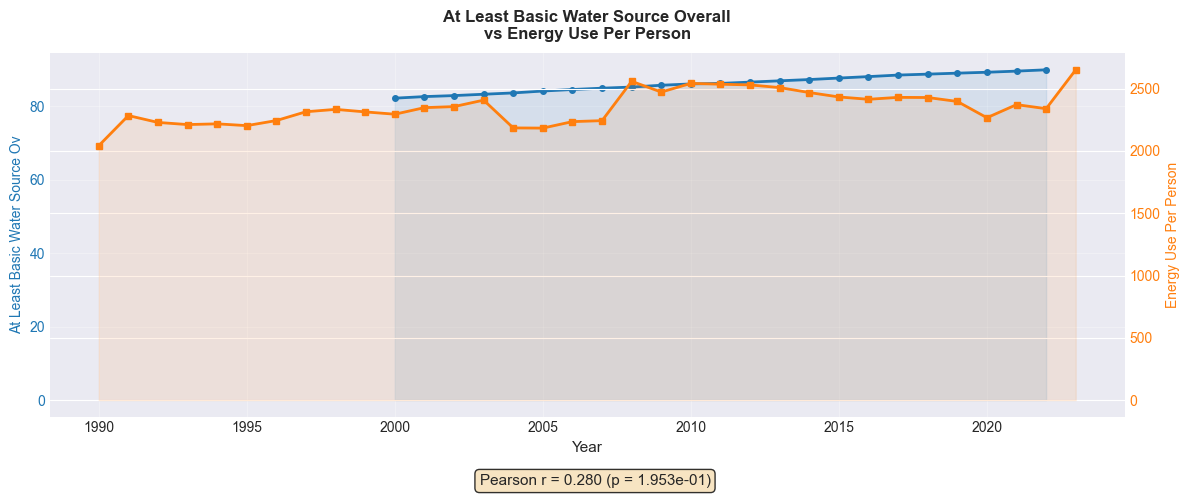

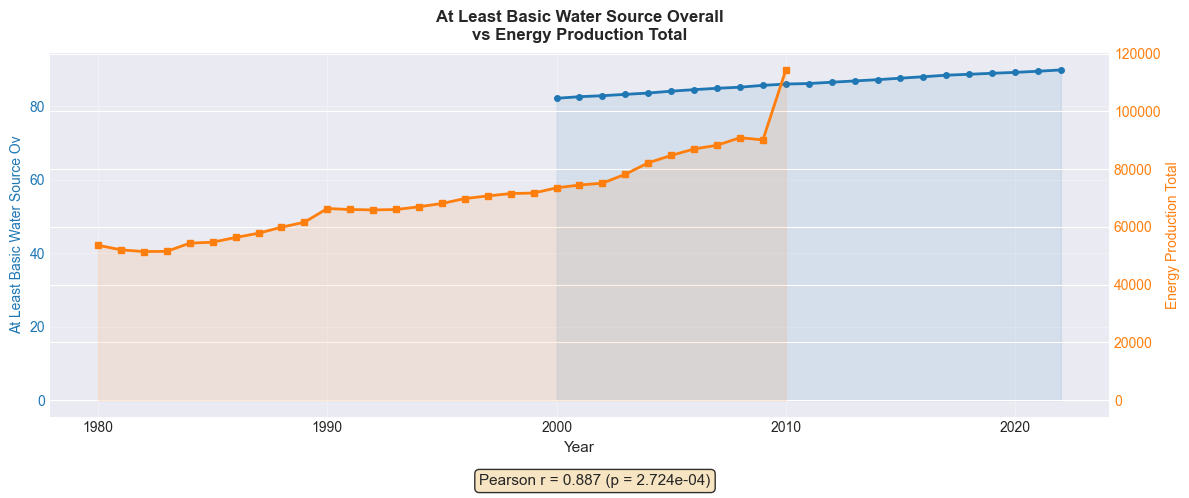

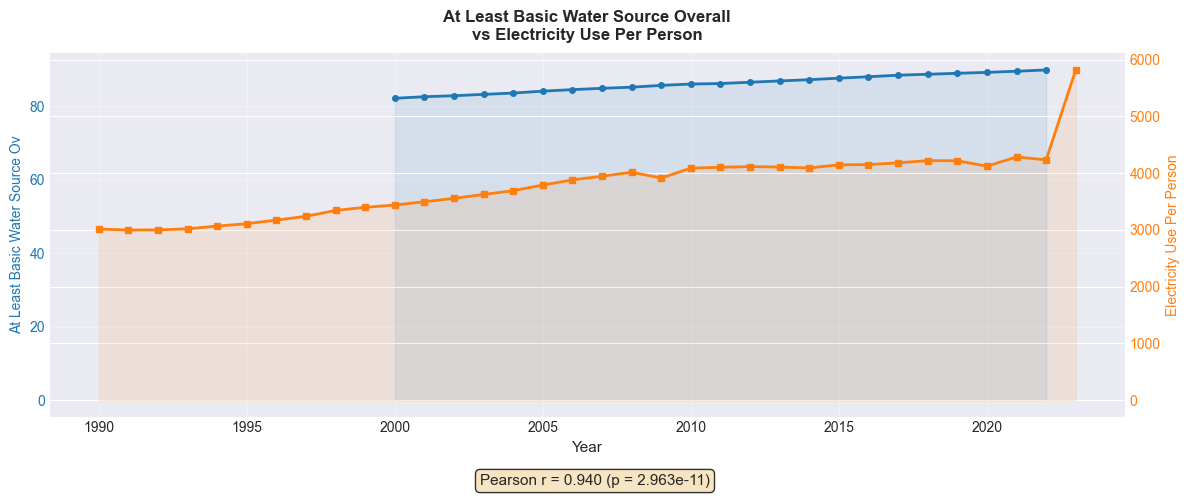

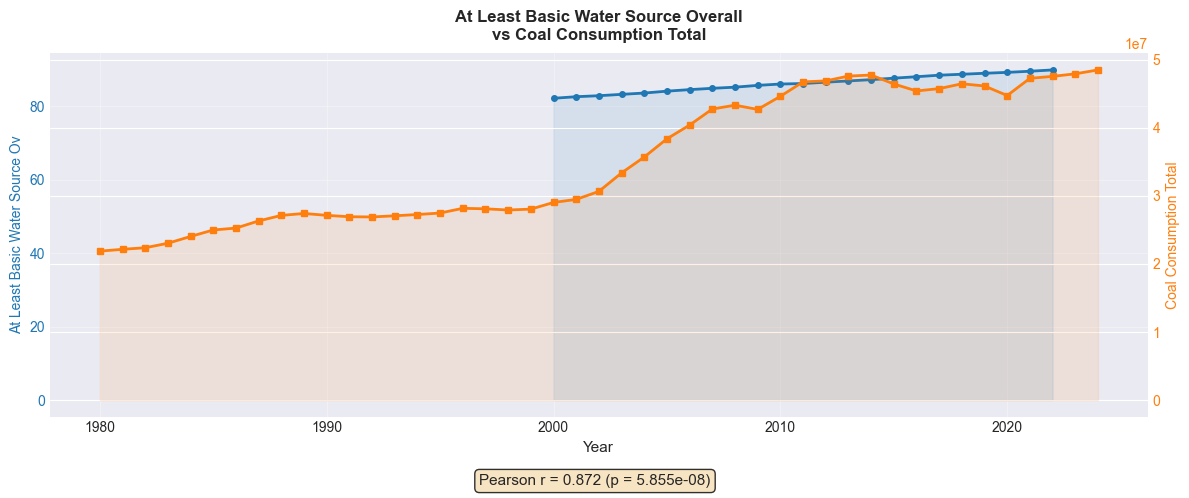

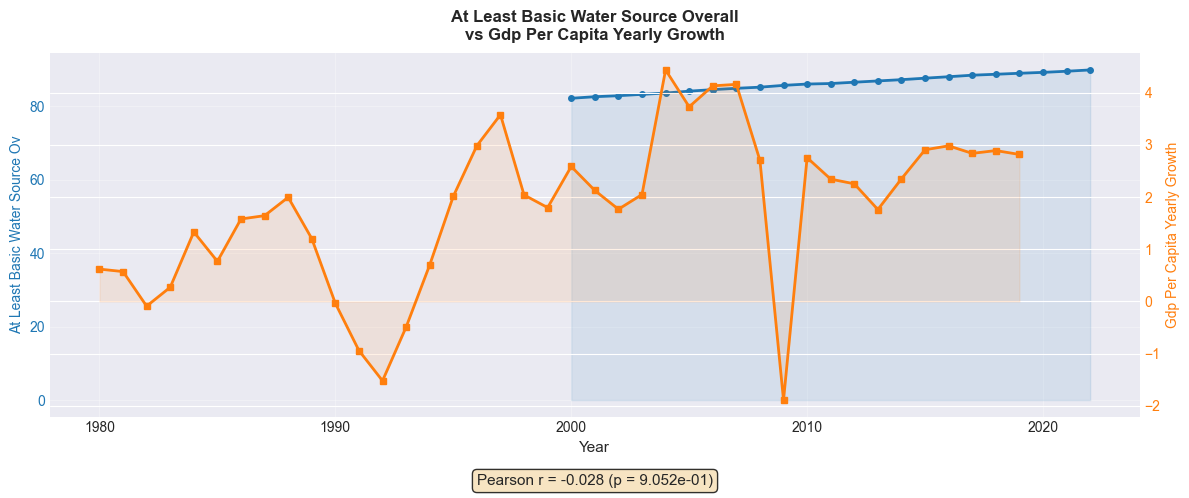

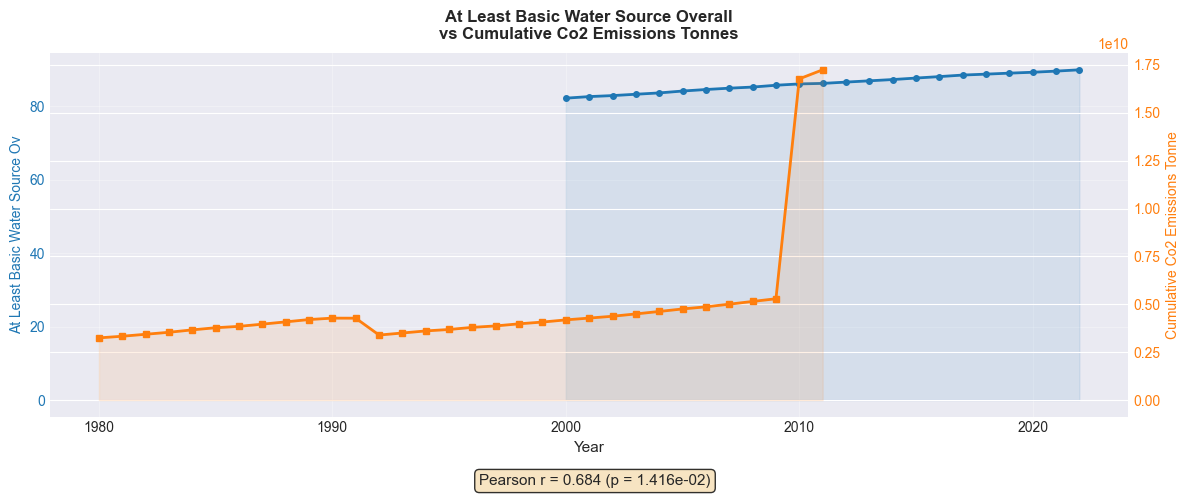

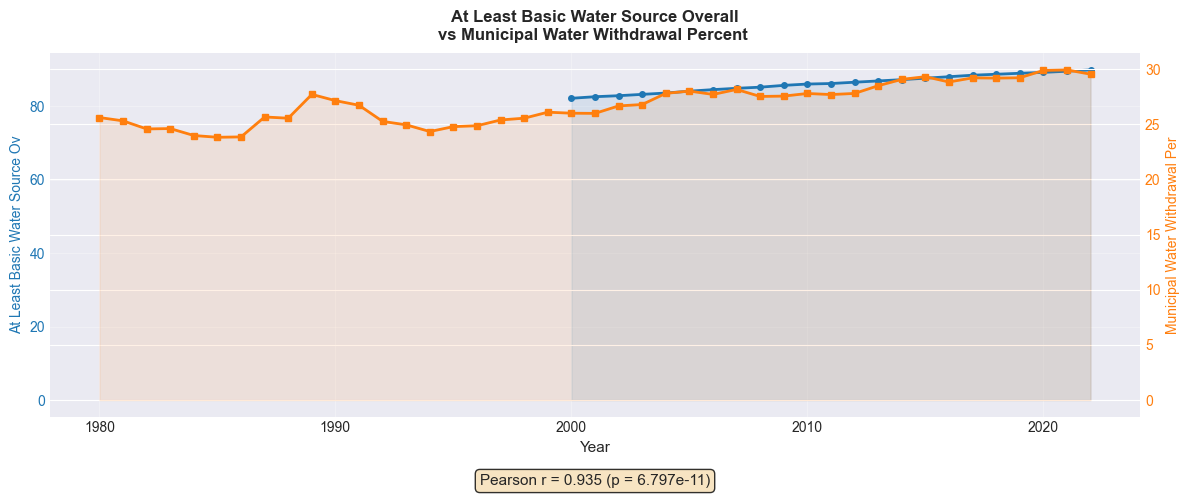

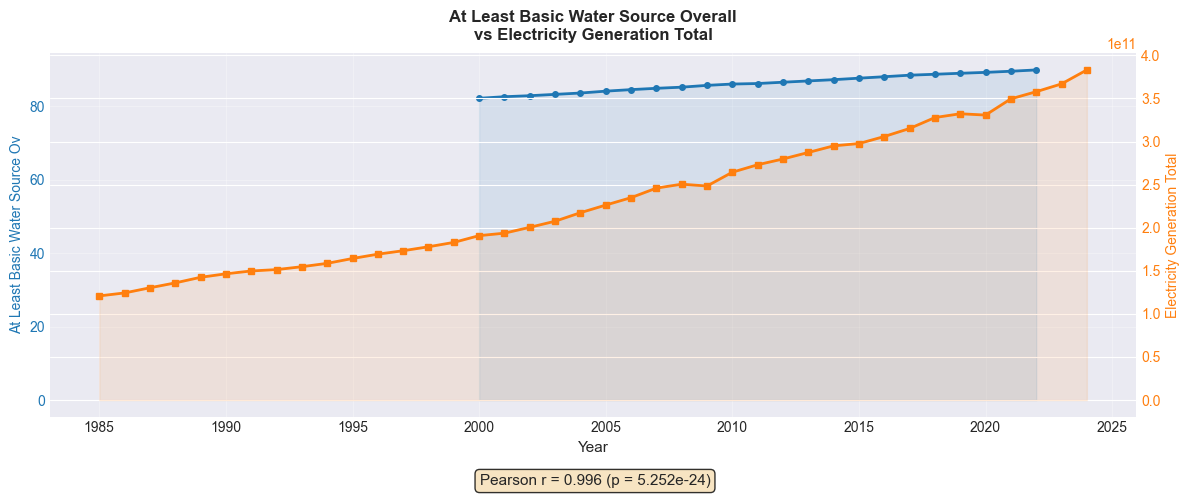

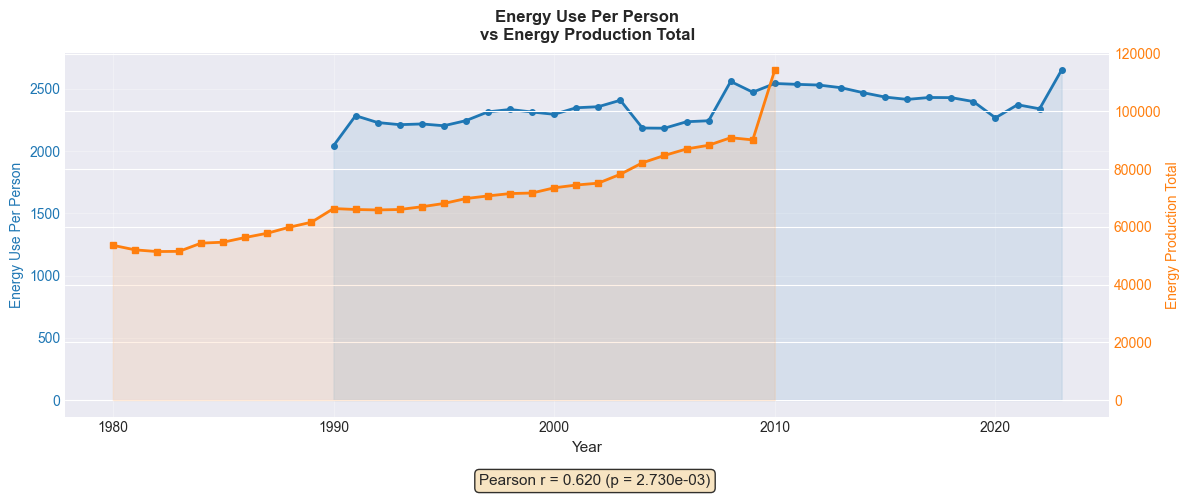

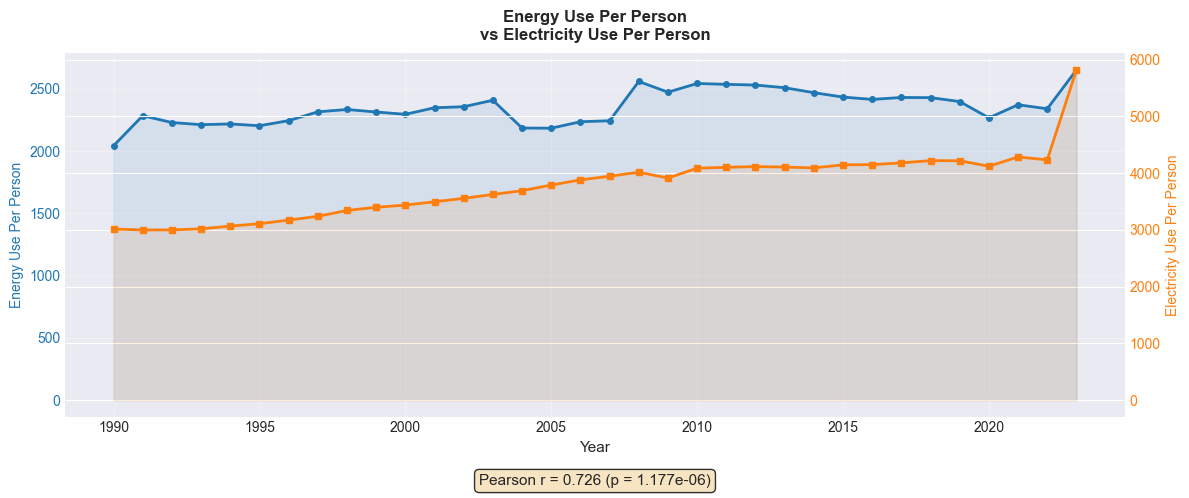

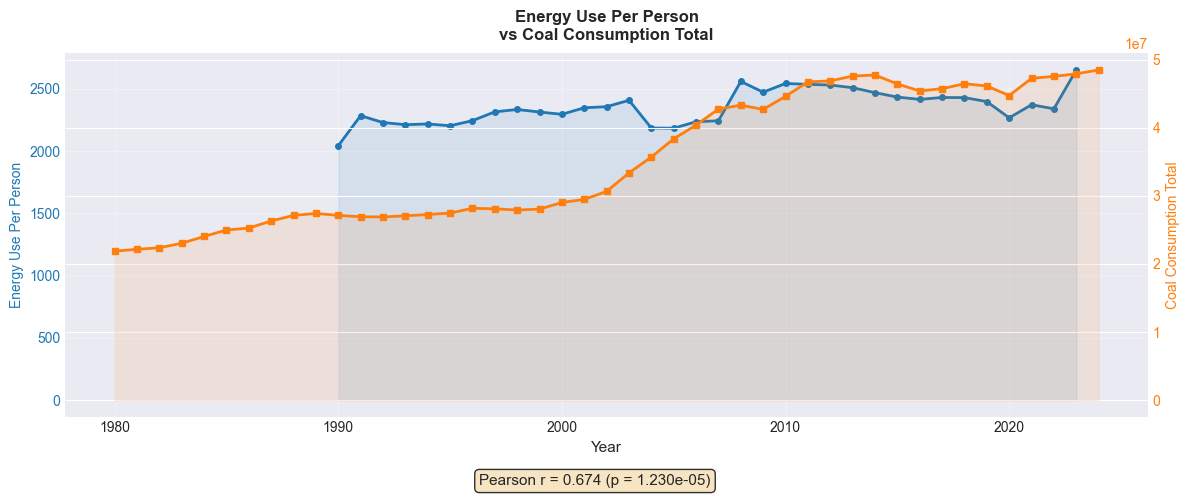

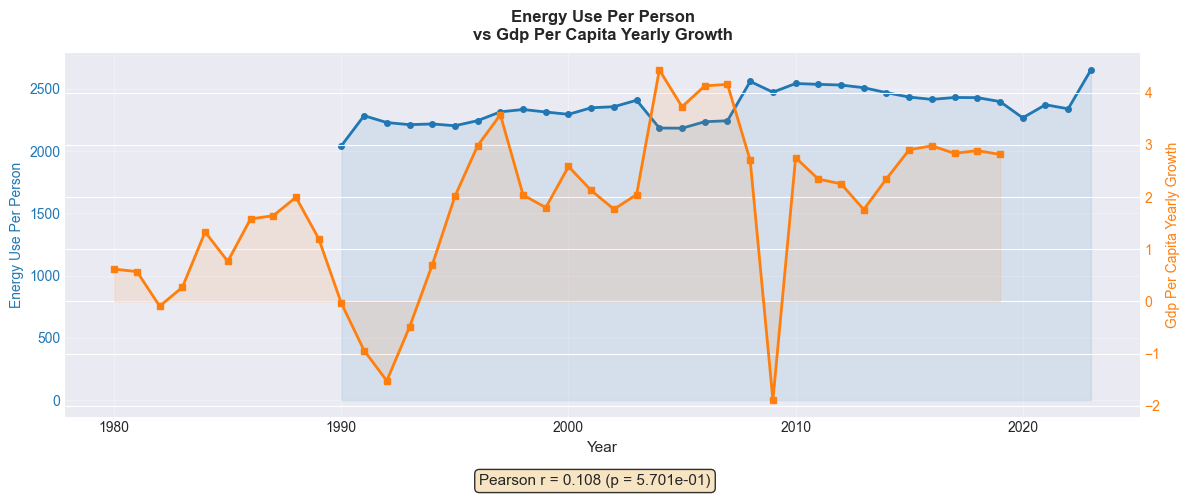

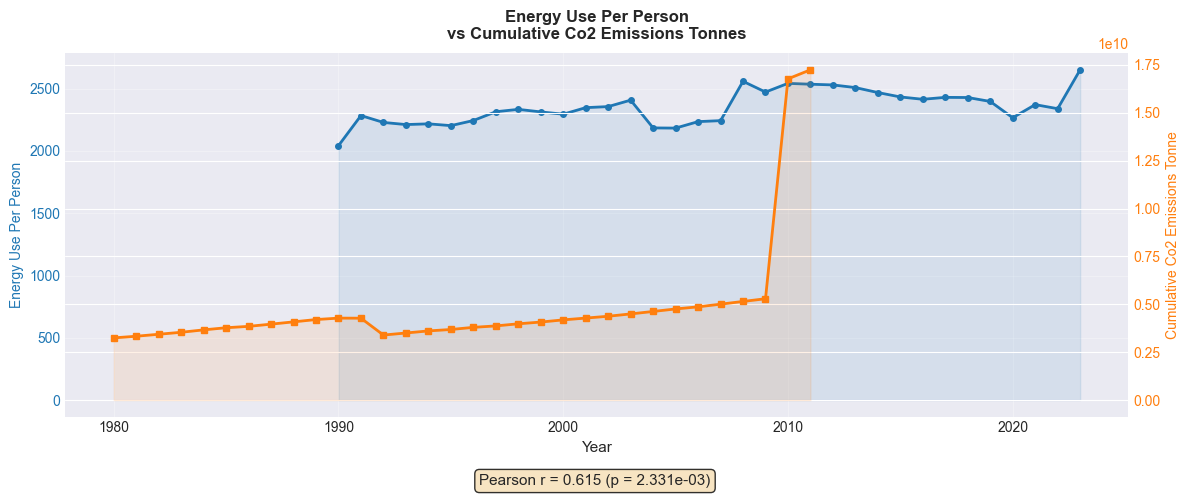

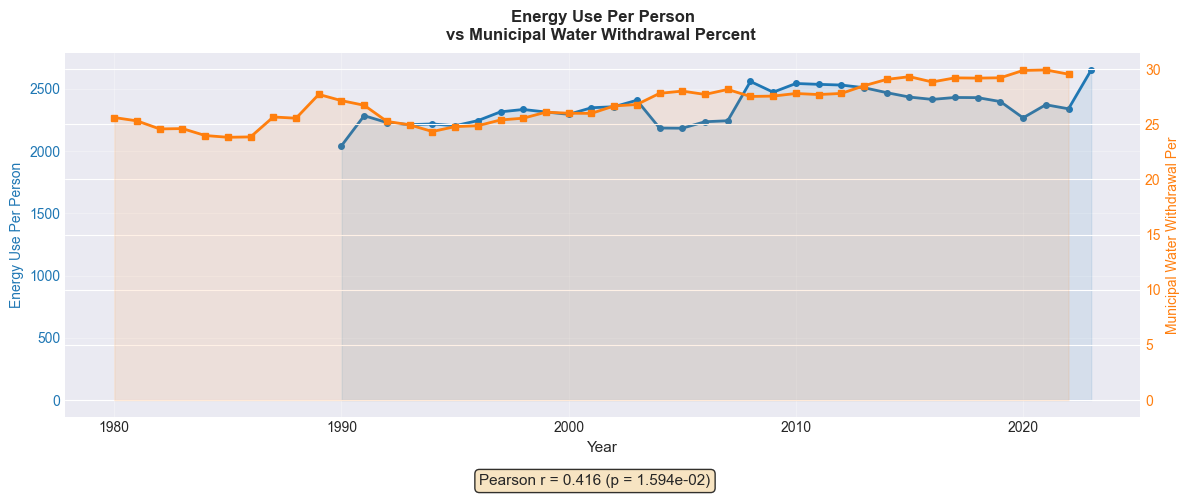

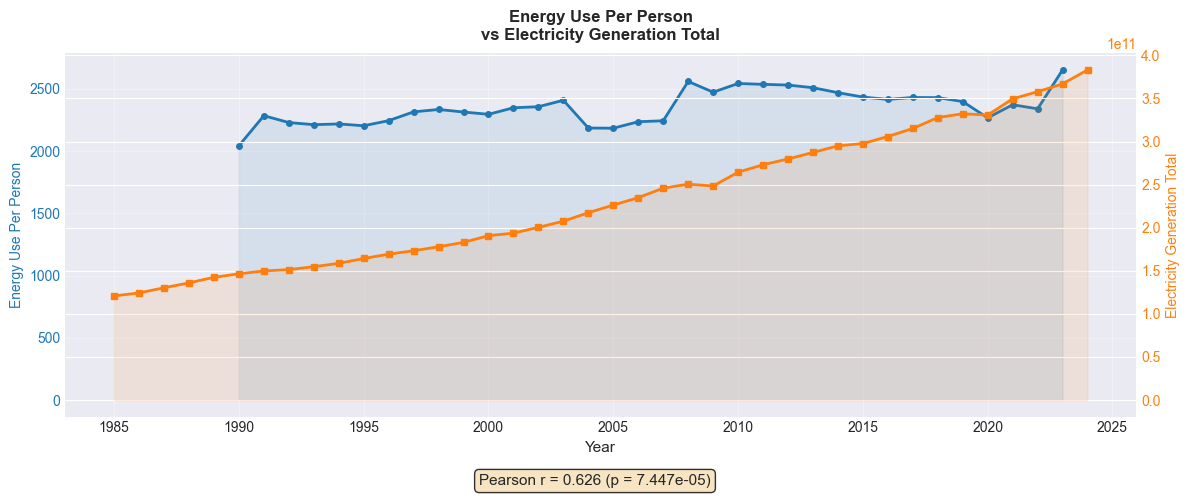

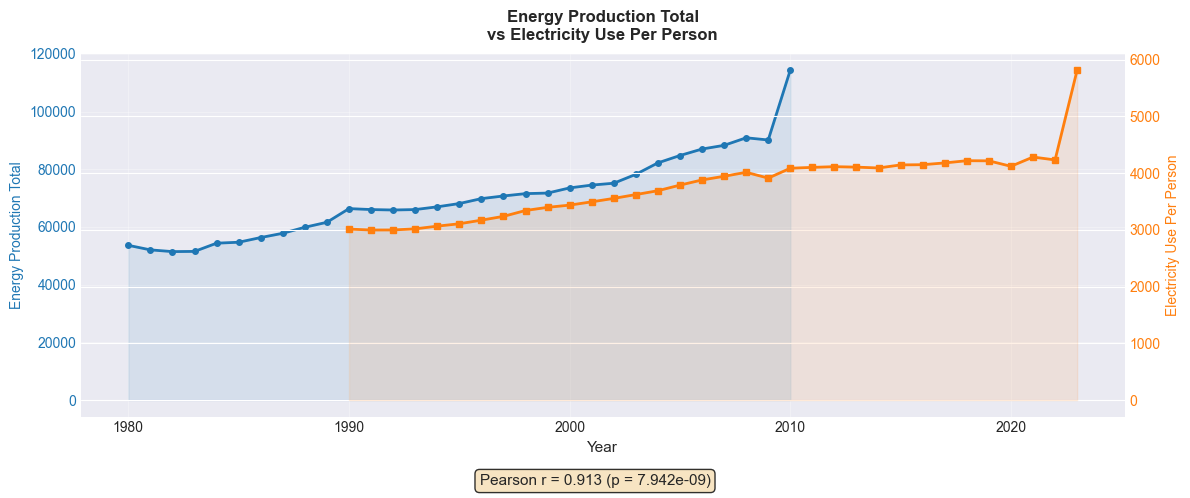

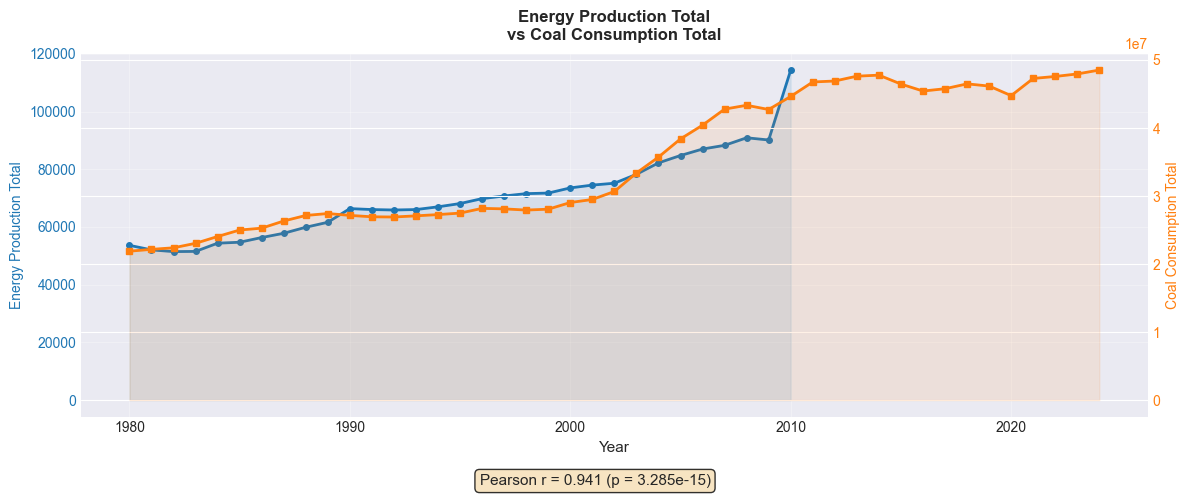

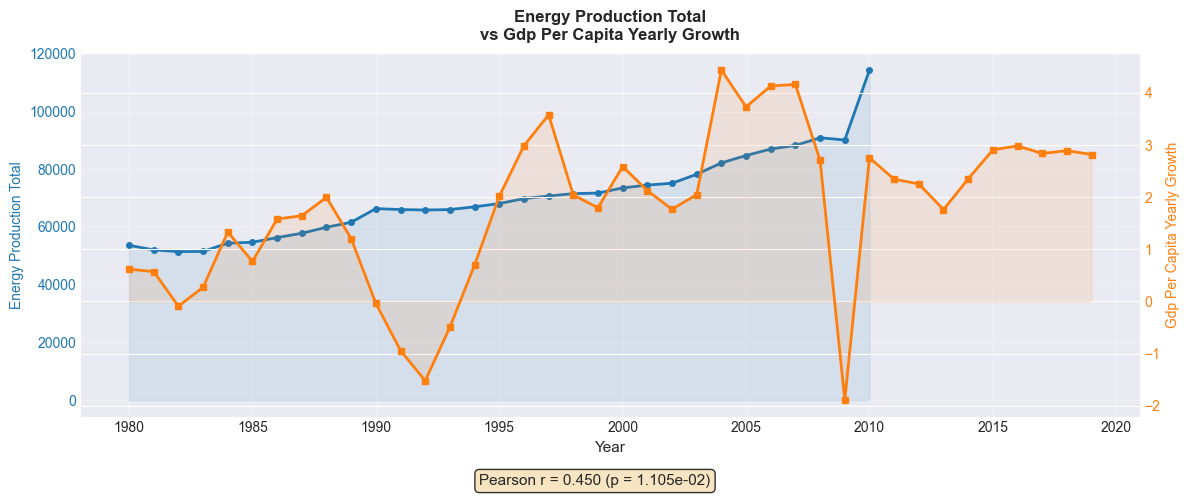

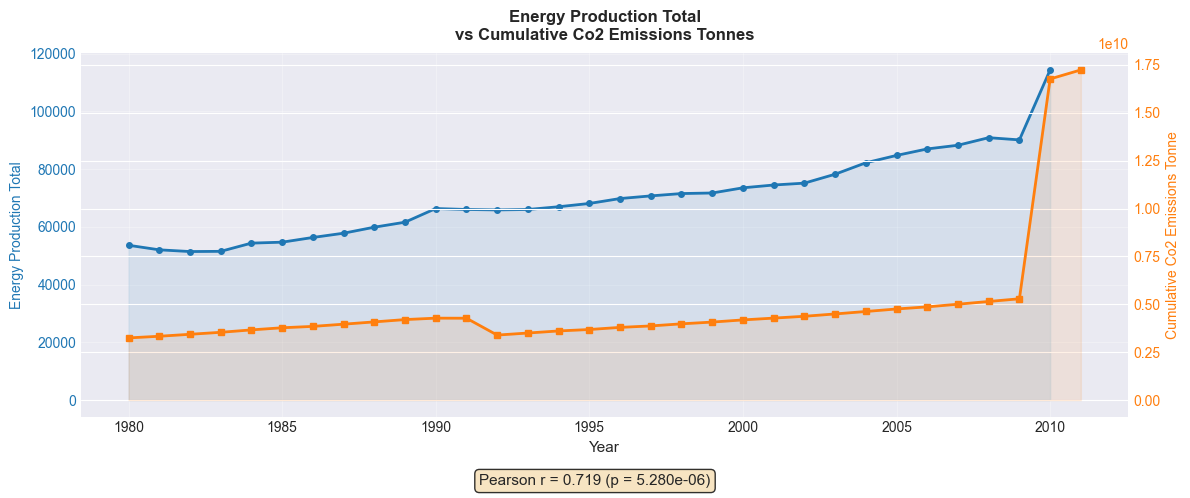

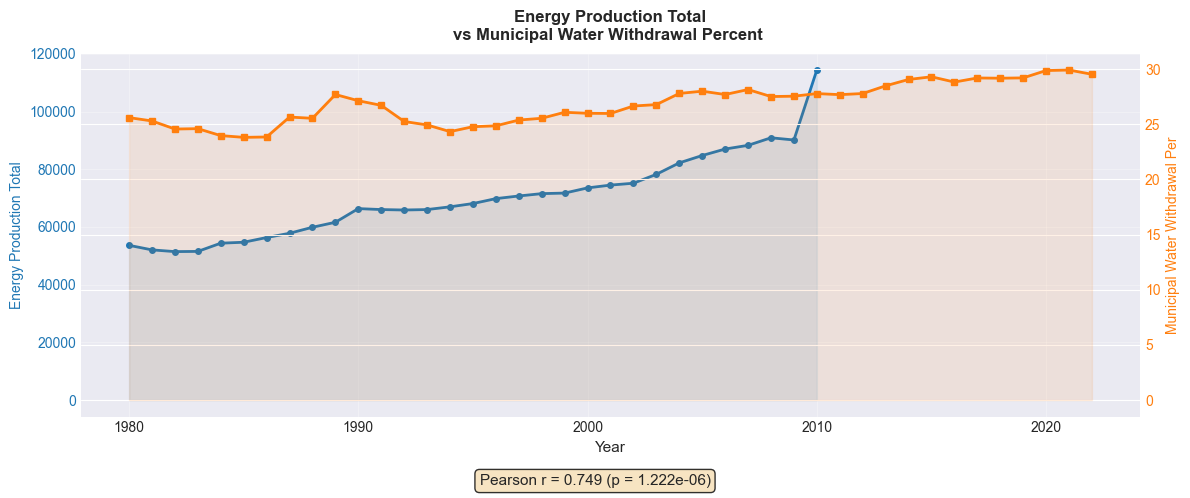

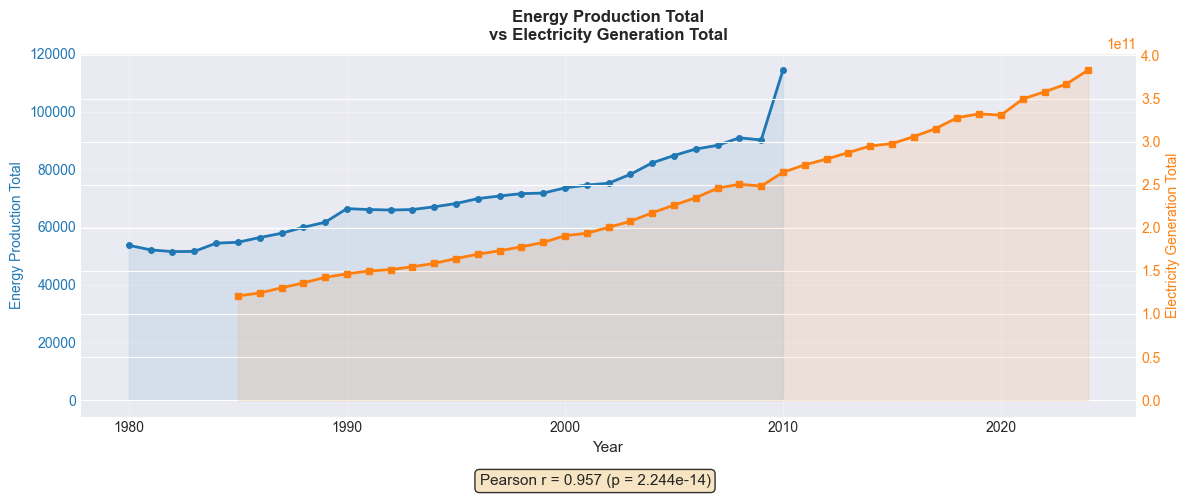

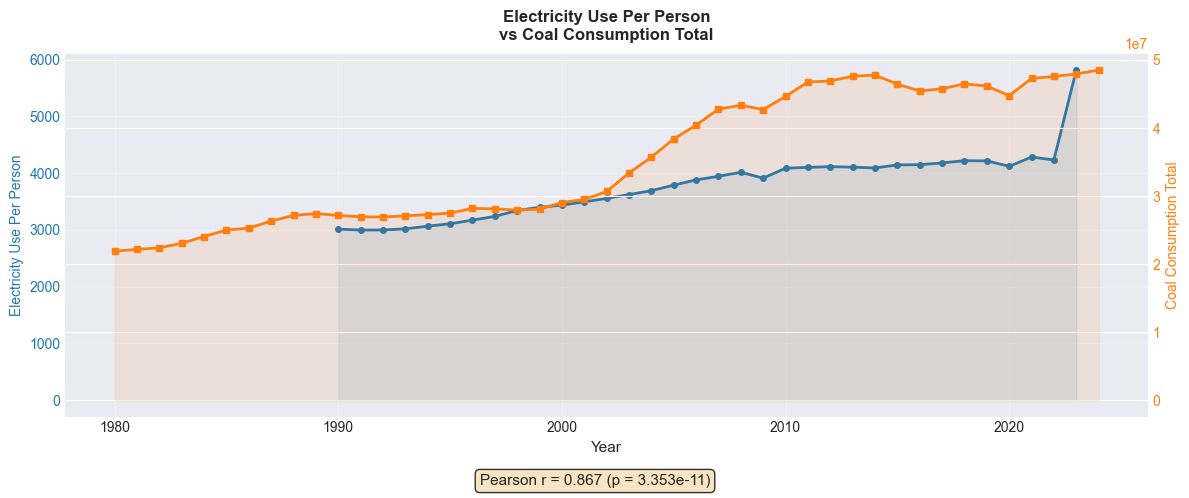

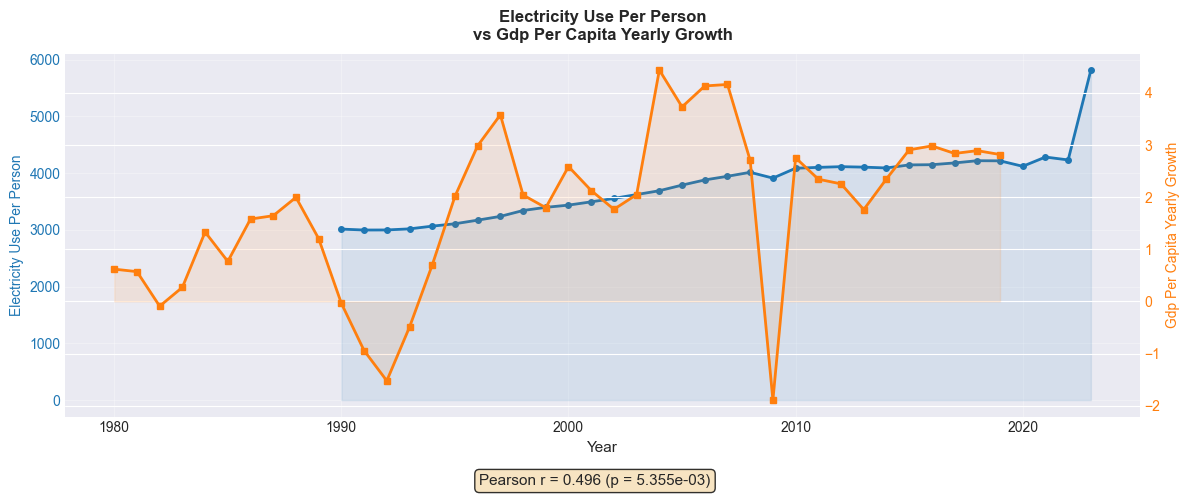

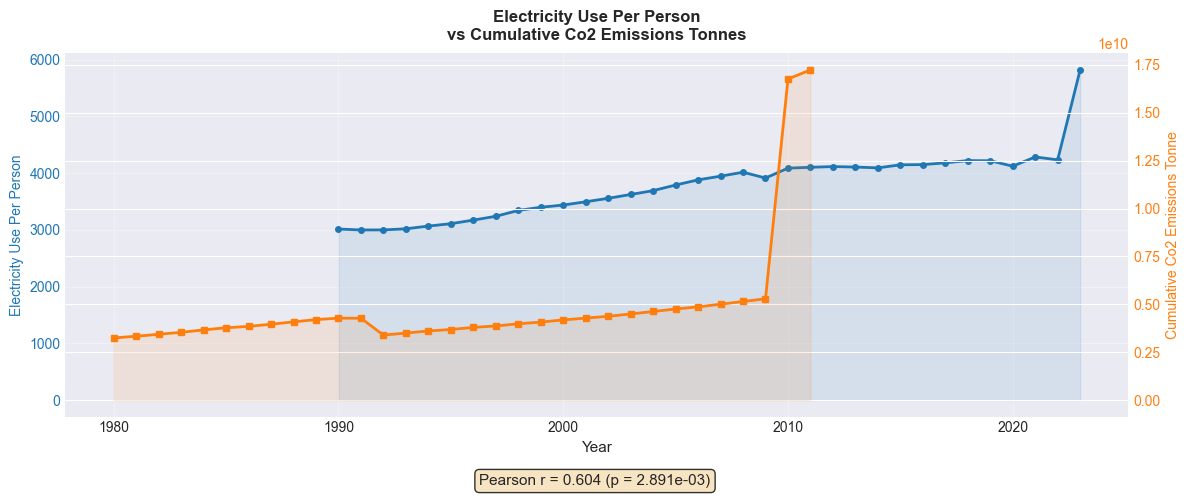

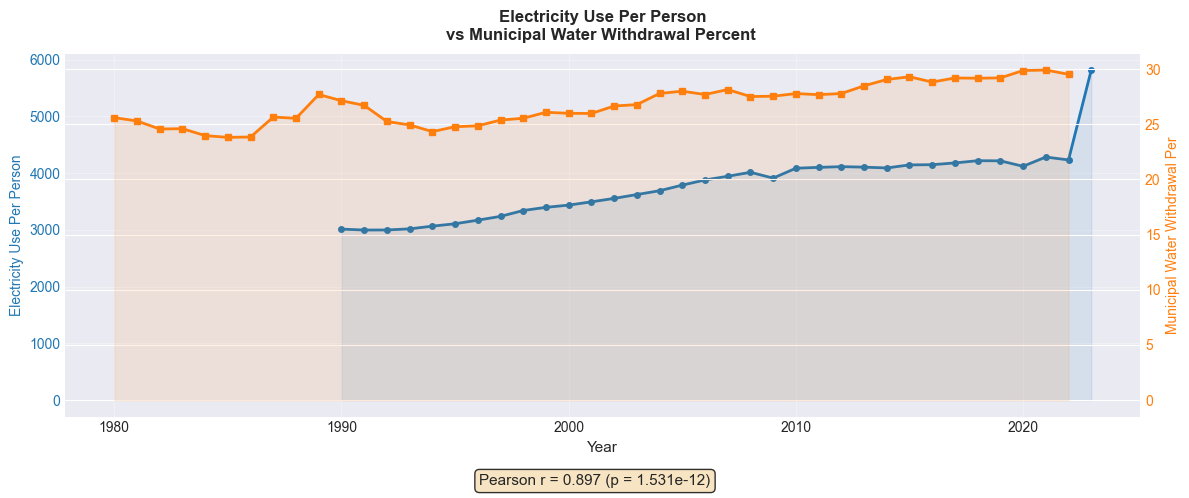

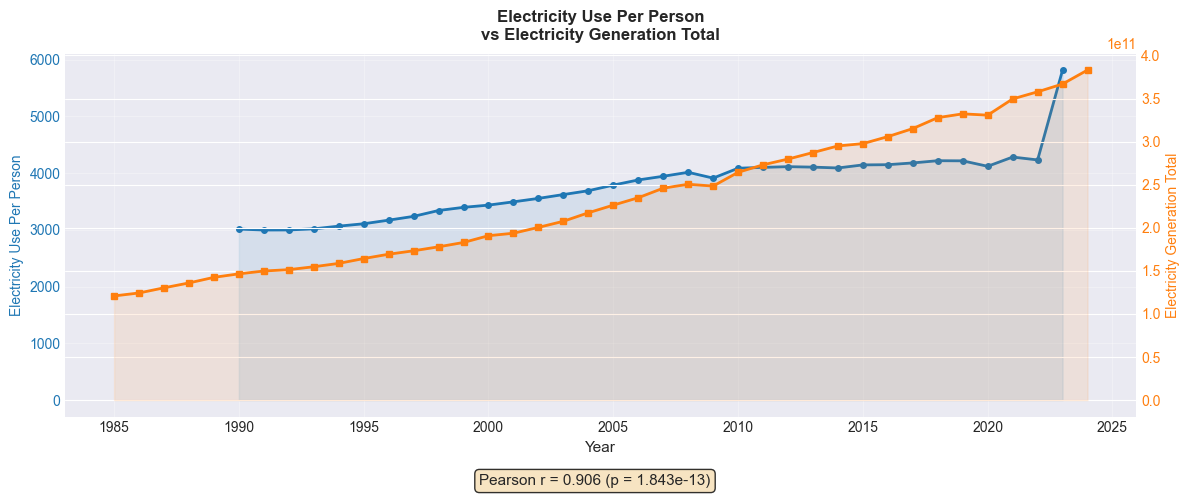

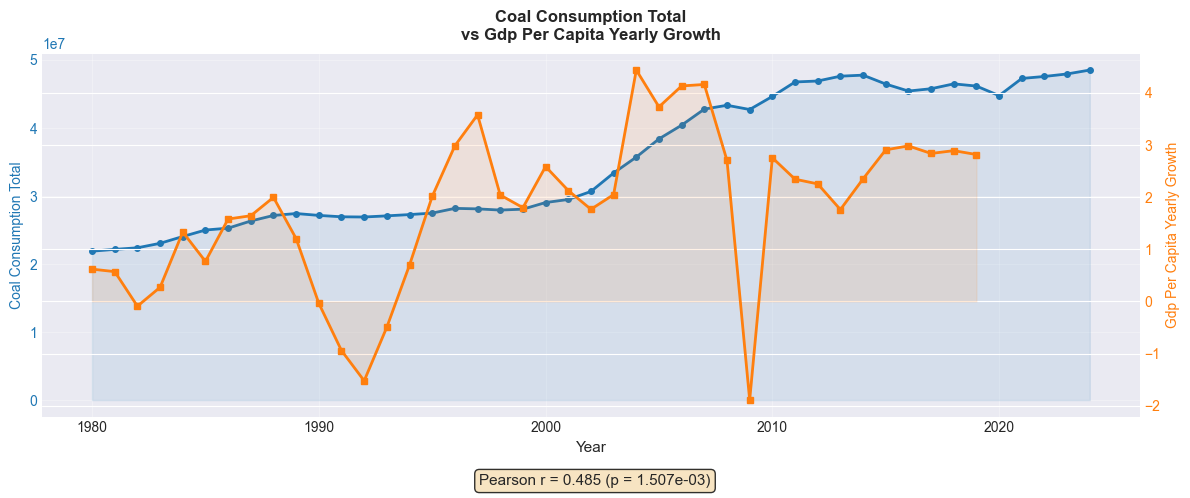

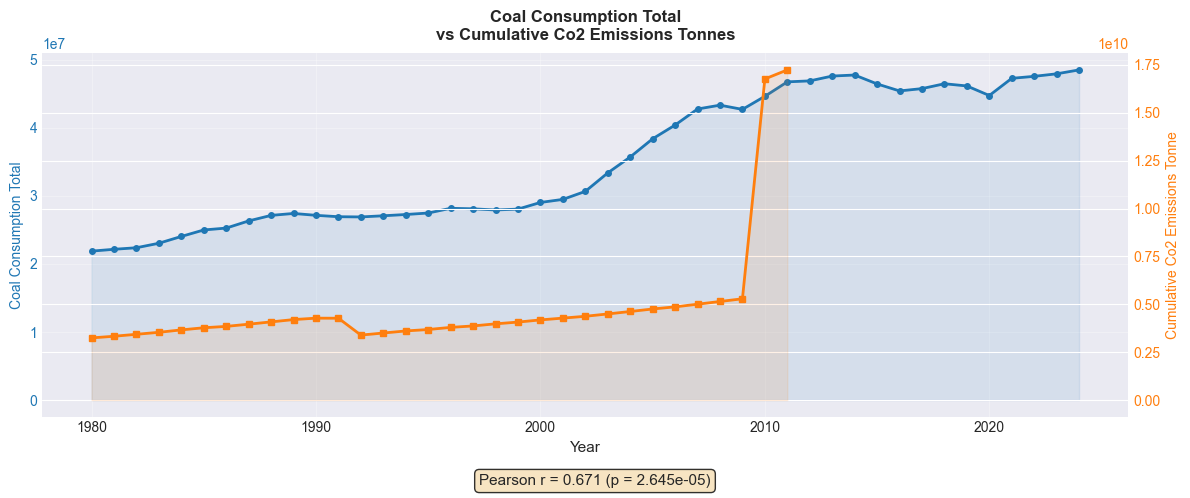

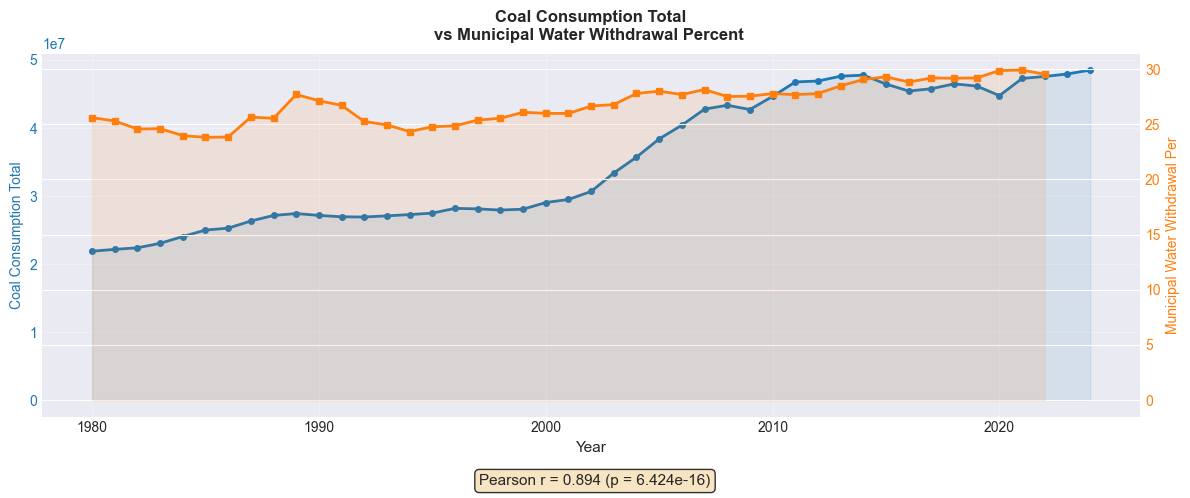

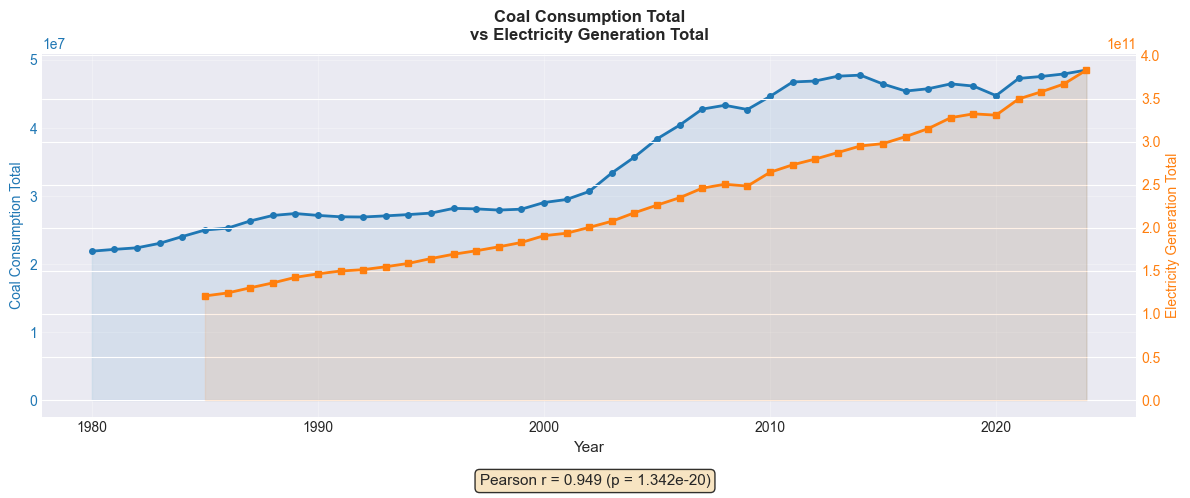

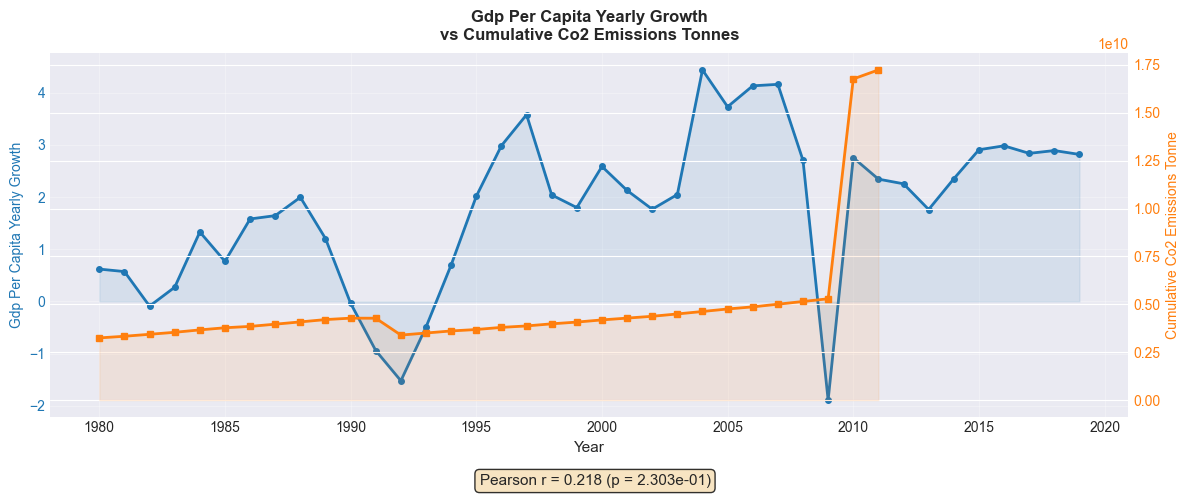

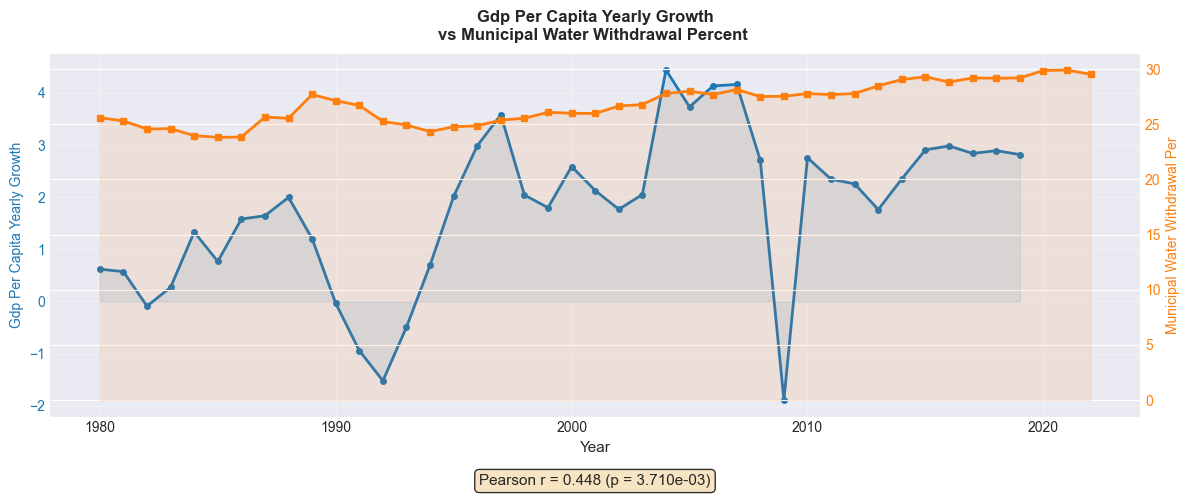

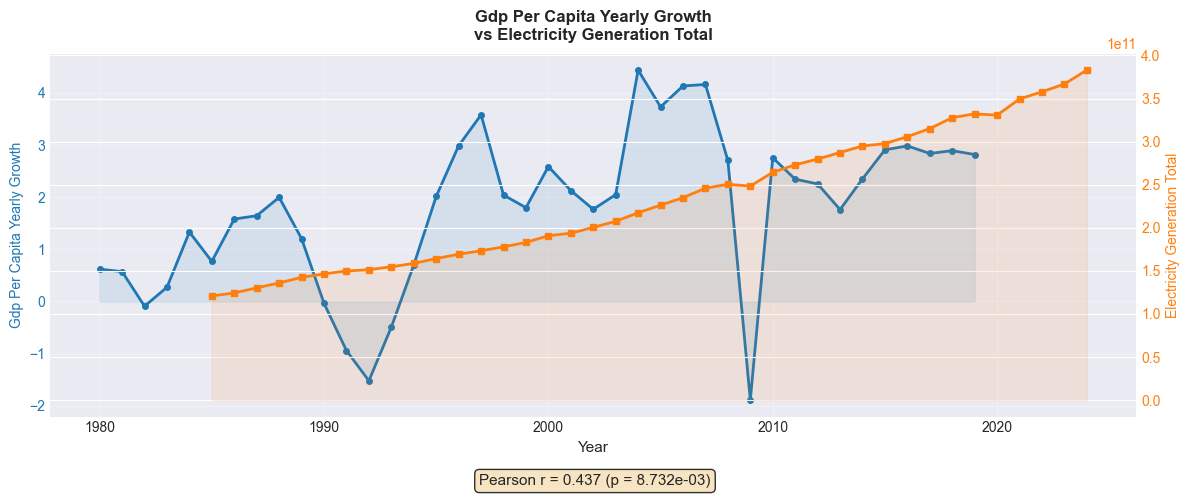

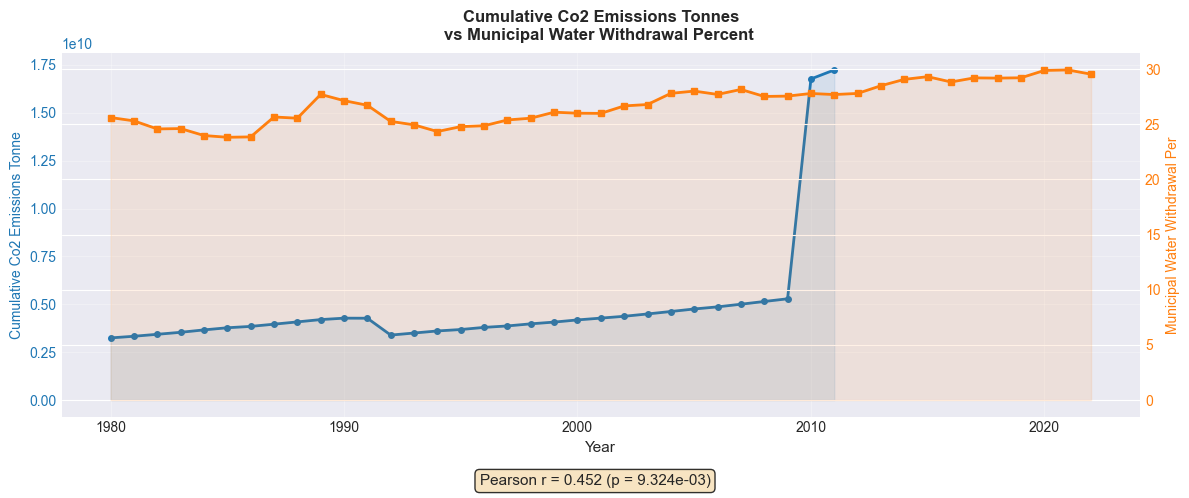

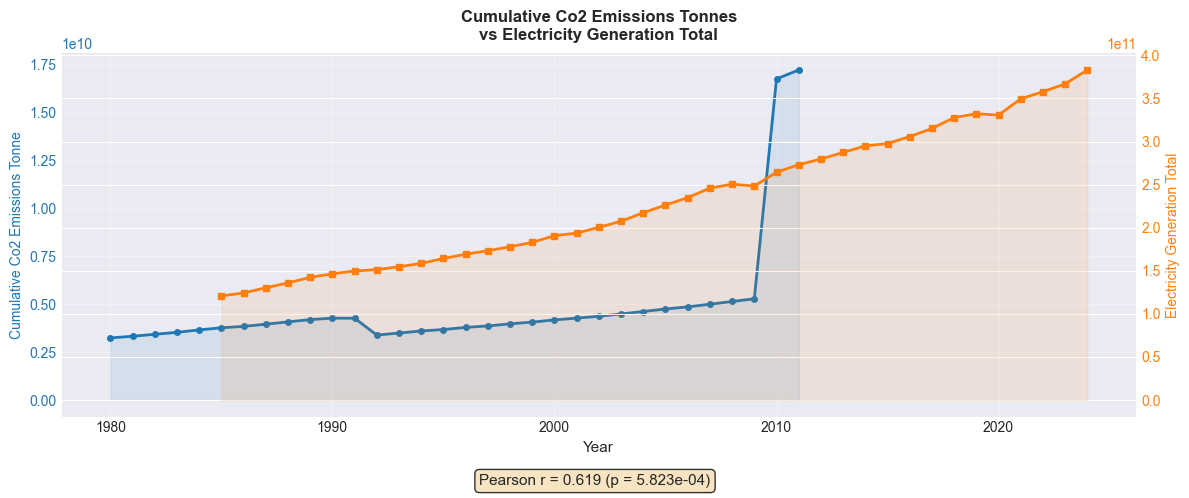

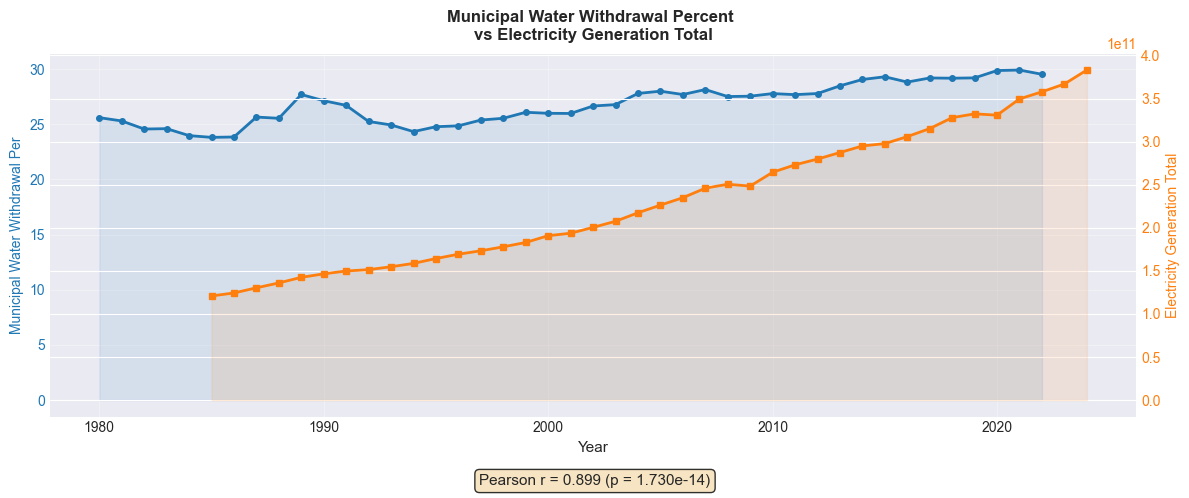

In [32]:
import os
from itertools import combinations
def load_environmental_datasets():
    """Load all datasets from the Environmental folder."""
    environmental_dir = Path('./data/gapminder/Environmental')
    datasets = {}
    
    for file in environmental_dir.glob('ddf--datapoints--*--by--geo--time.csv'):
        # Extract indicator name from filename
        parts = file.name.split('--')
        if len(parts) >= 3:
            indicator = parts[2]
            df = pd.read_csv(file)
            datasets[indicator] = df
    
    return datasets
def create_dual_axis_plot(df1, df2, name1, name2, year_range=(1980, 2024)):
    """Create a dual-axis line graph comparing two datasets aggregated by year."""
    # Get indicator column names
    col1 = [c for c in df1.columns if c not in ['geo', 'time']][0]
    col2 = [c for c in df2.columns if c not in ['geo', 'time']][0]
    
    # Filter by year range
    df1_filtered = df1[(df1['time'] >= year_range[0]) & (df1['time'] <= year_range[1])]
    df2_filtered = df2[(df2['time'] >= year_range[0]) & (df2['time'] <= year_range[1])]
    
    # Aggregate by year (mean across all countries)
    agg1 = df1_filtered.groupby('time')[col1].mean().reset_index()
    agg2 = df2_filtered.groupby('time')[col2].mean().reset_index()
    
    if len(agg1) == 0 or len(agg2) == 0:
        return None
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # First axis
    color1 = '#1f77b4'
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel(name1.replace('_', ' ').title()[:30], color=color1, fontsize=10)
    ax1.plot(agg1['time'], agg1[col1], color=color1, linewidth=2, marker='o', markersize=4, label=name1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.fill_between(agg1['time'], agg1[col1], alpha=0.1, color=color1)
    
    # Second axis
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel(name2.replace('_', ' ').title()[:30], color=color2, fontsize=10)
    ax2.plot(agg2['time'], agg2[col2], color=color2, linewidth=2, marker='s', markersize=4, label=name2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.fill_between(agg2['time'], agg2[col2], alpha=0.1, color=color2)
    
    # Environmental correlation
    merged = agg1.merge(agg2, on='time', how='inner')
    if len(merged) > 2:
        corr, p_val = pearsonr(merged[col1], merged[col2])
        corr_text = f'Pearson r = {corr:.3f} (p = {p_val:.3e})'
        fig.text(0.5, 0.02, corr_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Title
    title1 = name1.replace('_', ' ').title()[:35]
    title2 = name2.replace('_', ' ').title()[:35]
    plt.title(f'{title1}\nvs {title2}', fontsize=12, fontweight='bold', pad=10)
    
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    ax1.grid(True, alpha=0.3)
    
    return fig
# Load all Environmental datasets
print('Loading Environmental datasets...')
environmental_datasets = load_environmental_datasets()
print(f'Found {len(environmental_datasets)} datasets in Environmental folder:')
for name in environmental_datasets.keys():
    print(f'  - {name}')
# Create dual-axis plots for all combinations
print('\n' + '='*70)
print('DUAL-AXIS LINE GRAPHS FOR ENVIRONMENTAL DATASETS')
print('='*70 + '\n')
dataset_names = list(environmental_datasets.keys())
for name1, name2 in combinations(dataset_names, 2):
    fig = create_dual_axis_plot(
        environmental_datasets[name1], 
        environmental_datasets[name2],
        name1, 
        name2
    )
    if fig:
        plt.show()
        plt.close()
    else:
        print(f'Could not create plot for {name1} vs {name2} (insufficient data)')

## Mental

Loading Mental datasets...
Found 2 datasets in Mental folder:
  - data_quality_income_per_person
  - working_hours_per_week

DUAL-AXIS LINE GRAPHS FOR MENTAL DATASETS



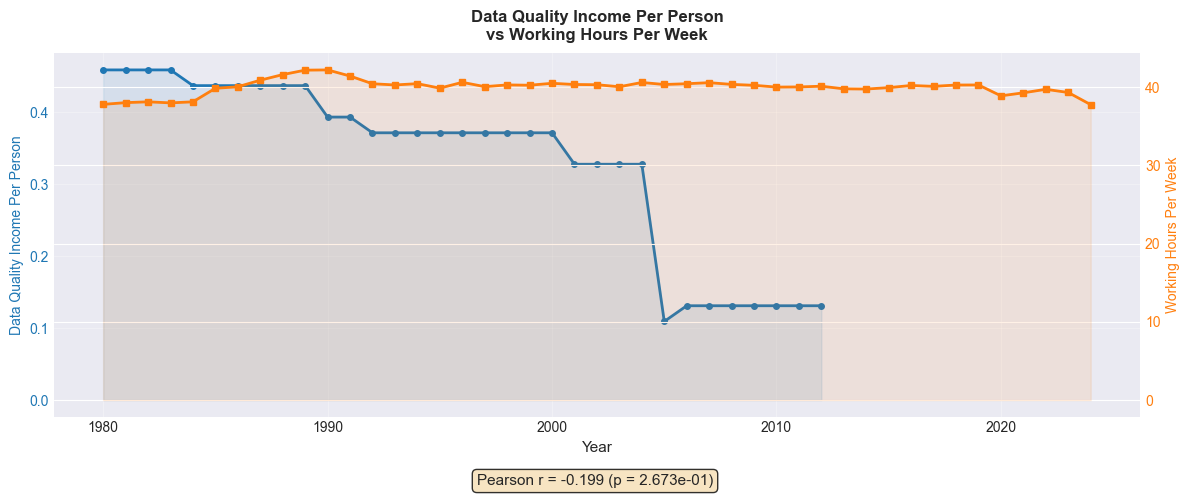

In [33]:
import os
from itertools import combinations
def load_mental_datasets():
    """Load all datasets from the Mental folder."""
    mental_dir = Path('./data/gapminder/Mental')
    datasets = {}
    
    for file in mental_dir.glob('ddf--datapoints--*--by--geo--time.csv'):
        # Extract indicator name from filename
        parts = file.name.split('--')
        if len(parts) >= 3:
            indicator = parts[2]
            df = pd.read_csv(file)
            datasets[indicator] = df
    
    return datasets
def create_dual_axis_plot(df1, df2, name1, name2, year_range=(1980, 2024)):
    """Create a dual-axis line graph comparing two datasets aggregated by year."""
    # Get indicator column names
    col1 = [c for c in df1.columns if c not in ['geo', 'time']][0]
    col2 = [c for c in df2.columns if c not in ['geo', 'time']][0]
    
    # Filter by year range
    df1_filtered = df1[(df1['time'] >= year_range[0]) & (df1['time'] <= year_range[1])]
    df2_filtered = df2[(df2['time'] >= year_range[0]) & (df2['time'] <= year_range[1])]
    
    # Aggregate by year (mean across all countries)
    agg1 = df1_filtered.groupby('time')[col1].mean().reset_index()
    agg2 = df2_filtered.groupby('time')[col2].mean().reset_index()
    
    if len(agg1) == 0 or len(agg2) == 0:
        return None
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # First axis
    color1 = '#1f77b4'
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel(name1.replace('_', ' ').title()[:30], color=color1, fontsize=10)
    ax1.plot(agg1['time'], agg1[col1], color=color1, linewidth=2, marker='o', markersize=4, label=name1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.fill_between(agg1['time'], agg1[col1], alpha=0.1, color=color1)
    
    # Second axis
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel(name2.replace('_', ' ').title()[:30], color=color2, fontsize=10)
    ax2.plot(agg2['time'], agg2[col2], color=color2, linewidth=2, marker='s', markersize=4, label=name2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.fill_between(agg2['time'], agg2[col2], alpha=0.1, color=color2)
    
    # Mental correlation
    merged = agg1.merge(agg2, on='time', how='inner')
    if len(merged) > 2:
        corr, p_val = pearsonr(merged[col1], merged[col2])
        corr_text = f'Pearson r = {corr:.3f} (p = {p_val:.3e})'
        fig.text(0.5, 0.02, corr_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Title
    title1 = name1.replace('_', ' ').title()[:35]
    title2 = name2.replace('_', ' ').title()[:35]
    plt.title(f'{title1}\nvs {title2}', fontsize=12, fontweight='bold', pad=10)
    
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    ax1.grid(True, alpha=0.3)
    
    return fig
# Load all Mental datasets
print('Loading Mental datasets...')
mental_datasets = load_mental_datasets()
print(f'Found {len(mental_datasets)} datasets in Mental folder:')
for name in mental_datasets.keys():
    print(f'  - {name}')
# Create dual-axis plots for all combinations
print('\n' + '='*70)
print('DUAL-AXIS LINE GRAPHS FOR MENTAL DATASETS')
print('='*70 + '\n')
dataset_names = list(mental_datasets.keys())
for name1, name2 in combinations(dataset_names, 2):
    fig = create_dual_axis_plot(
        mental_datasets[name1], 
        mental_datasets[name2],
        name1, 
        name2
    )
    if fig:
        plt.show()
        plt.close()
    else:
        print(f'Could not create plot for {name1} vs {name2} (insufficient data)')

## Physical

Loading Physical datasets...
Found 4 datasets in Physical folder:
  - body_mass_index_bmi_men_kgperm2
  - suicide_per_100000_people
  - data_quality_life_expectancy
  - life_expectancy_at_birth_data_from_ihme

DUAL-AXIS LINE GRAPHS FOR PHYSICAL DATASETS



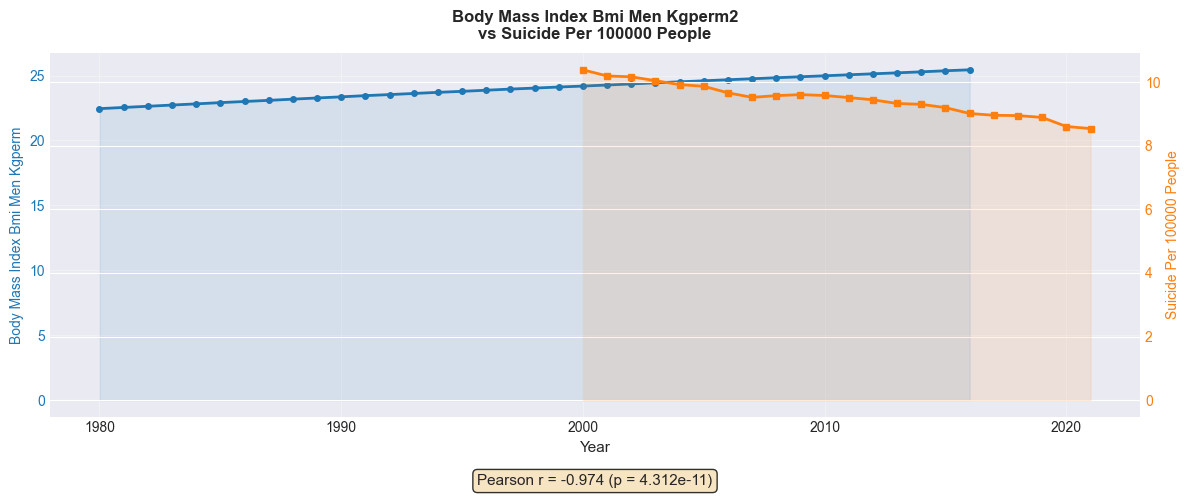

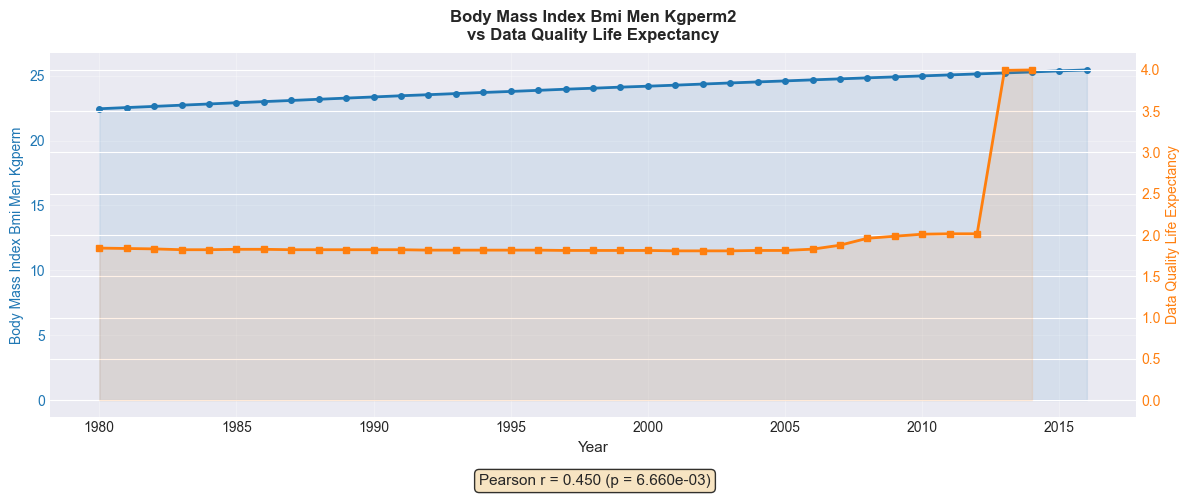

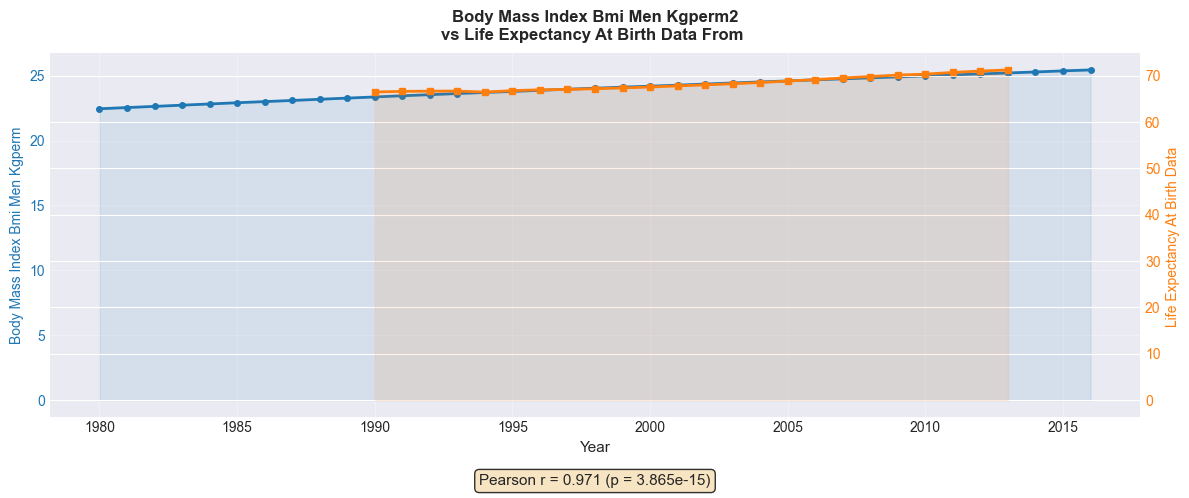

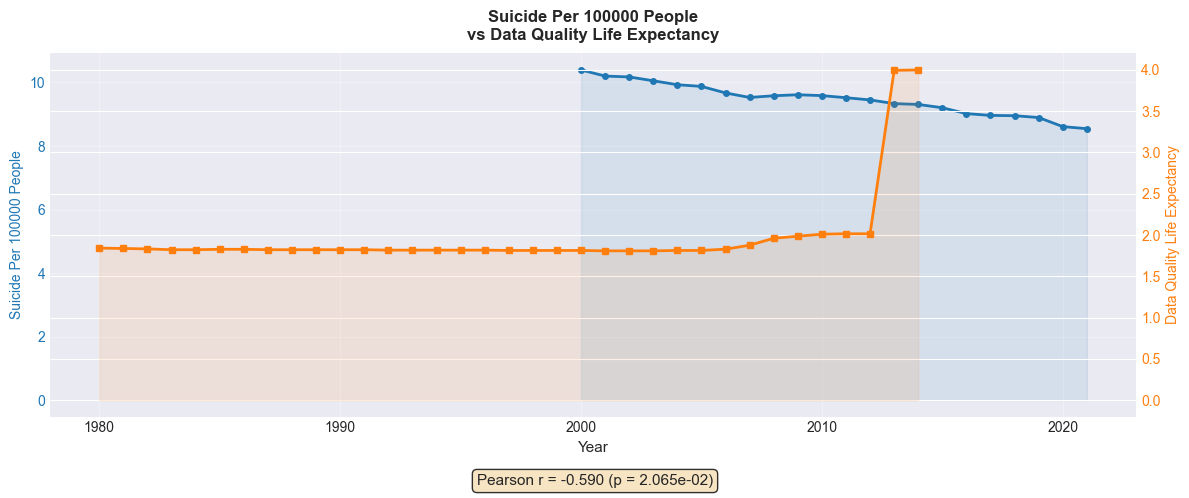

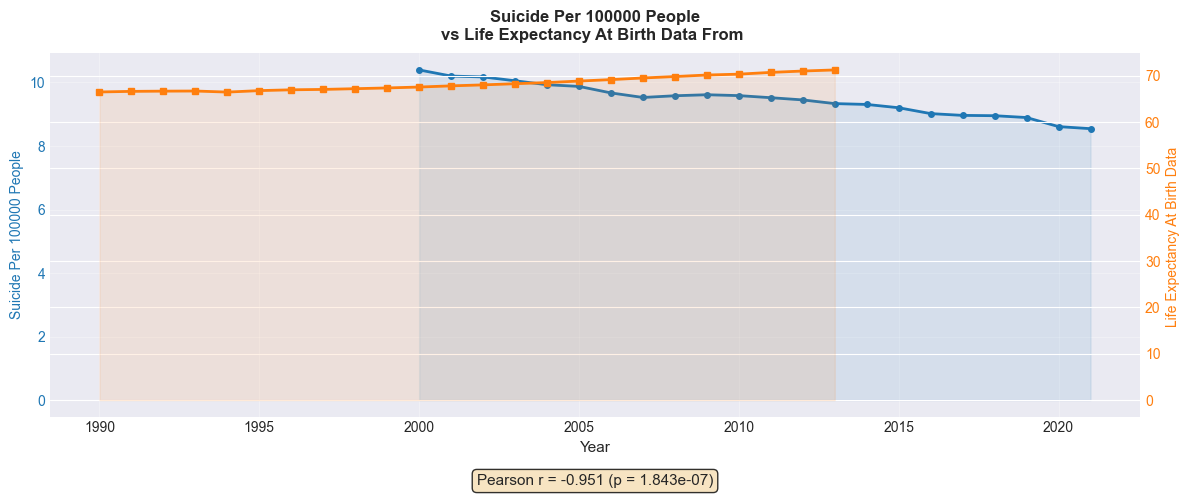

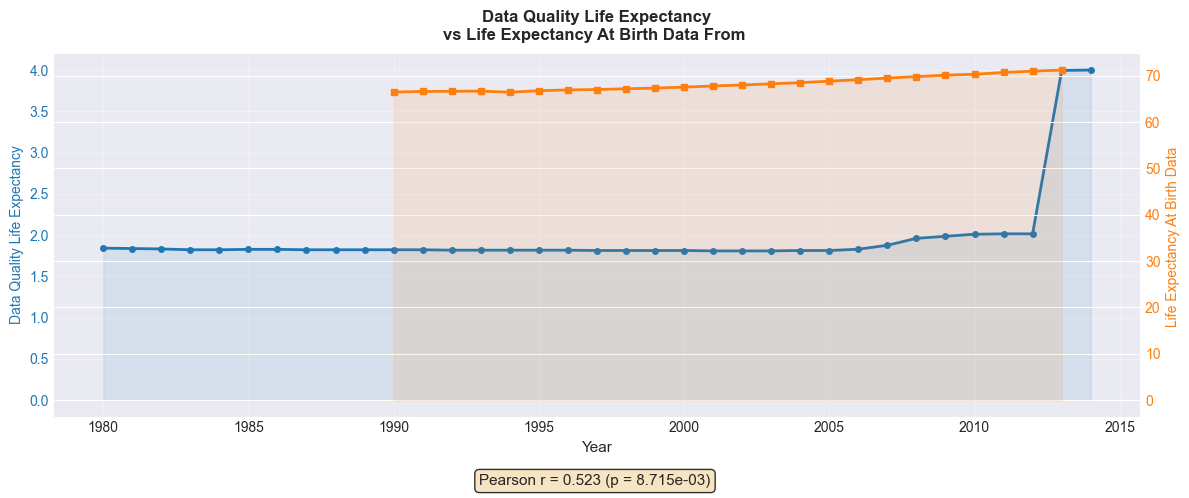

In [35]:
import os
from itertools import combinations
def load_physical_datasets():
    """Load all datasets from the Physical folder."""
    physical_dir = Path('./data/gapminder/Physical')
    datasets = {}
    
    for file in physical_dir.glob('ddf--datapoints--*--by--geo--time.csv'):
        # Extract indicator name from filename
        parts = file.name.split('--')
        if len(parts) >= 3:
            indicator = parts[2]
            df = pd.read_csv(file)
            datasets[indicator] = df
    
    return datasets
def create_dual_axis_plot(df1, df2, name1, name2, year_range=(1980, 2024)):
    """Create a dual-axis line graph comparing two datasets aggregated by year."""
    # Get indicator column names
    col1 = [c for c in df1.columns if c not in ['geo', 'time']][0]
    col2 = [c for c in df2.columns if c not in ['geo', 'time']][0]
    
    # Filter by year range
    df1_filtered = df1[(df1['time'] >= year_range[0]) & (df1['time'] <= year_range[1])]
    df2_filtered = df2[(df2['time'] >= year_range[0]) & (df2['time'] <= year_range[1])]
    
    # Aggregate by year (mean across all countries)
    agg1 = df1_filtered.groupby('time')[col1].mean().reset_index()
    agg2 = df2_filtered.groupby('time')[col2].mean().reset_index()
    
    if len(agg1) == 0 or len(agg2) == 0:
        return None
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # First axis
    color1 = '#1f77b4'
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel(name1.replace('_', ' ').title()[:30], color=color1, fontsize=10)
    ax1.plot(agg1['time'], agg1[col1], color=color1, linewidth=2, marker='o', markersize=4, label=name1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.fill_between(agg1['time'], agg1[col1], alpha=0.1, color=color1)
    
    # Second axis
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel(name2.replace('_', ' ').title()[:30], color=color2, fontsize=10)
    ax2.plot(agg2['time'], agg2[col2], color=color2, linewidth=2, marker='s', markersize=4, label=name2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.fill_between(agg2['time'], agg2[col2], alpha=0.1, color=color2)
    
    # Physical correlation
    merged = agg1.merge(agg2, on='time', how='inner')
    if len(merged) > 2:
        corr, p_val = pearsonr(merged[col1], merged[col2])
        corr_text = f'Pearson r = {corr:.3f} (p = {p_val:.3e})'
        fig.text(0.5, 0.02, corr_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Title
    title1 = name1.replace('_', ' ').title()[:35]
    title2 = name2.replace('_', ' ').title()[:35]
    plt.title(f'{title1}\nvs {title2}', fontsize=12, fontweight='bold', pad=10)
    
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    ax1.grid(True, alpha=0.3)
    
    return fig
# Load all Physical datasets
print('Loading Physical datasets...')
physical_datasets = load_physical_datasets()
print(f'Found {len(physical_datasets)} datasets in Physical folder:')
for name in physical_datasets.keys():
    print(f'  - {name}')
# Create dual-axis plots for all combinations
print('\n' + '='*70)
print('DUAL-AXIS LINE GRAPHS FOR PHYSICAL DATASETS')
print('='*70 + '\n')
dataset_names = list(physical_datasets.keys())
for name1, name2 in combinations(dataset_names, 2):
    fig = create_dual_axis_plot(
        physical_datasets[name1], 
        physical_datasets[name2],
        name1, 
        name2
    )
    if fig:
        plt.show()
        plt.close()
    else:
        print(f'Could not create plot for {name1} vs {name2} (insufficient data)')

## Social

Loading Social datasets...
Found 7 datasets in Social folder:
  - urban_population
  - cell_phones_per_100_people
  - personal_computers_per_100_people
  - inequality_index_gini
  - internet_users
  - government_and_society_aid_given_percent_of_aid
  - blood_pressure_sbp_men_mmhg

DUAL-AXIS LINE GRAPHS FOR SOCIAL DATASETS



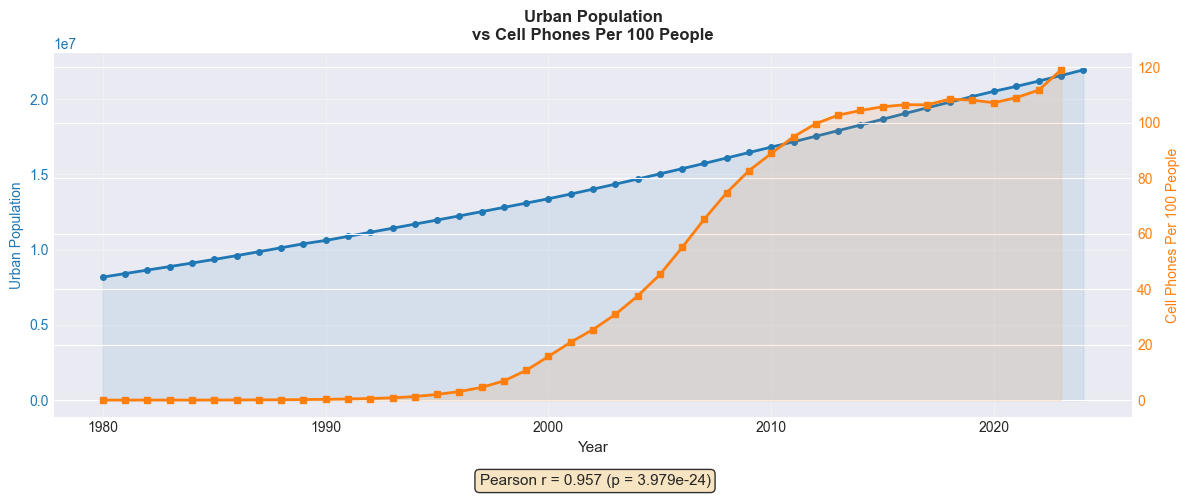

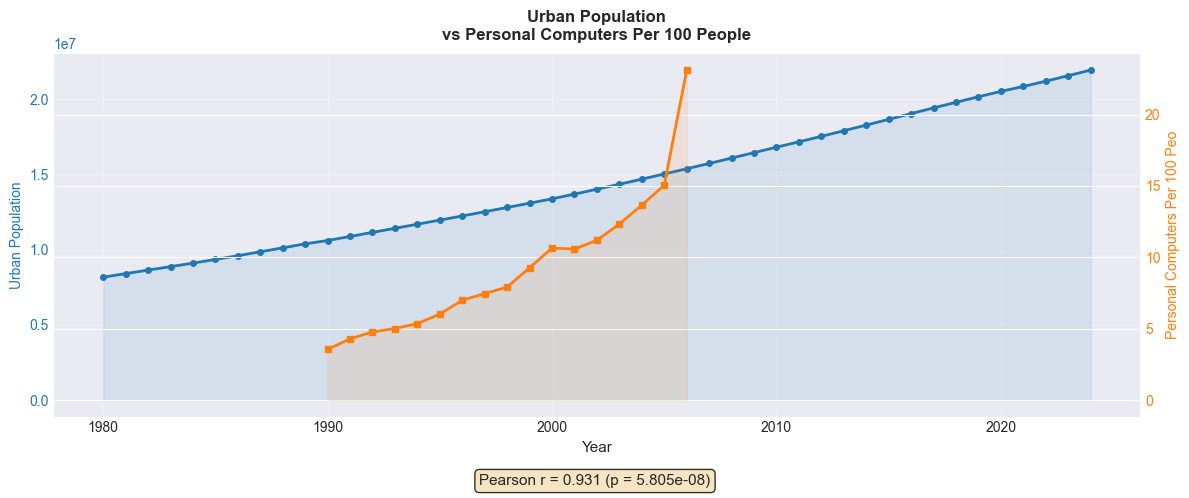

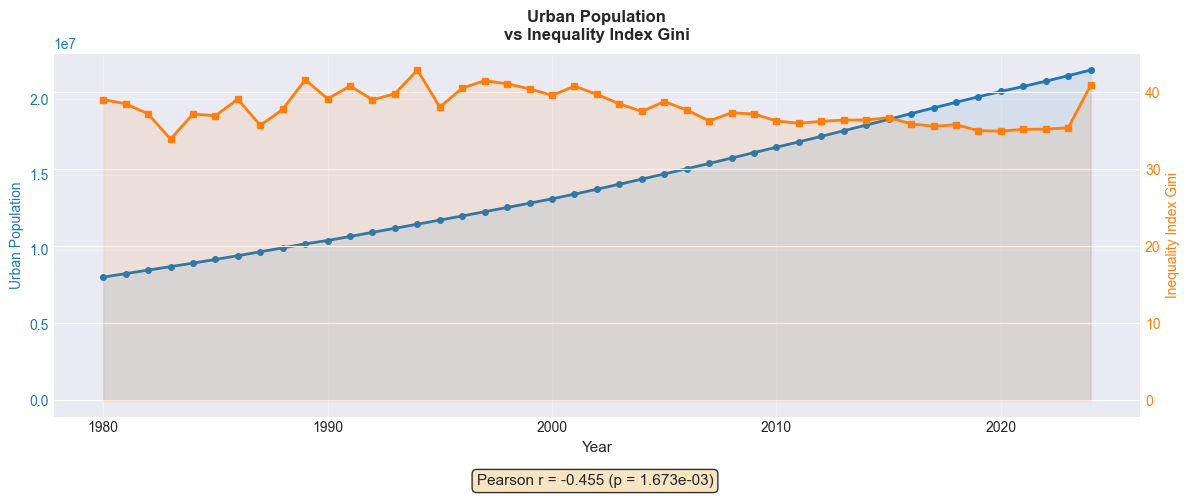

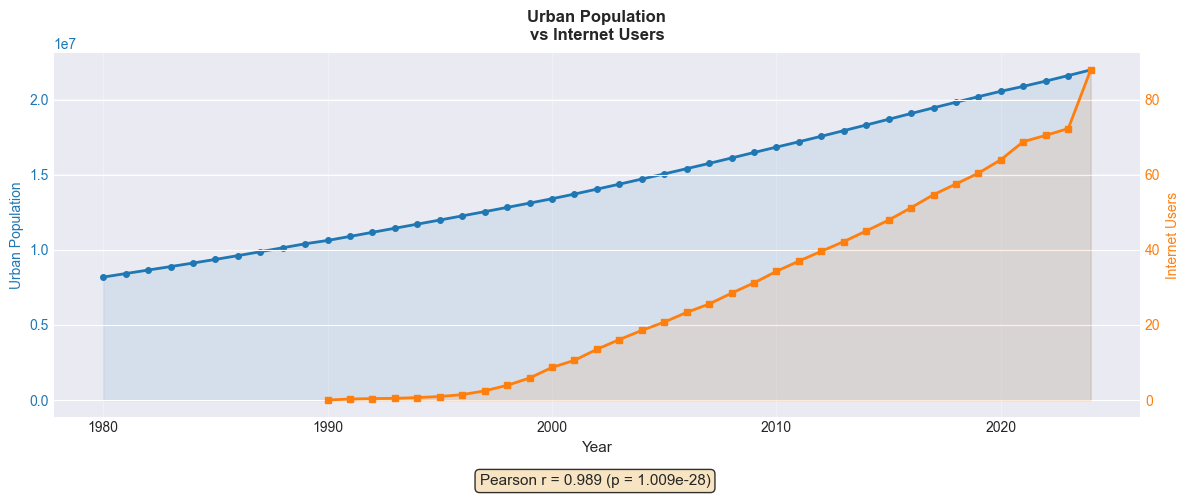

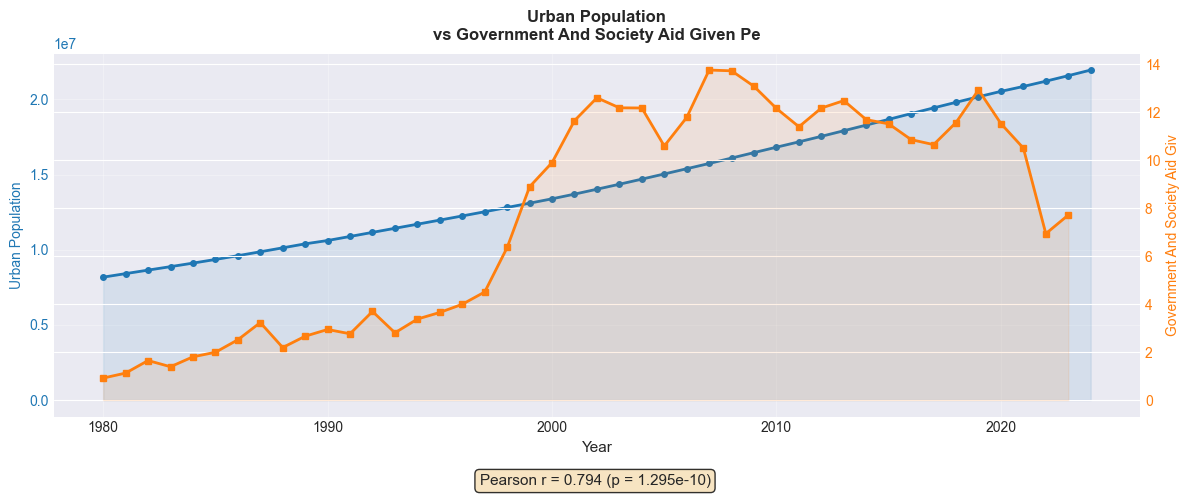

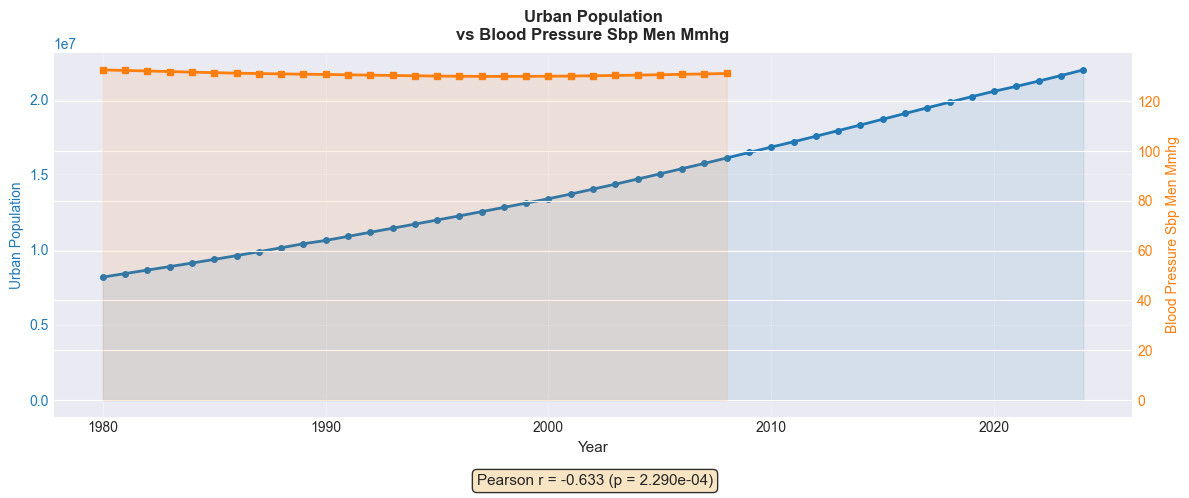

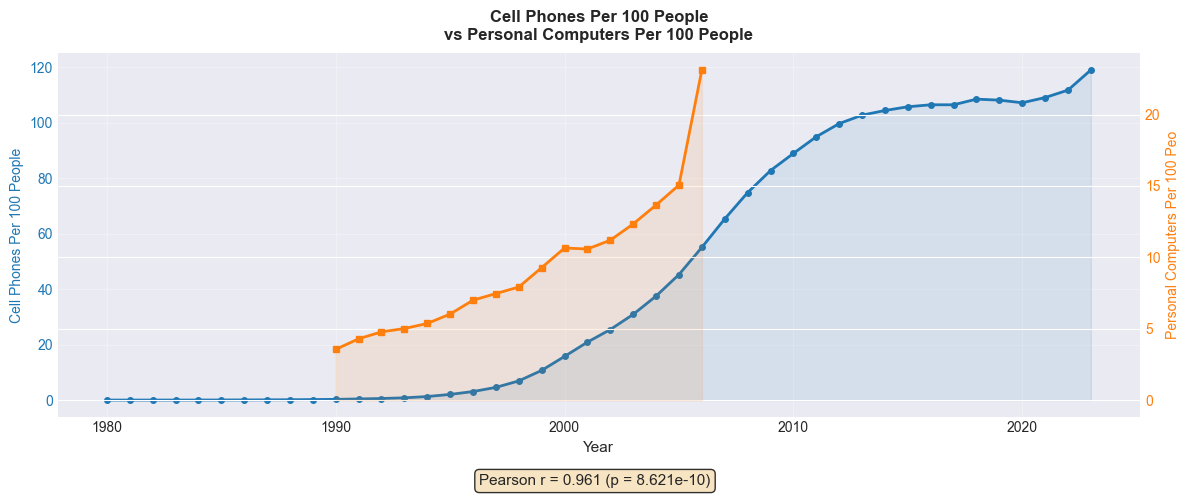

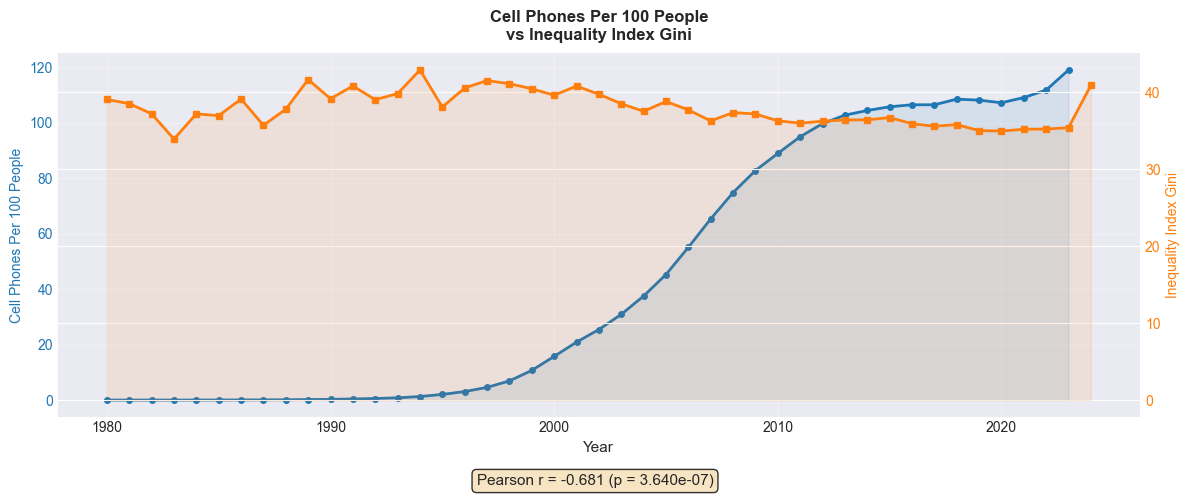

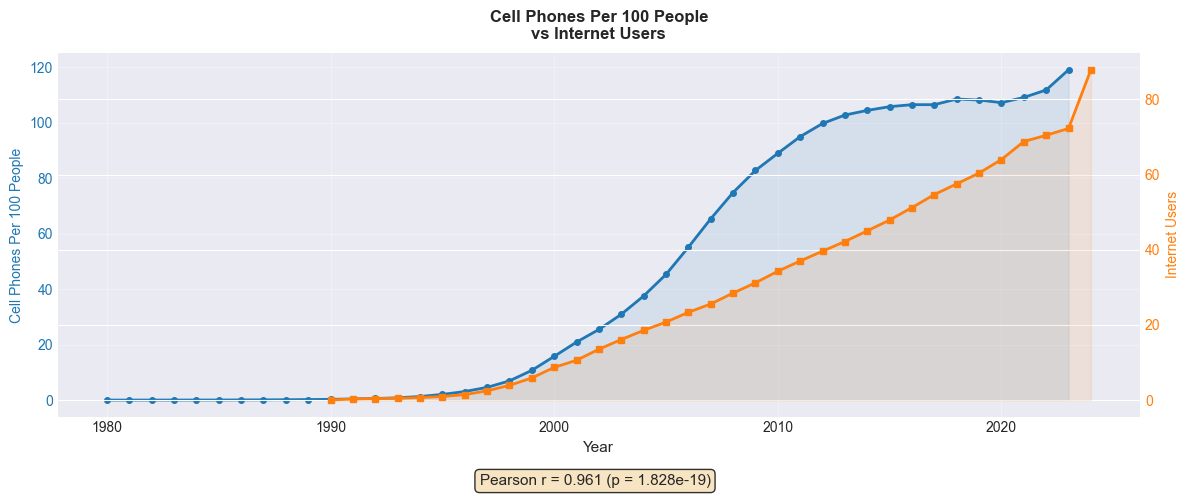

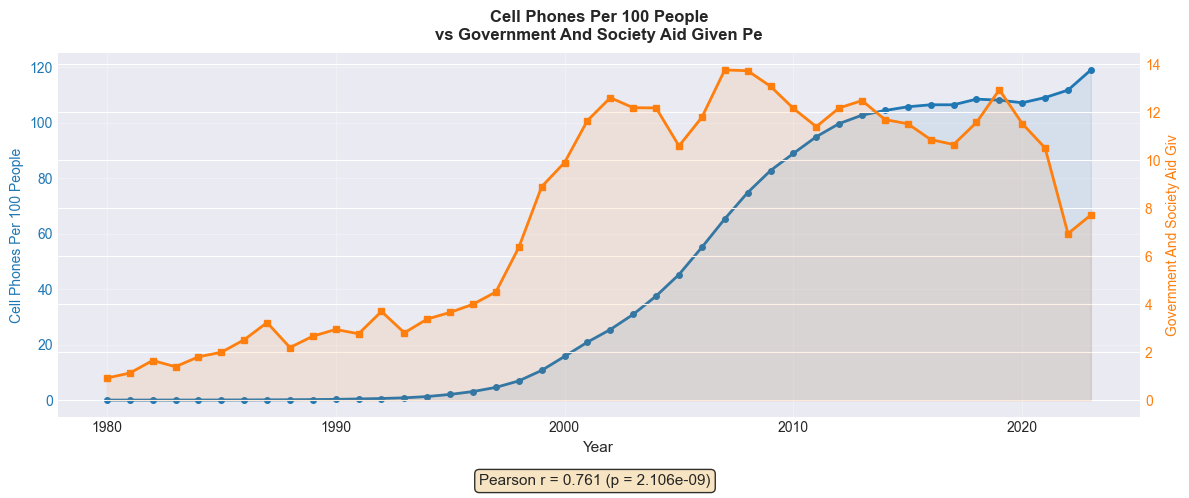

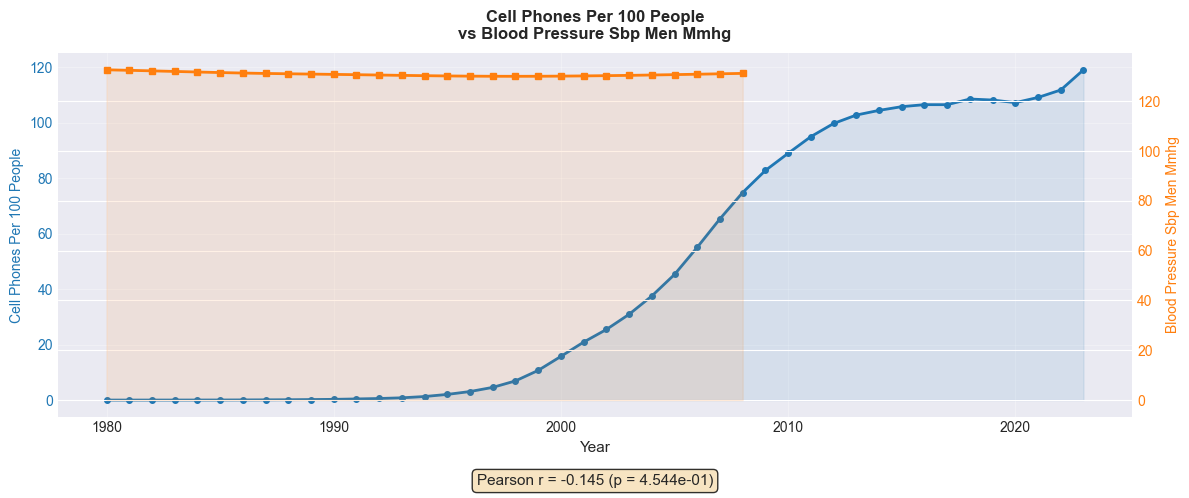

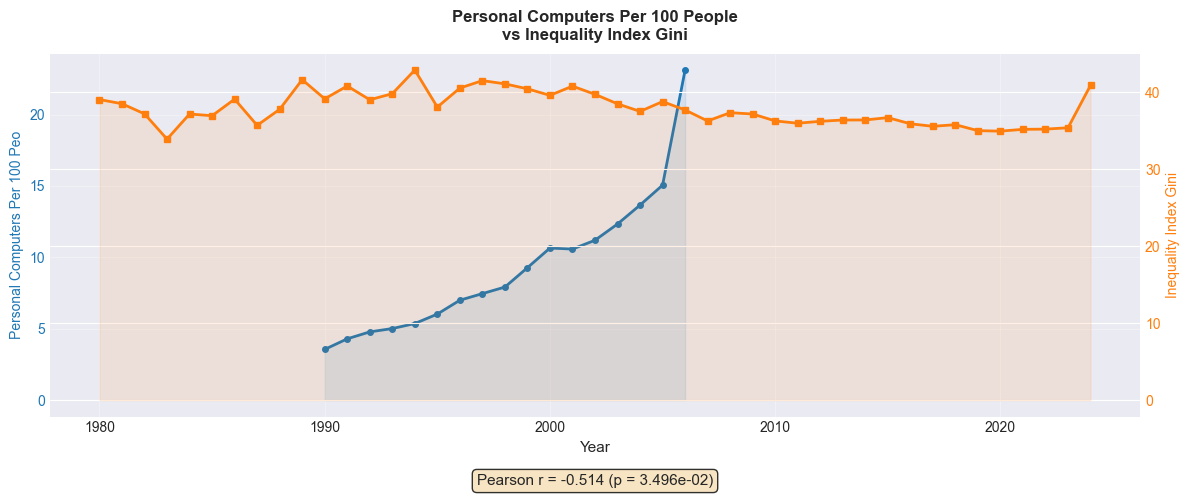

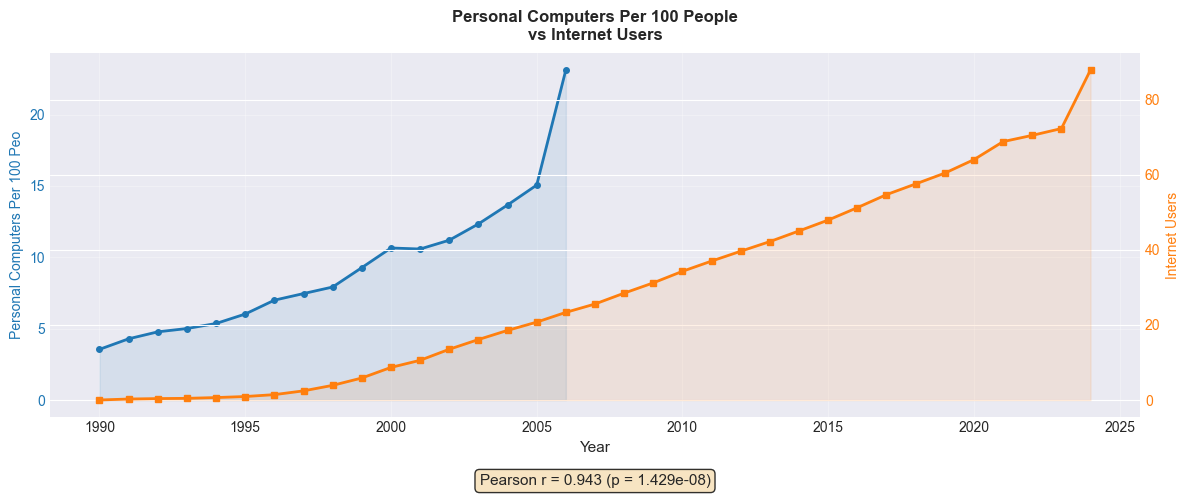

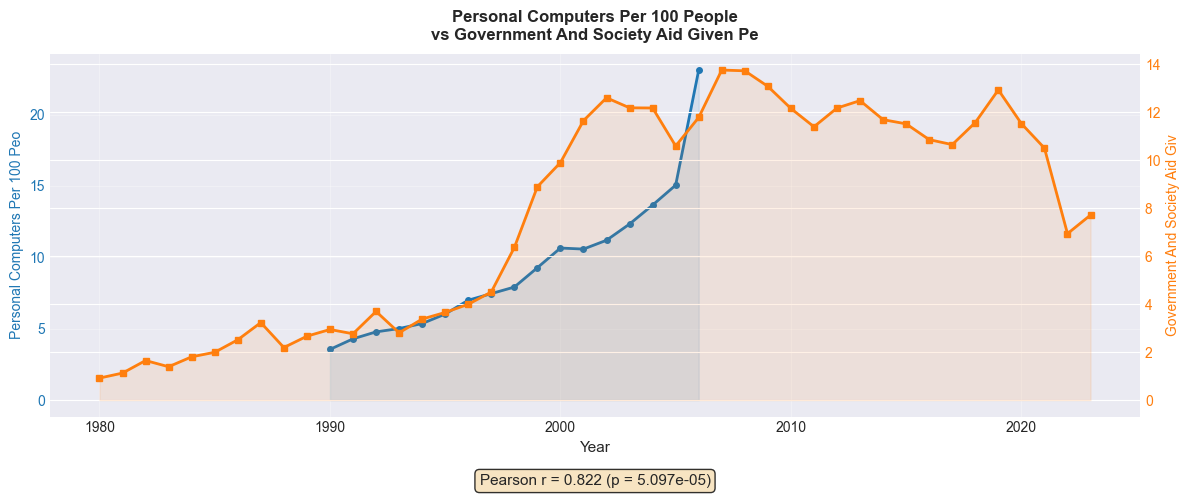

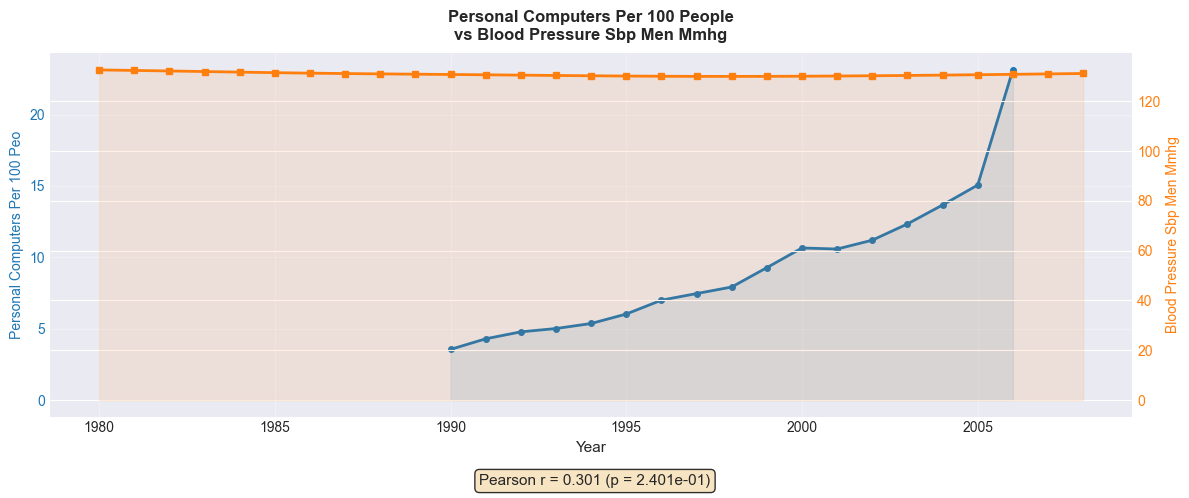

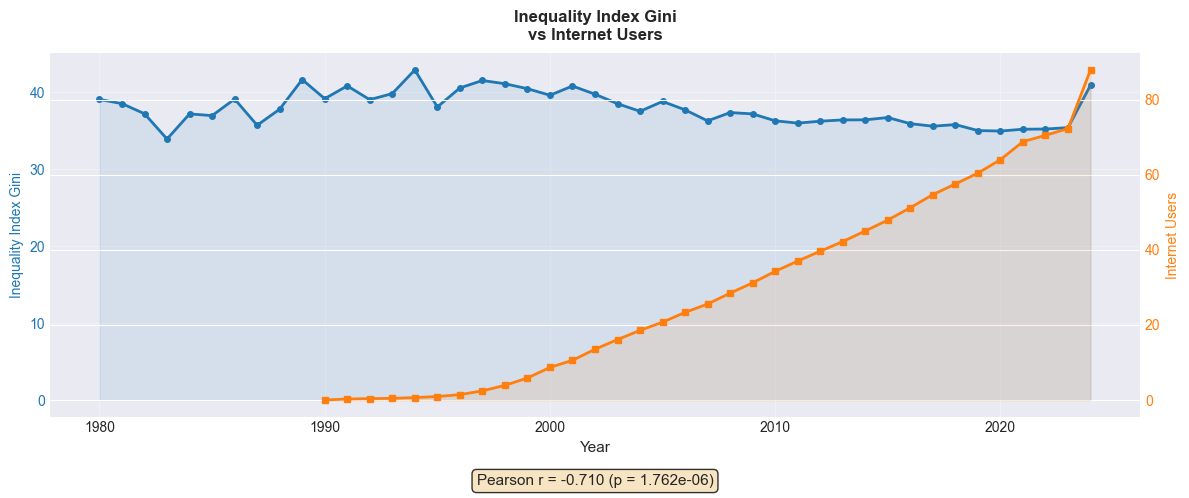

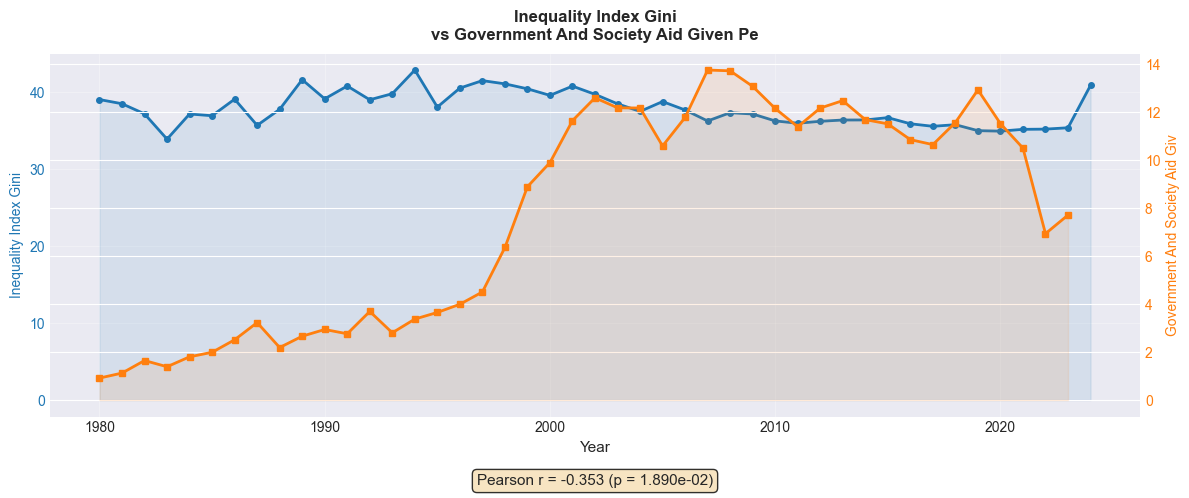

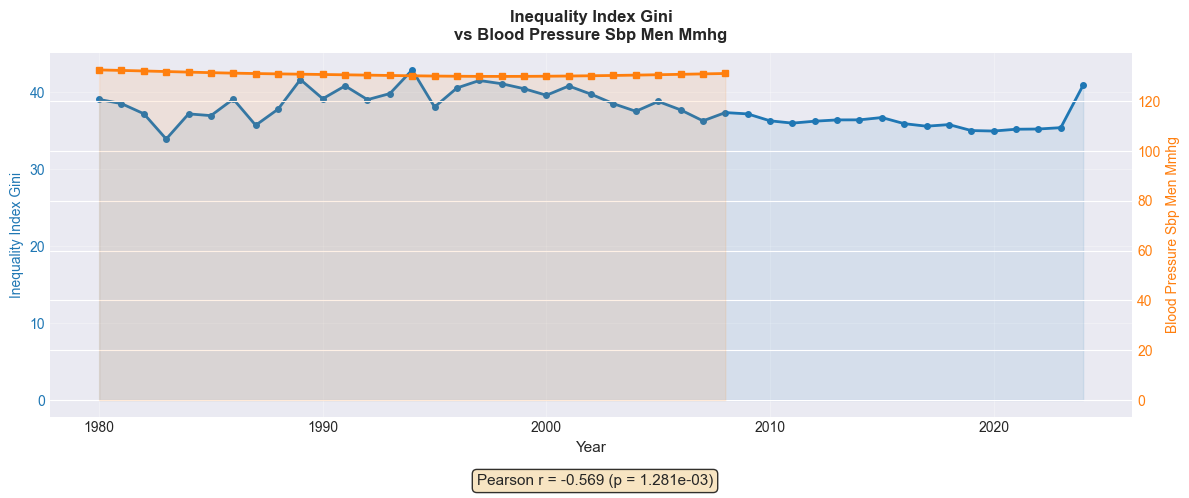

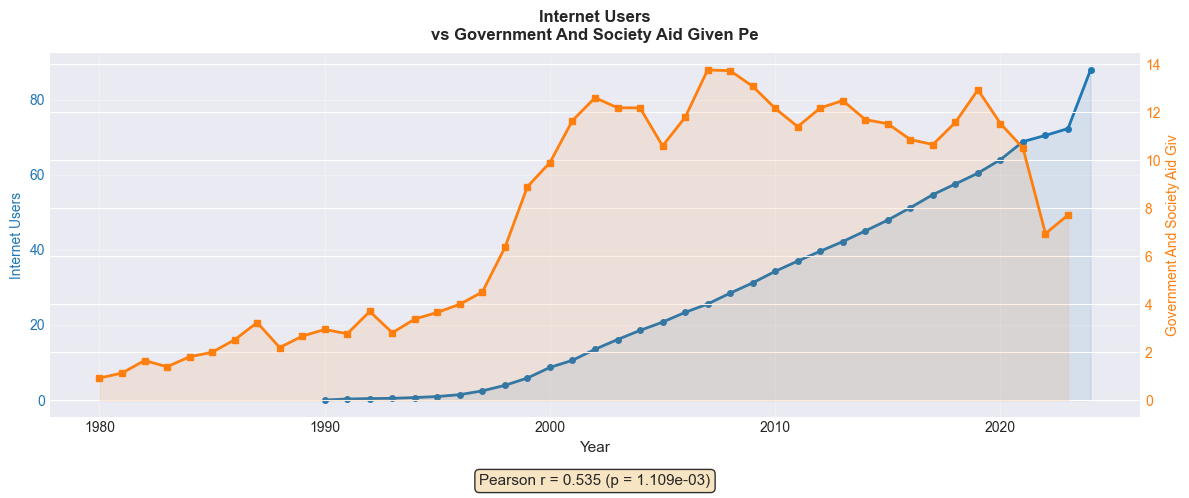

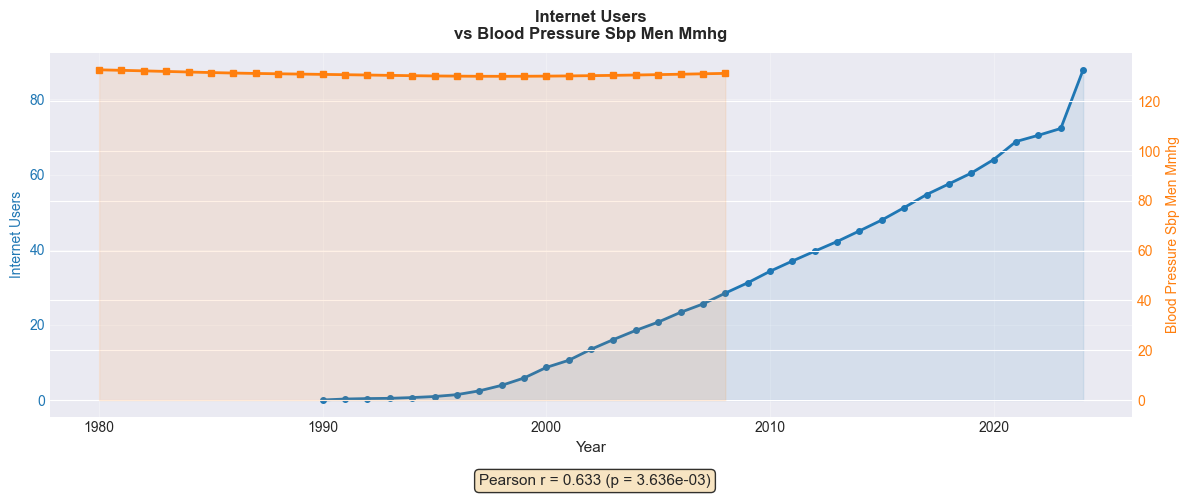

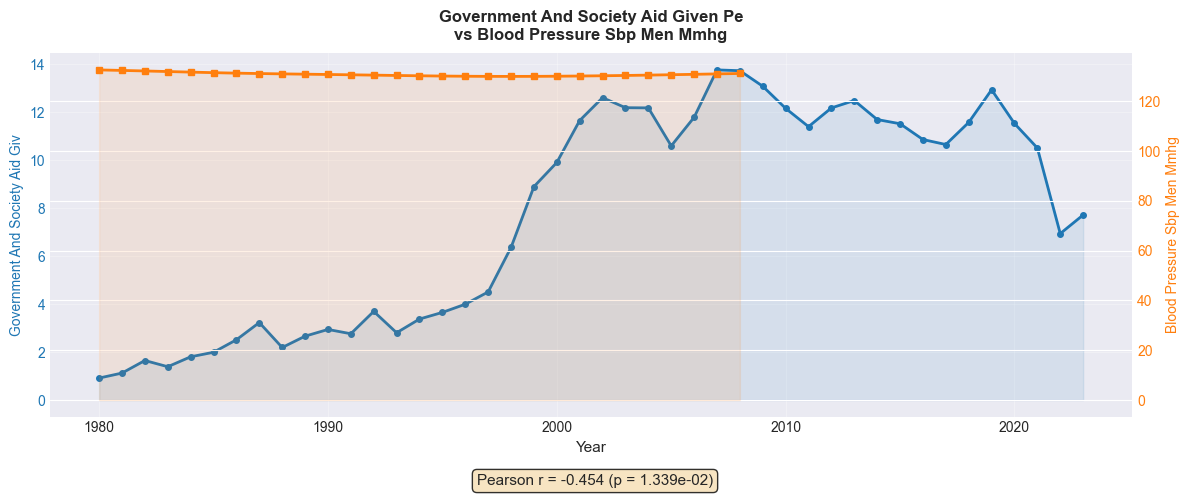

In [37]:
import os
from itertools import combinations
def load_social_datasets():
    """Load all datasets from the Social folder."""
    social_dir = Path('./data/gapminder/Social')
    datasets = {}
    
    for file in social_dir.glob('ddf--datapoints--*--by--geo--time.csv'):
        # Extract indicator name from filename
        parts = file.name.split('--')
        if len(parts) >= 3:
            indicator = parts[2]
            df = pd.read_csv(file)
            datasets[indicator] = df
    
    return datasets
def create_dual_axis_plot(df1, df2, name1, name2, year_range=(1980, 2024)):
    """Create a dual-axis line graph comparing two datasets aggregated by year."""
    # Get indicator column names
    col1 = [c for c in df1.columns if c not in ['geo', 'time']][0]
    col2 = [c for c in df2.columns if c not in ['geo', 'time']][0]
    
    # Filter by year range
    df1_filtered = df1[(df1['time'] >= year_range[0]) & (df1['time'] <= year_range[1])]
    df2_filtered = df2[(df2['time'] >= year_range[0]) & (df2['time'] <= year_range[1])]
    
    # Aggregate by year (mean across all countries)
    agg1 = df1_filtered.groupby('time')[col1].mean().reset_index()
    agg2 = df2_filtered.groupby('time')[col2].mean().reset_index()
    
    if len(agg1) == 0 or len(agg2) == 0:
        return None
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # First axis
    color1 = '#1f77b4'
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel(name1.replace('_', ' ').title()[:30], color=color1, fontsize=10)
    ax1.plot(agg1['time'], agg1[col1], color=color1, linewidth=2, marker='o', markersize=4, label=name1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.fill_between(agg1['time'], agg1[col1], alpha=0.1, color=color1)
    
    # Second axis
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel(name2.replace('_', ' ').title()[:30], color=color2, fontsize=10)
    ax2.plot(agg2['time'], agg2[col2], color=color2, linewidth=2, marker='s', markersize=4, label=name2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.fill_between(agg2['time'], agg2[col2], alpha=0.1, color=color2)
    
    # Social correlation
    merged = agg1.merge(agg2, on='time', how='inner')
    if len(merged) > 2:
        corr, p_val = pearsonr(merged[col1], merged[col2])
        corr_text = f'Pearson r = {corr:.3f} (p = {p_val:.3e})'
        fig.text(0.5, 0.02, corr_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Title
    title1 = name1.replace('_', ' ').title()[:35]
    title2 = name2.replace('_', ' ').title()[:35]
    plt.title(f'{title1}\nvs {title2}', fontsize=12, fontweight='bold', pad=10)
    
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    ax1.grid(True, alpha=0.3)
    
    return fig
# Load all Social datasets
print('Loading Social datasets...')
social_datasets = load_social_datasets()
print(f'Found {len(social_datasets)} datasets in Social folder:')
for name in social_datasets.keys():
    print(f'  - {name}')
# Create dual-axis plots for all combinations
print('\n' + '='*70)
print('DUAL-AXIS LINE GRAPHS FOR SOCIAL DATASETS')
print('='*70 + '\n')
dataset_names = list(social_datasets.keys())
for name1, name2 in combinations(dataset_names, 2):
    fig = create_dual_axis_plot(
        social_datasets[name1], 
        social_datasets[name2],
        name1, 
        name2
    )
    if fig:
        plt.show()
        plt.close()
    else:
        print(f'Could not create plot for {name1} vs {name2} (insufficient data)')